# Faraday Dreams Real Data Example

Then recovery is performed using Faraday Dreams + Optimus Primal on real data.

In [1]:
import sys
sys.path.insert(0,'..')
#put path to optimusprimal git repo
sys.path.insert(0,'../../Optimus-Primal')
import optimusprimal.prox_operators as prox_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.primal_dual as primal_dual
import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.models as models
import faradaydreams.plot_spectrum as plot_spectrum
import faradaydreams.convex_solvers as solvers
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

Reads the data and sets up the observation

In [2]:
#data from http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/ApJ/825/59/table6
table_data = Table.read("../data/anderson_rms.vot")
sources = np.array(np.unique(table_data['ID']))
def get_data(source, table_data, sigma_factor):
    data = table_data[table_data['ID']==source]
    y =  np.array(data['Q'] + 1j * data['U'])
    weights_q = np.array(data['e_Q'])
    weights_u = np.array(data['e_U'])
    sigma = np.std(np.abs(weights_q + 1j * weights_u)) 
    sigma = sig_factor * sigma
    c = 2.92 * 10**8 #speed of light m/s
    m_size = len(y) #numbr of channels
    freq0 = np.real(data["nu"]) * 10**9  # frequency coverage
    dfreq = np.abs(20 * 10**6) # channel width
    lambda2 = (c/freq0)**2 #wavelength^2 coverage
    lambda1 = np.sqrt(lambda2) # wavelength coverage
    dlambda2 = (c/(freq0 - dfreq/2.))**2 - (c/(freq0 + dfreq/2.))**2 #channel width in wavelength squared.
    phi_max, phi_min, dphi = measurement_operator.phi_parameters(lambda2, dlambda2) #sensitivity estiamtes given coverage
    phi_max = 1000
    phi_min = -1000
    dphi = 20.
    phi = np.arange(-1e3, 1e3, dphi/2., dtype=float) # range in rad/m^2 to do reconstruction of signal
    weights = np.std(np.abs(weights_q + 1j * weights_u))/np.abs(weights_q + 1j * weights_u) #choosing flat noise
    return y, weights, phi, lambda2, dlambda2, sigma

In [52]:
def plot_results(solution_right, solution_wrong, y, weights, phi, lambda2, dlambda2, sigma, rm_max):
    m_op_right = measurement_operator.faraday_operator(lambda2, phi, weights, dlambda2)
    m_op_wrong = measurement_operator.faraday_operator(lambda2, phi, lambda2* 0 + 1)
    # measurement operator without channel averaging
    lambda2_high_res = np.linspace(np.min(lambda2), np.max(lambda2), 1024)
    lambda1_high_res = np.sqrt(lambda2_high_res)
    m_op_no_averaging = measurement_operator.faraday_operator(lambda2_high_res, phi, lambda2_high_res * 0 + 1)
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), dpi=80)
    ax[0].errorbar(lambda2, np.real(y), yerr=1/weights/sigma/np.sqrt(2), fmt='',linestyle='')
    ax[0].errorbar(lambda2, np.imag(y), yerr=1/weights/ sigma/np.sqrt(2), fmt='',linestyle='')
    ax[0].set_ylim([-np.max(np.abs(y)),np.max(np.abs(y))])
    ax[0].set_xlim([0,0.25**2])
    ax[0].set_xlabel(r"$\lambda^2$ (m^2)")
    ax[0].set_ylabel(r"(Jy)")
    ax[0].legend(["Observed (Real)", "Observed (Real)"])
    ax[1].plot(phi, np.abs(m_op_right.adj_op(y  * weights)) * 1./len(y))
    ax[2].plot(phi, np.abs(m_op_right.adj_op((y * 0. + 1) * weights/np.sum(weights))) * 1./len(y))
    ax[1].legend(["Dirty | |"])
    ax[1].set_xlabel(r"$\phi$ (rad/m$^2$)")
    ax[1].set_ylabel(r"(Jy)")
    ax[2].legend(["PSF | |"])
    ax[2].set_xlabel(r"$\phi$ (rad/m$^2$)")
    ax[2].set_ylabel(r"(Jy)")
    y_right = m_op_right.dir_op(solution_right) 
    y_wrong = m_op_wrong.dir_op(solution_wrong) 
    y_model_right = m_op_no_averaging.dir_op(solution_right)
    y_model_wrong = m_op_no_averaging.dir_op(solution_wrong) 
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), dpi=80)
    ax = np.ravel(ax)
    ax[0].plot(lambda2_high_res, np.real(y_model_right))
    ax[0].plot(lambda2_high_res, np.imag(y_model_right))
    ax[0].plot(lambda2_high_res, np.real(y_model_wrong))
    ax[0].plot(lambda2_high_res, np.imag(y_model_wrong))
    ax[0].errorbar(lambda2, np.real(y), yerr=1/weights * sigma/np.sqrt(2), fmt='',linestyle='')
    ax[0].errorbar(lambda2, np.imag(y), yerr=1/weights * sigma/np.sqrt(2), fmt='',linestyle='')
    ax[0].set_xlim([0., 0.23**2])
    ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
    ax[0].set_ylabel(r"(Jy)")
    ax[0].legend(["Q Corrected", "U Corrected", "Q Not Corrected", "U Not Corrected"])
    ax[1].plot(lambda2, np.real(y_right))
    ax[1].plot(lambda2, np.imag(y_right))
    ax[1].plot(lambda2, np.real(y_wrong))
    ax[1].plot(lambda2, np.imag(y_wrong))
    ax[1].errorbar(lambda2, np.real(y), yerr=1/weights * sigma/np.sqrt(2), fmt='',linestyle='')
    ax[1].errorbar(lambda2, np.imag(y), yerr=1/weights * sigma/np.sqrt(2), fmt='',linestyle='')
    ax[1].set_xlim([0., 0.23**2])
    ax[1].set_xlabel(r"$\lambda^2$ (m$^2$)")
    ax[1].set_ylabel(r"(Jy)")
    ax[1].legend(["Q Corrected Measurements", "U Corrected Measurements", "Q Not Corrected Measurements", "U Not Corrected Measurements","Q Measurements", "U Measurements",])
    ax[2].plot(phi, np.abs(solution_right))
    ax[2].legend([ "Corrected | |"])
    ax[2].set_xlabel(r"$\phi$ (rad/m$^2$)")
    ax[2].set_ylabel(r"(Jy)")
    ax[2].set_xlim([-rm_max, rm_max])
    ax[3].scatter(lambda2, np.real(y - y_right/weights))
    ax[3].scatter(lambda2, np.imag(y - y_right/weights))
    ax[3].set_xlim([0., 0.23**2])
    ax[3].legend(["Residual (Stokes Q)", "Residual (Stokes U)"])
    ax[3].set_xlabel(r"$\lambda^2$ (m$^2$)")
    ax[3].set_ylabel(r"(Jy)")
    ax[4].plot(phi, np.abs(solution_wrong))
    ax[4].legend(["Not Corrected | |"])
    ax[4].set_xlabel(r"$\phi$ (rad/m$^2$)")
    ax[4].set_ylabel(r"(Jy)")
    ax[4].set_xlim([-rm_max, rm_max])
    ax[5].scatter(lambda2, np.real(y - y_wrong/weights))
    ax[5].scatter(lambda2, np.imag(y - y_wrong/weights))
    ax[5].legend(["Residual (Stokes Q)", "Residual (Stokes U)"])
    ax[5].set_xlabel(r"$\lambda^2$ (m$^2$)")
    ax[5].set_ylabel(r"(Jy)")
    ax[5].set_xlim([0., 0.23**2])

In [42]:
def test_source(source, wav, levels, sig_factor,  rm_max, beta):
    y, weights, phi, lambda2, dlambda2, sigma = get_data(source, table_data, sig_factor)
    # measurement operator with channel averaging
    m_op_right = measurement_operator.faraday_operator(lambda2, phi, weights, dlambda2)
    m_op_wrong = measurement_operator.faraday_operator(lambda2, phi, lambda2* 0 + 1)
    options = options={'tol': 1e-6, 'iter': 50000, 'update_iter': 1000, 'record_iters': False}
    #get solution of algo and run
    nu, sol = linear_operators.power_method(m_op_right, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
    solution_right, diag_right = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_right, wav, levels, nu, beta, options)
    #get solution of algo and run
    nu, sol = linear_operators.power_method(m_op_wrong, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
    solution_wrong, diag_wrong = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_wrong, wav, levels, nu, beta, options)
    plot_results(solution_right, solution_wrong, y, weights, phi, lambda2, dlambda2, sigma, rm_max)

In [5]:
print(sources)
print(len(sources))

[b'0515-674' b'1315-46' b'cena_c1093' b'cena_c1152' b'cena_c1435'
 b'cena_c1466' b'cena_c1573' b'cena_c1636' b'cena_c1640' b'cena_c1748'
 b'cena_c1764' b'cena_c1827' b'cena_c1832' b'cena_c1972' b'cena_s1014'
 b'cena_s1031' b'cena_s1290' b'cena_s1349' b'cena_s1382' b'cena_s1437'
 b'cena_s1443' b'cena_s1568' b'cena_s1605' b'cena_s1681' b'cena_s1803'
 b'lmc_c01' b'lmc_c02' b'lmc_c03' b'lmc_c04' b'lmc_c06' b'lmc_c07'
 b'lmc_c15' b'lmc_c16' b'lmc_s11' b'lmc_s13' b'lmc_s14']
36


b'0515-674'
2020-07-18 23:35:13,169 - Faraday Dreams - INFO - φ resolution 19.059294627146272 rad/m^2.
2020-07-18 23:35:13,170 - Faraday Dreams - INFO - φ max range is 285349.0119092751 rad/m^2.
2020-07-18 23:35:13,170 - Faraday Dreams - INFO - φ min range is 607.3368668121005 rad/m^2.
2020-07-18 23:35:13,208 - Optimus Primal - INFO - Starting Power method
2020-07-18 23:35:13,213 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 23:35:13,215 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 23:35:13,216 - Optimus Primal - INFO - [Power Method] Converged with iter = 12, tol = 6.220372806959169e-05
2020-07-18 23:35:13,217 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 23:35:13,220 - Faraday Dreams - INFO - Using an estimated noise level of 6.342221604427323e-05 (weighted image units, i.e. Jy/Beam)
2020-07-18 23:35:13,221 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020

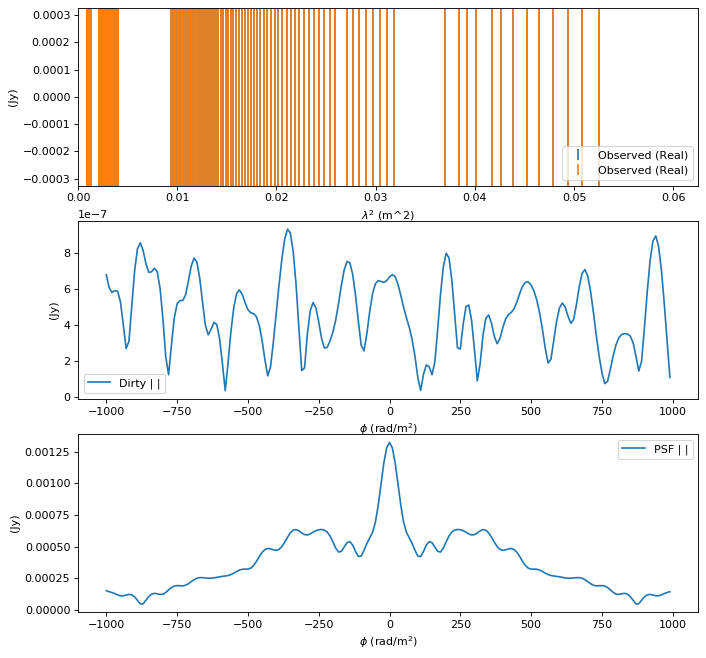

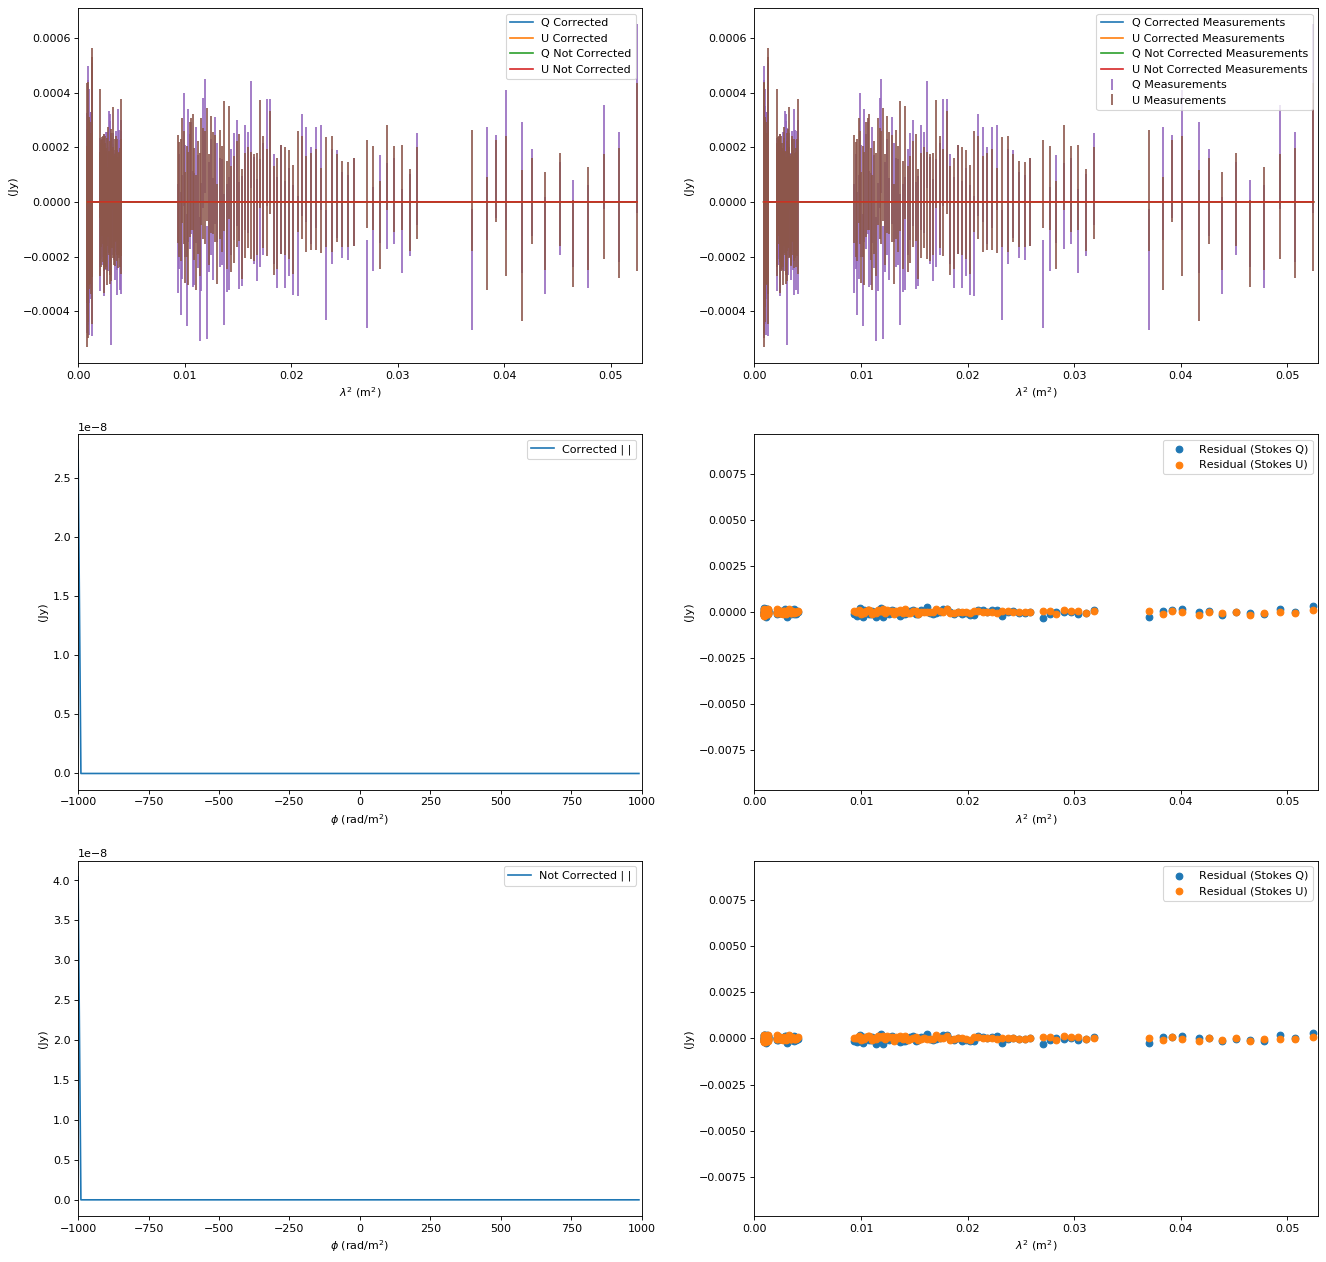

In [43]:
source = sources[0]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-3
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'1315-46'
2020-07-18 23:37:01,663 - Faraday Dreams - INFO - φ resolution 22.839070130711672 rad/m^2.
2020-07-18 23:37:01,663 - Faraday Dreams - INFO - φ max range is 262294.9429406143 rad/m^2.
2020-07-18 23:37:01,664 - Faraday Dreams - INFO - φ min range is 796.701954265227 rad/m^2.
2020-07-18 23:37:01,699 - Optimus Primal - INFO - Starting Power method
2020-07-18 23:37:01,700 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 23:37:01,702 - Optimus Primal - INFO - [Power Method] Converged with iter = 9, tol = 4.2860932170896326e-05
2020-07-18 23:37:01,703 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 23:37:01,703 - Faraday Dreams - INFO - Using an estimated noise level of 0.0001829721877584234 (weighted image units, i.e. Jy/Beam)
2020-07-18 23:37:01,704 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 23:37:01,706 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-

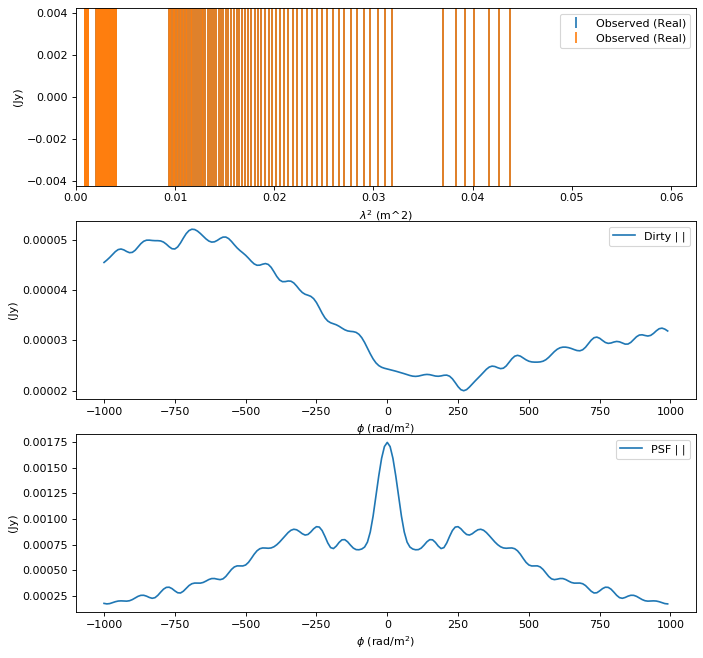

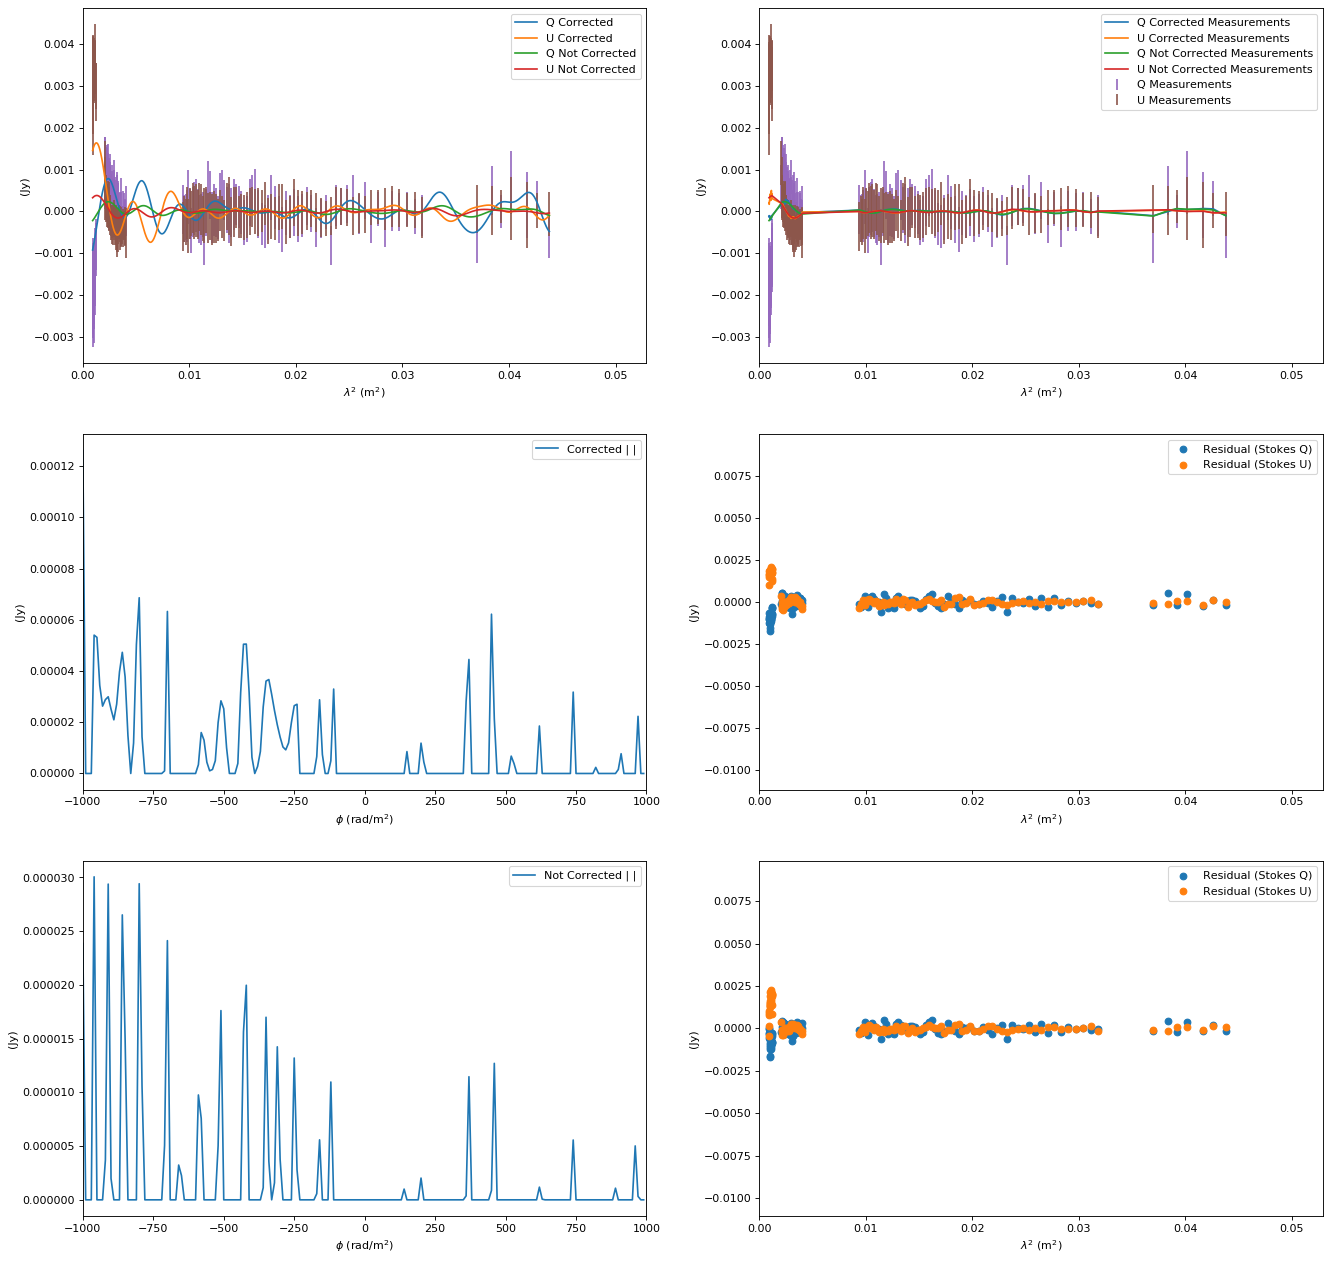

In [45]:
source = sources[1]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 2
rm_max = 1000
beta = 1e-3
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1093'
2020-07-18 16:59:28,586 - Faraday Dreams - INFO - φ resolution 19.82060893267968 rad/m^2.
2020-07-18 16:59:28,587 - Faraday Dreams - INFO - φ max range is 279275.4619333624 rad/m^2.
2020-07-18 16:59:28,588 - Faraday Dreams - INFO - φ min range is 644.0905860130675 rad/m^2.
2020-07-18 16:59:28,619 - Optimus Primal - INFO - Starting Power method
2020-07-18 16:59:28,620 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 16:59:28,622 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 16:59:28,623 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-07-18 16:59:28,624 - Optimus Primal - INFO - [Power Method] Converged with iter = 22, tol = 9.97235667589596e-05
2020-07-18 16:59:28,625 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 16:59:28,625 - Faraday Dreams - INFO - Using an estimated noise level of 0.0003595505258999765 (weighted image units, i.e. Jy/Beam)
2020-07-18 16:59:28,626 - Faraday

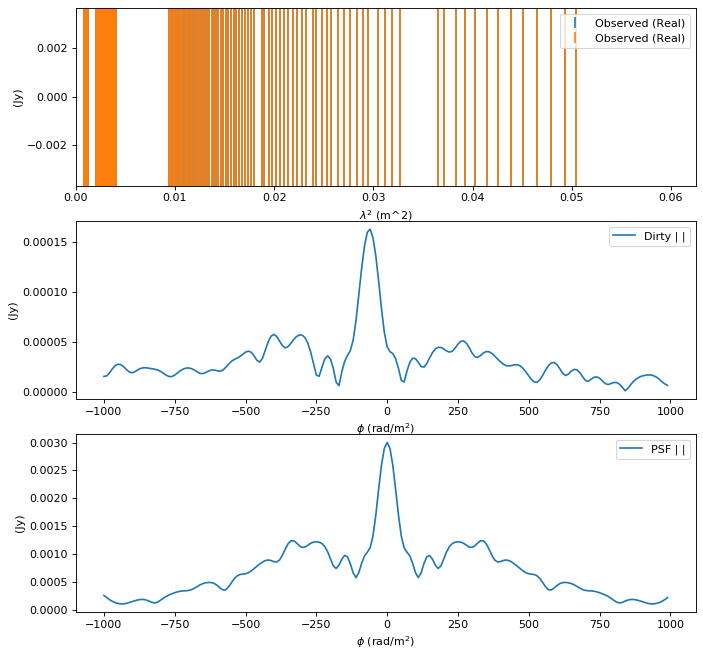

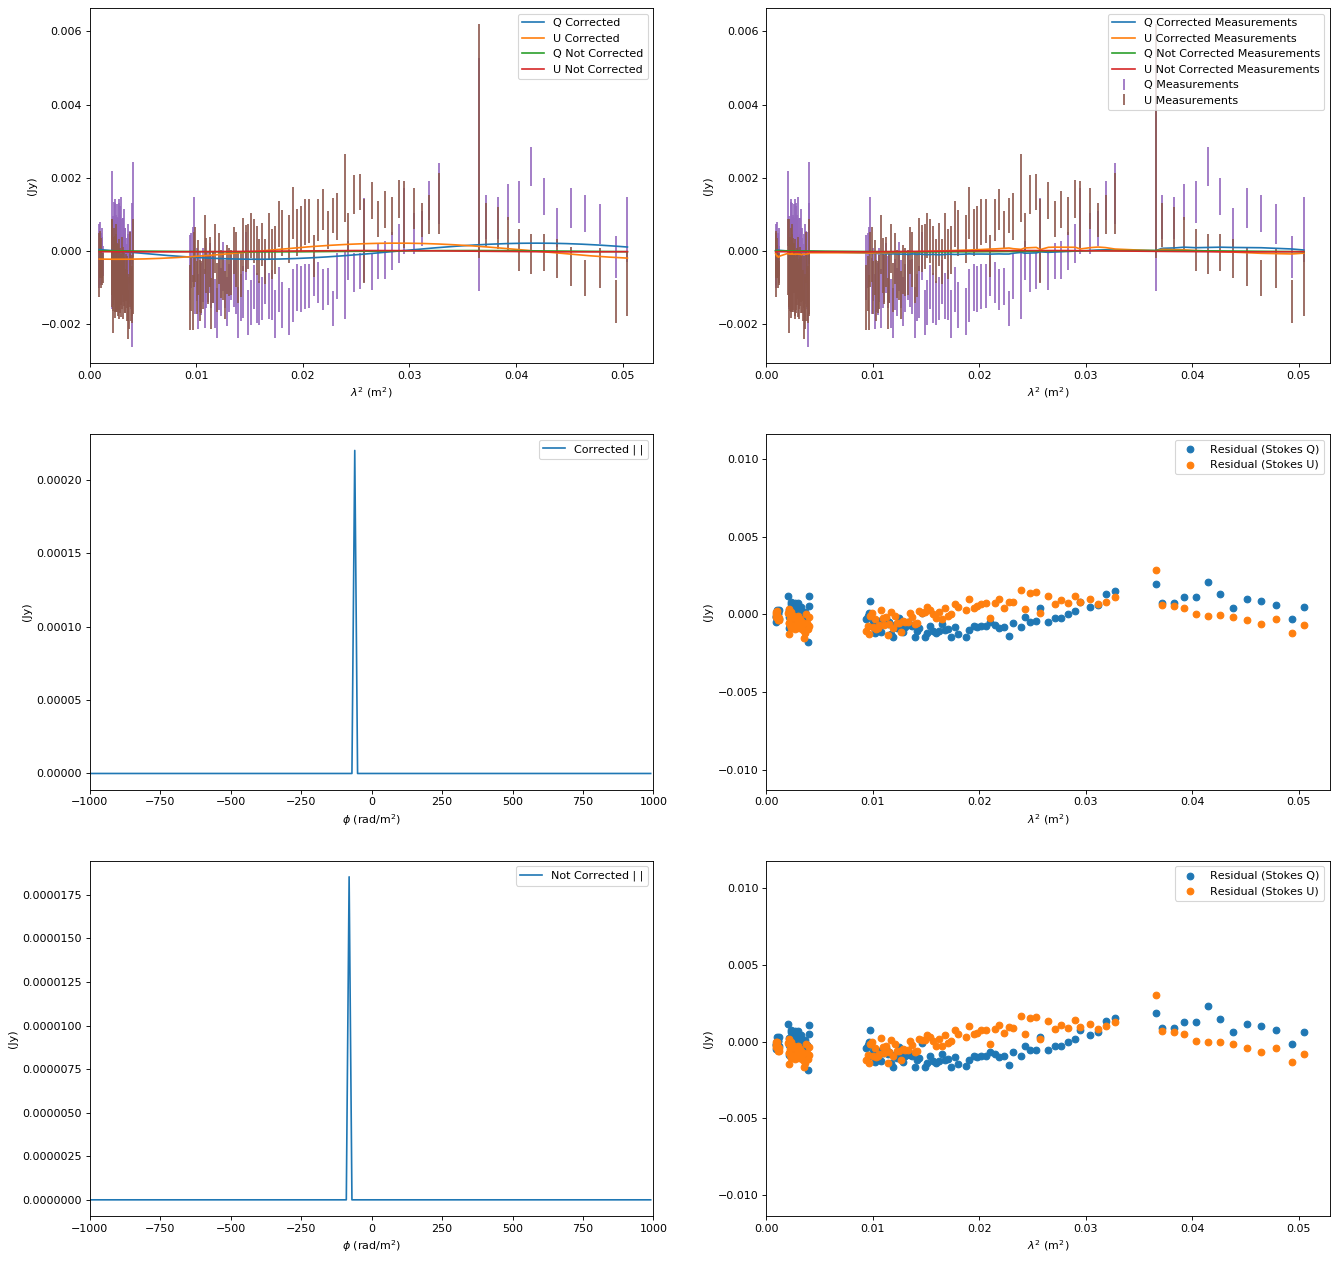

In [8]:
source = sources[2]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 2.
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1152'
2020-07-18 16:59:30,233 - Faraday Dreams - INFO - φ resolution 24.8197780303997 rad/m^2.
2020-07-18 16:59:30,234 - Faraday Dreams - INFO - φ max range is 8010.793958618504 rad/m^2.
2020-07-18 16:59:30,234 - Faraday Dreams - INFO - φ min range is 902.5653460998063 rad/m^2.
2020-07-18 16:59:30,248 - Optimus Primal - INFO - Starting Power method
2020-07-18 16:59:30,249 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 16:59:30,250 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 16:59:30,251 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-07-18 16:59:30,252 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-07-18 16:59:30,254 - Optimus Primal - INFO - [Power Method] iter = 41, tol = 0.0
2020-07-18 16:59:30,257 - Optimus Primal - INFO - [Power Method] iter = 51, tol = 0.0
2020-07-18 16:59:30,260 - Optimus Primal - INFO - [Power Method] iter = 61, tol = 0.0
2020-07-18 16:59:30,262 - Optimus Primal

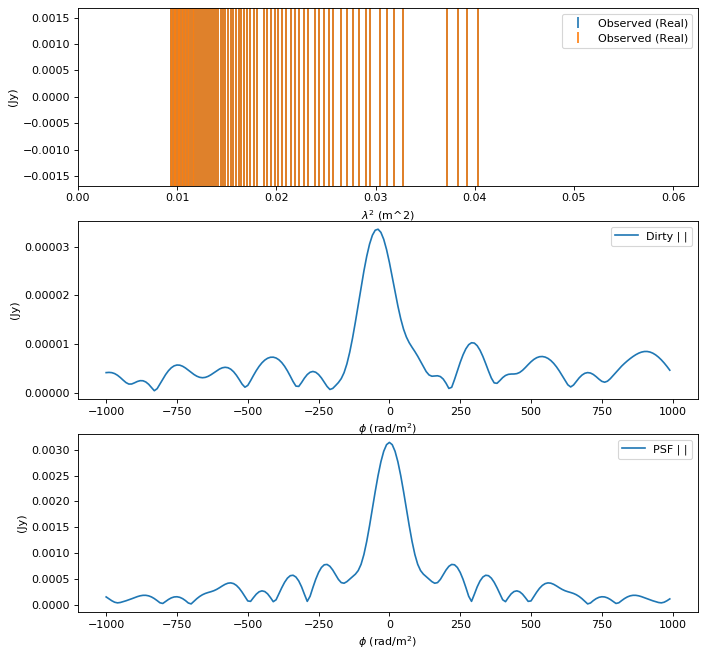

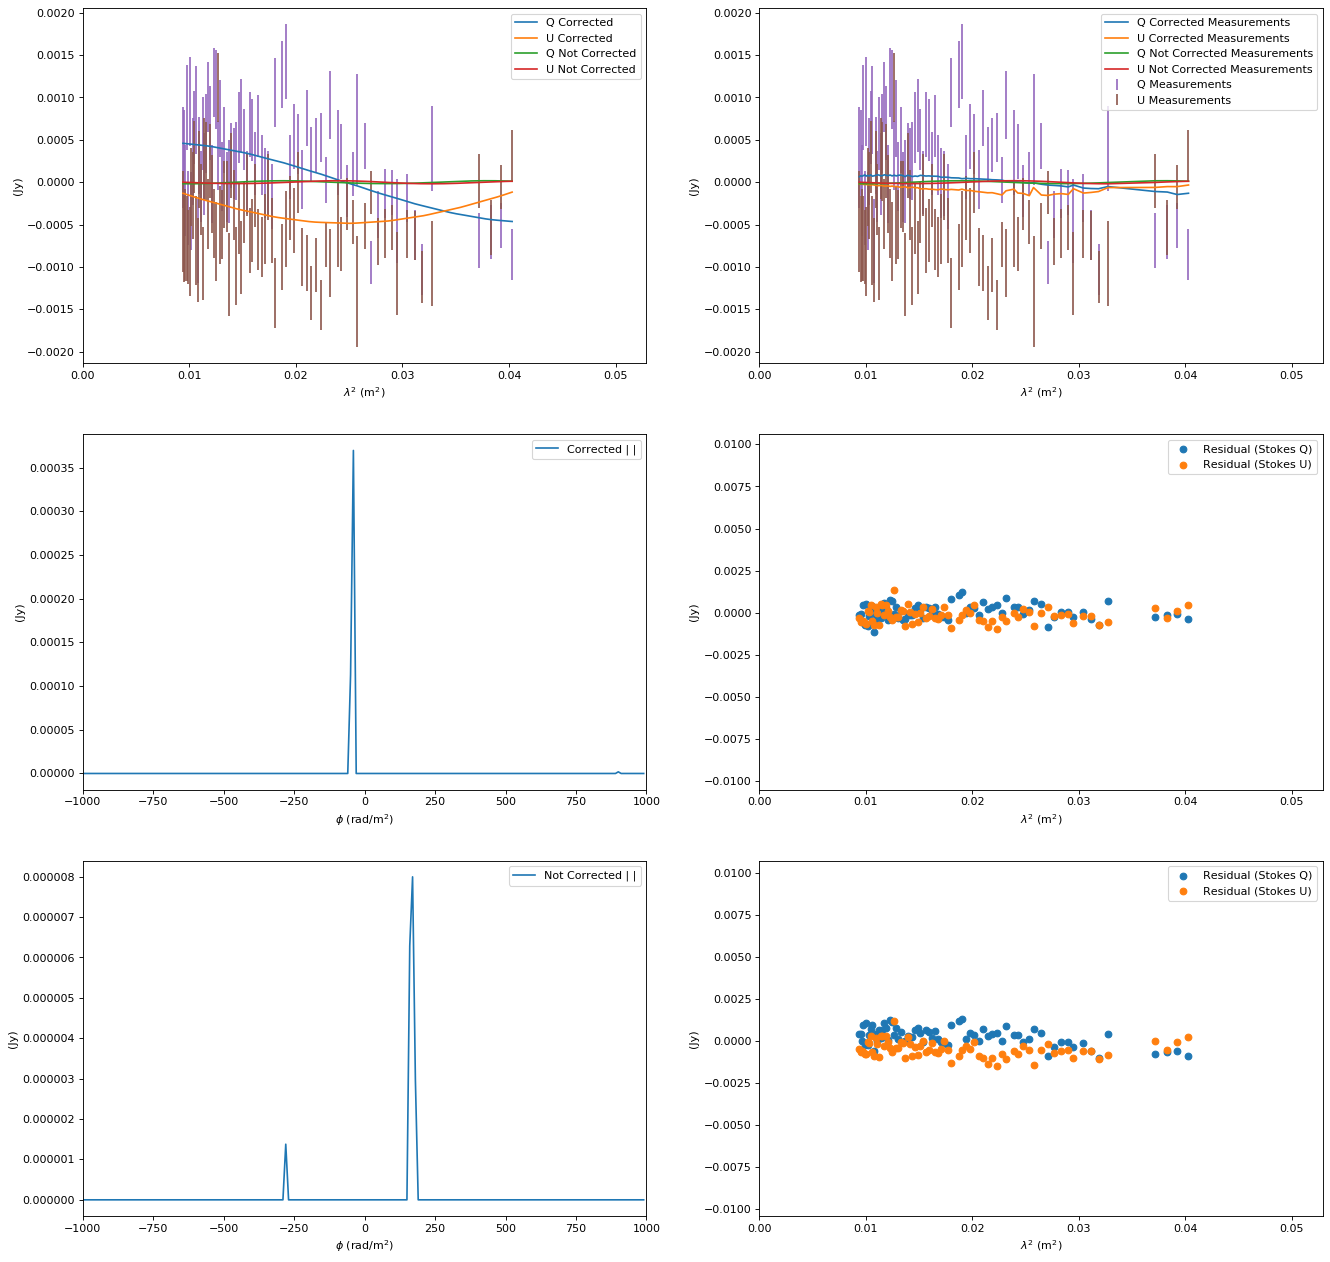

In [9]:
source = sources[3]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1435'
2020-07-18 16:59:35,868 - Faraday Dreams - INFO - φ resolution 21.027909528065774 rad/m^2.
2020-07-18 16:59:35,869 - Faraday Dreams - INFO - φ max range is 77148.28574856605 rad/m^2.
2020-07-18 16:59:35,869 - Faraday Dreams - INFO - φ min range is 703.8312784514167 rad/m^2.
2020-07-18 16:59:35,895 - Optimus Primal - INFO - Starting Power method
2020-07-18 16:59:35,896 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 16:59:35,897 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 1.6766314065664295e-05
2020-07-18 16:59:35,898 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 16:59:35,899 - Faraday Dreams - INFO - Using an estimated noise level of 0.0004493829619605094 (weighted image units, i.e. Jy/Beam)
2020-07-18 16:59:35,900 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 16:59:35,900 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2

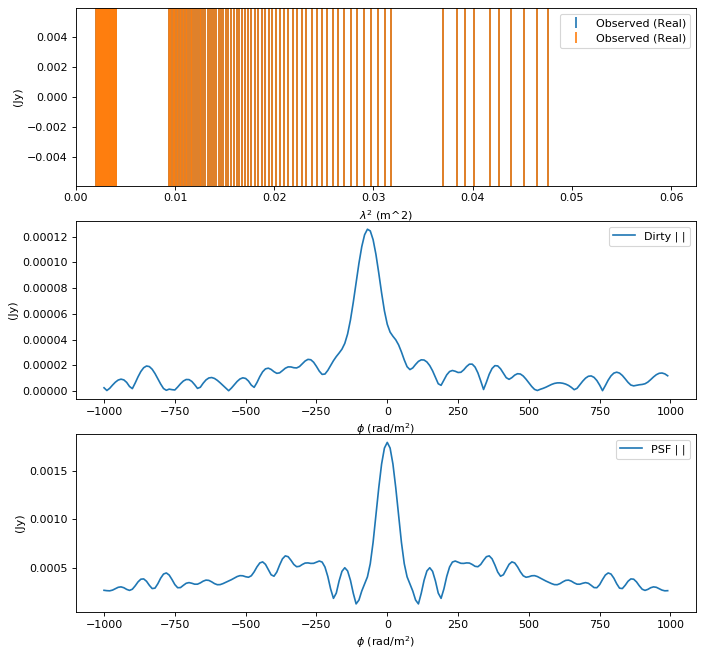

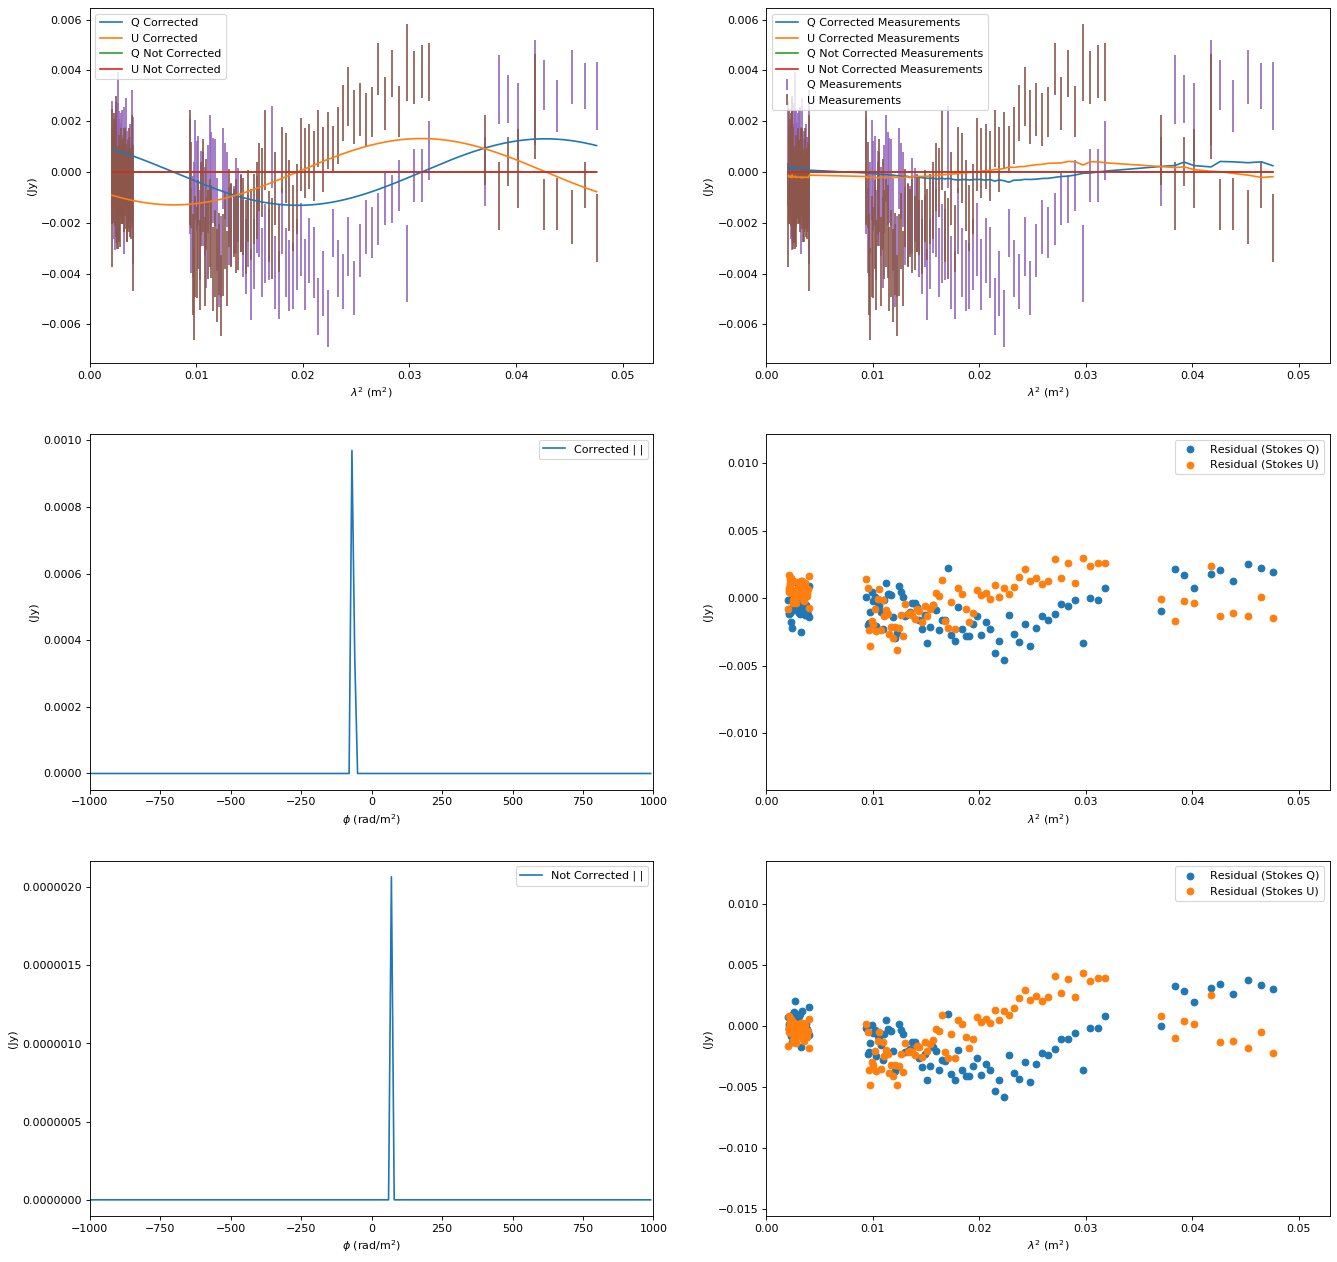

In [10]:
source = sources[4]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1466'
2020-07-18 16:59:42,933 - Faraday Dreams - INFO - φ resolution 21.028129387127045 rad/m^2.
2020-07-18 16:59:42,934 - Faraday Dreams - INFO - φ max range is 279264.1366969024 rad/m^2.
2020-07-18 16:59:42,934 - Faraday Dreams - INFO - φ min range is 703.8423177511336 rad/m^2.
2020-07-18 16:59:42,955 - Optimus Primal - INFO - Starting Power method
2020-07-18 16:59:42,957 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 16:59:42,960 - Optimus Primal - INFO - [Power Method] Converged with iter = 6, tol = 2.269881850736406e-05
2020-07-18 16:59:42,961 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 16:59:42,961 - Faraday Dreams - INFO - Using an estimated noise level of 0.0001487546687712893 (weighted image units, i.e. Jy/Beam)
2020-07-18 16:59:42,962 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 16:59:42,964 - Optimus Primal - INFO - Running Forward Backward Primal Dual
20

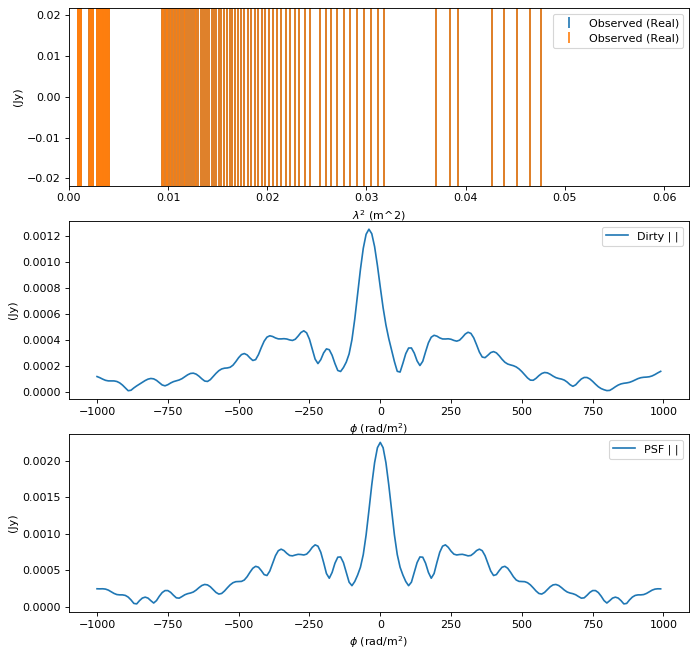

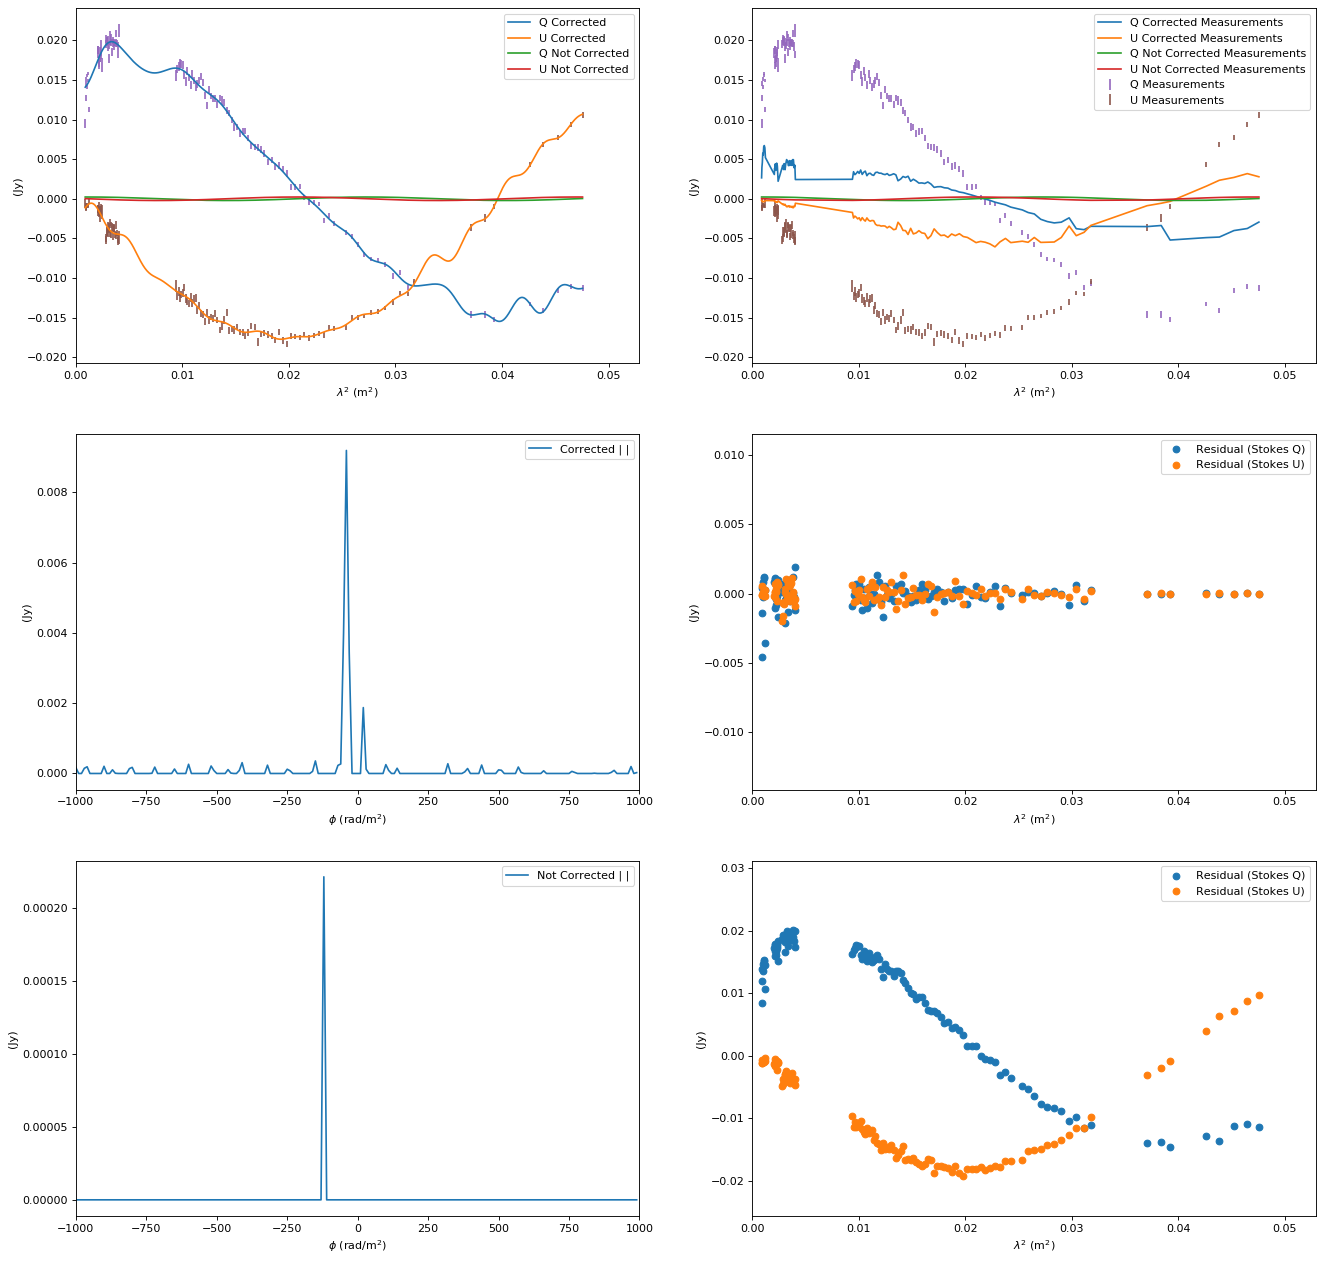

In [11]:
source = sources[5]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1573'
2020-07-18 16:59:55,206 - Faraday Dreams - INFO - φ resolution 20.88981460415885 rad/m^2.
2020-07-18 16:59:55,207 - Faraday Dreams - INFO - φ max range is 279287.80934454635 rad/m^2.
2020-07-18 16:59:55,208 - Faraday Dreams - INFO - φ min range is 696.9088370972838 rad/m^2.
2020-07-18 16:59:55,232 - Optimus Primal - INFO - Starting Power method
2020-07-18 16:59:55,232 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 16:59:55,233 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 4.4502347244563014e-05
2020-07-18 16:59:55,234 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 16:59:55,234 - Faraday Dreams - INFO - Using an estimated noise level of 0.00011901444668183103 (weighted image units, i.e. Jy/Beam)
2020-07-18 16:59:55,235 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 16:59:55,236 - Optimus Primal - INFO - Running Forward Backward Primal Dual


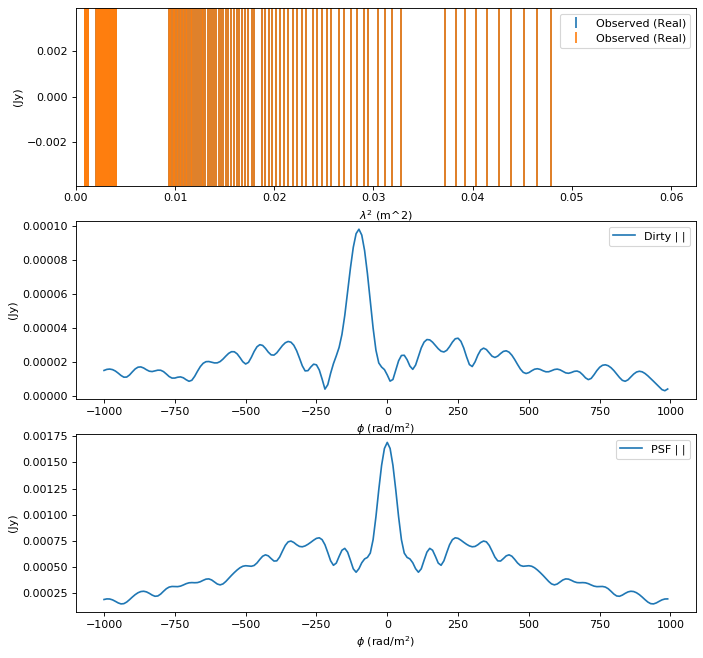

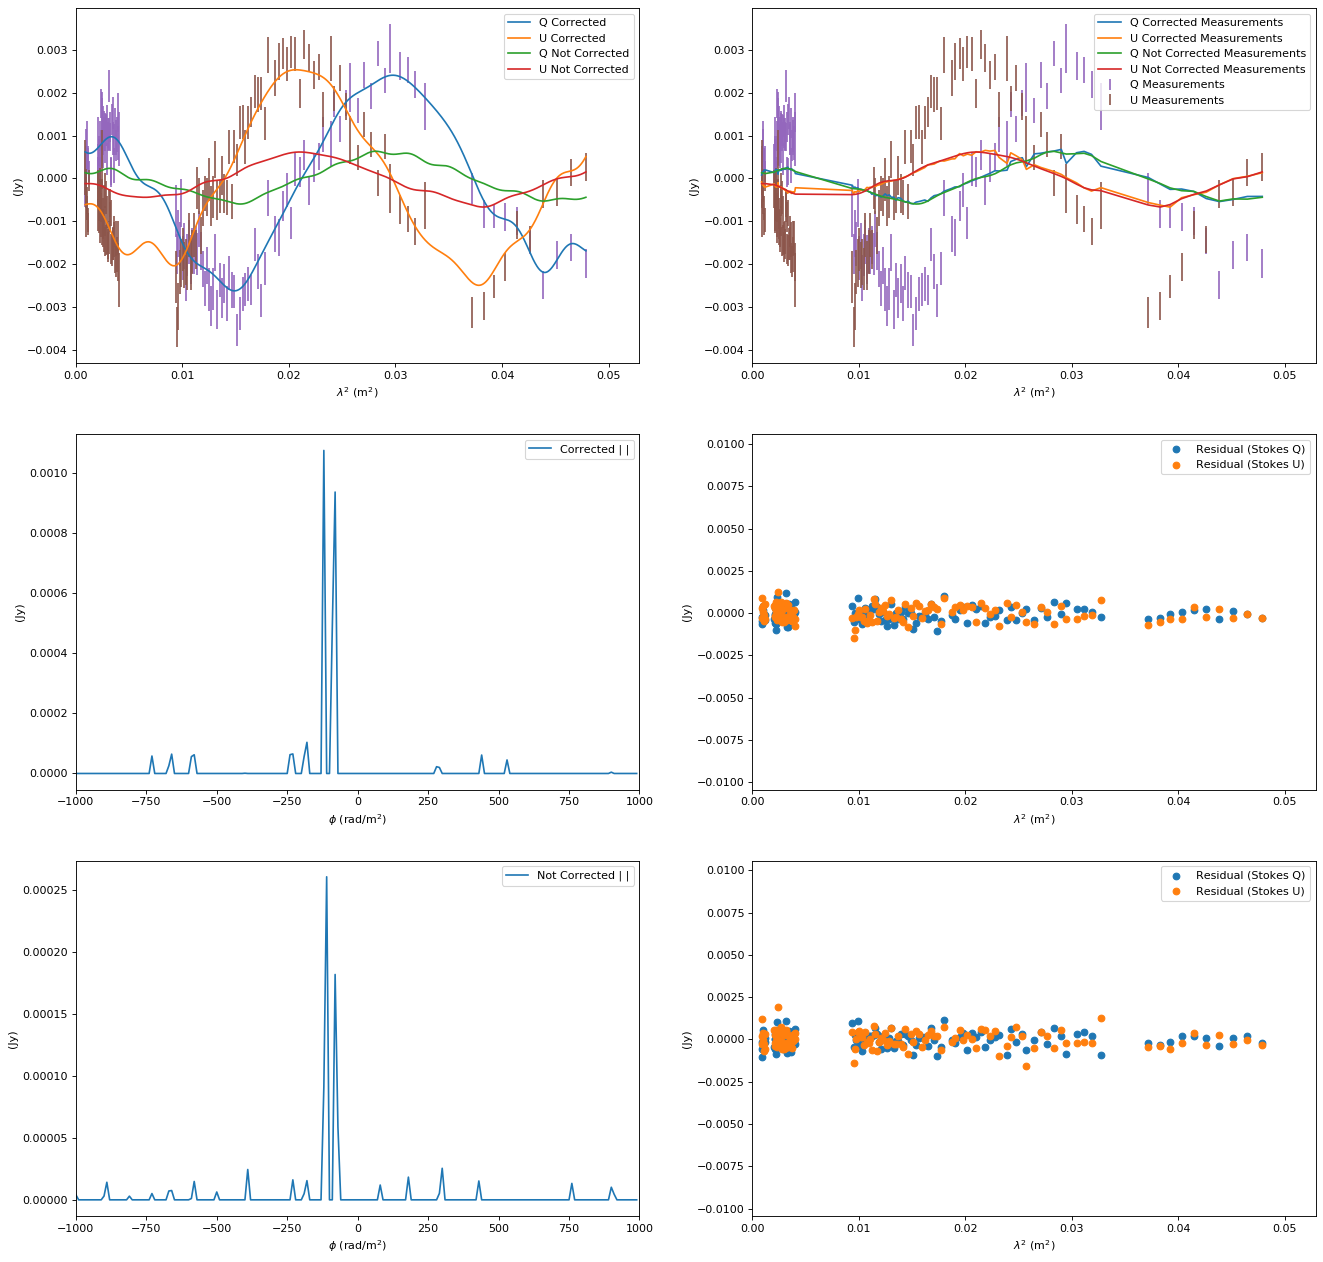

In [12]:
source = sources[6]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1636'
2020-07-18 17:00:11,870 - Faraday Dreams - INFO - φ resolution 21.02784671140223 rad/m^2.
2020-07-18 17:00:11,871 - Faraday Dreams - INFO - φ max range is 77147.20219561922 rad/m^2.
2020-07-18 17:00:11,872 - Faraday Dreams - INFO - φ min range is 703.8281243869868 rad/m^2.
2020-07-18 17:00:11,892 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:00:11,893 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:00:11,894 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 4.2518656229778825e-05
2020-07-18 17:00:11,895 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:00:11,896 - Faraday Dreams - INFO - Using an estimated noise level of 0.00011502040433697402 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:00:11,897 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:00:11,898 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2

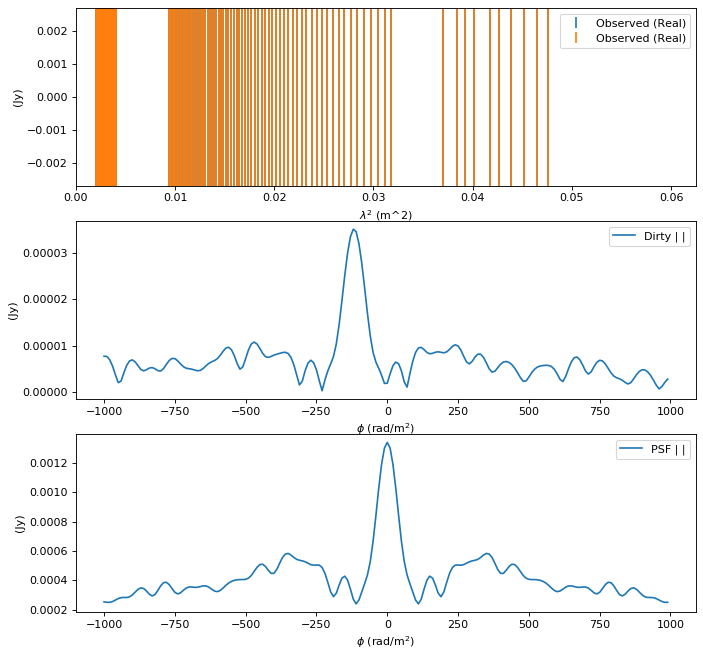

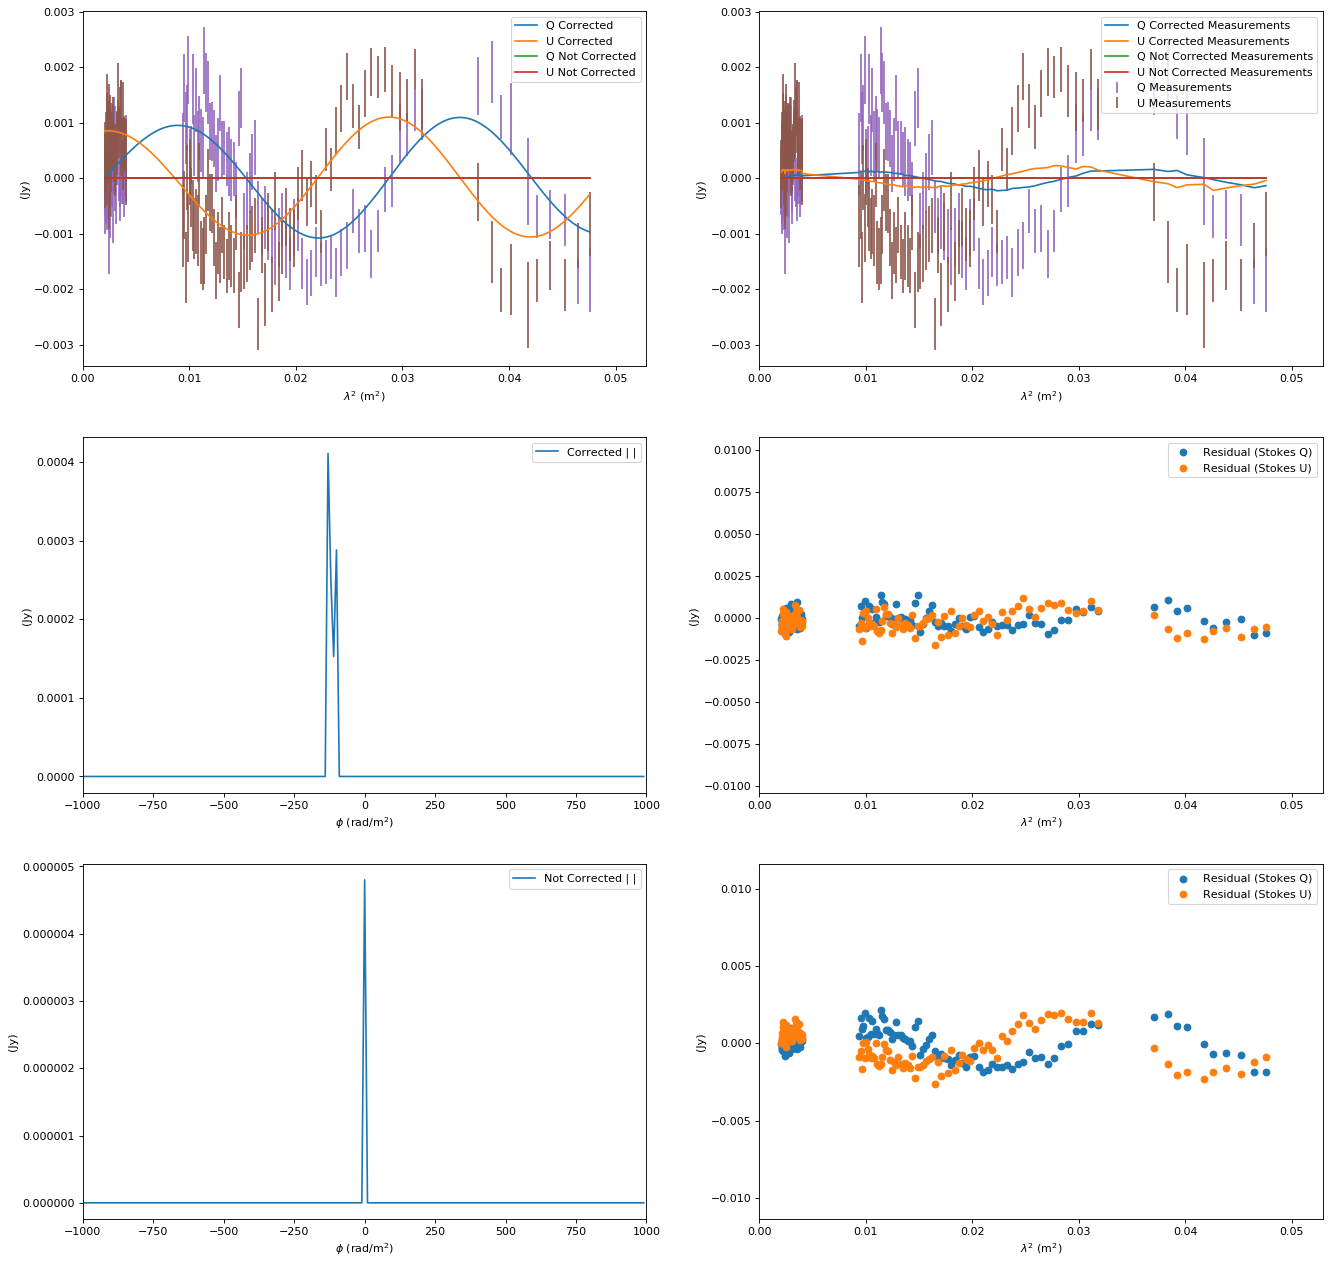

In [13]:
source = sources[7]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1.5
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1640'
2020-07-18 17:00:24,614 - Faraday Dreams - INFO - φ resolution 19.841563423731 rad/m^2.
2020-07-18 17:00:24,615 - Faraday Dreams - INFO - φ max range is 77167.71918720336 rad/m^2.
2020-07-18 17:00:24,615 - Faraday Dreams - INFO - φ min range is 645.1123423930359 rad/m^2.
2020-07-18 17:00:24,638 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:00:24,639 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:00:24,640 - Optimus Primal - INFO - [Power Method] Converged with iter = 8, tol = 6.658579116788579e-05
2020-07-18 17:00:24,641 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:00:24,641 - Faraday Dreams - INFO - Using an estimated noise level of 0.0004703365557361394 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:00:24,642 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:00:24,643 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-

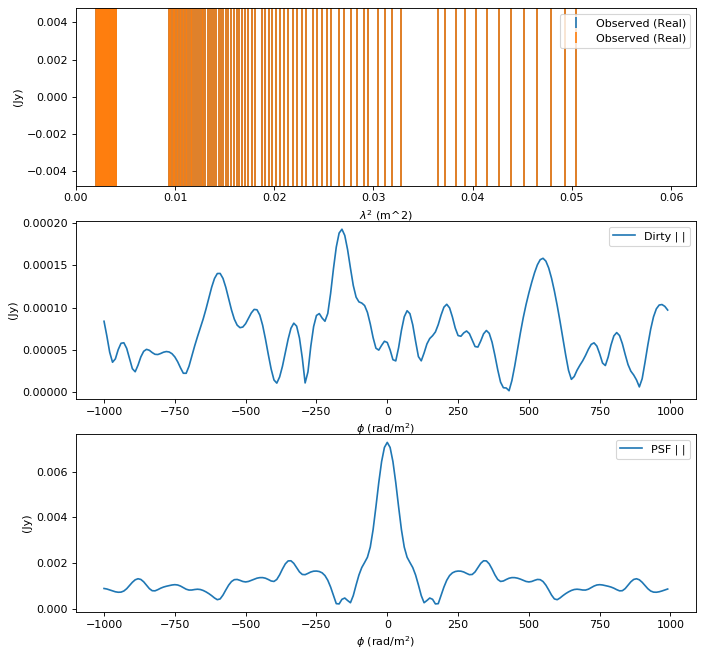

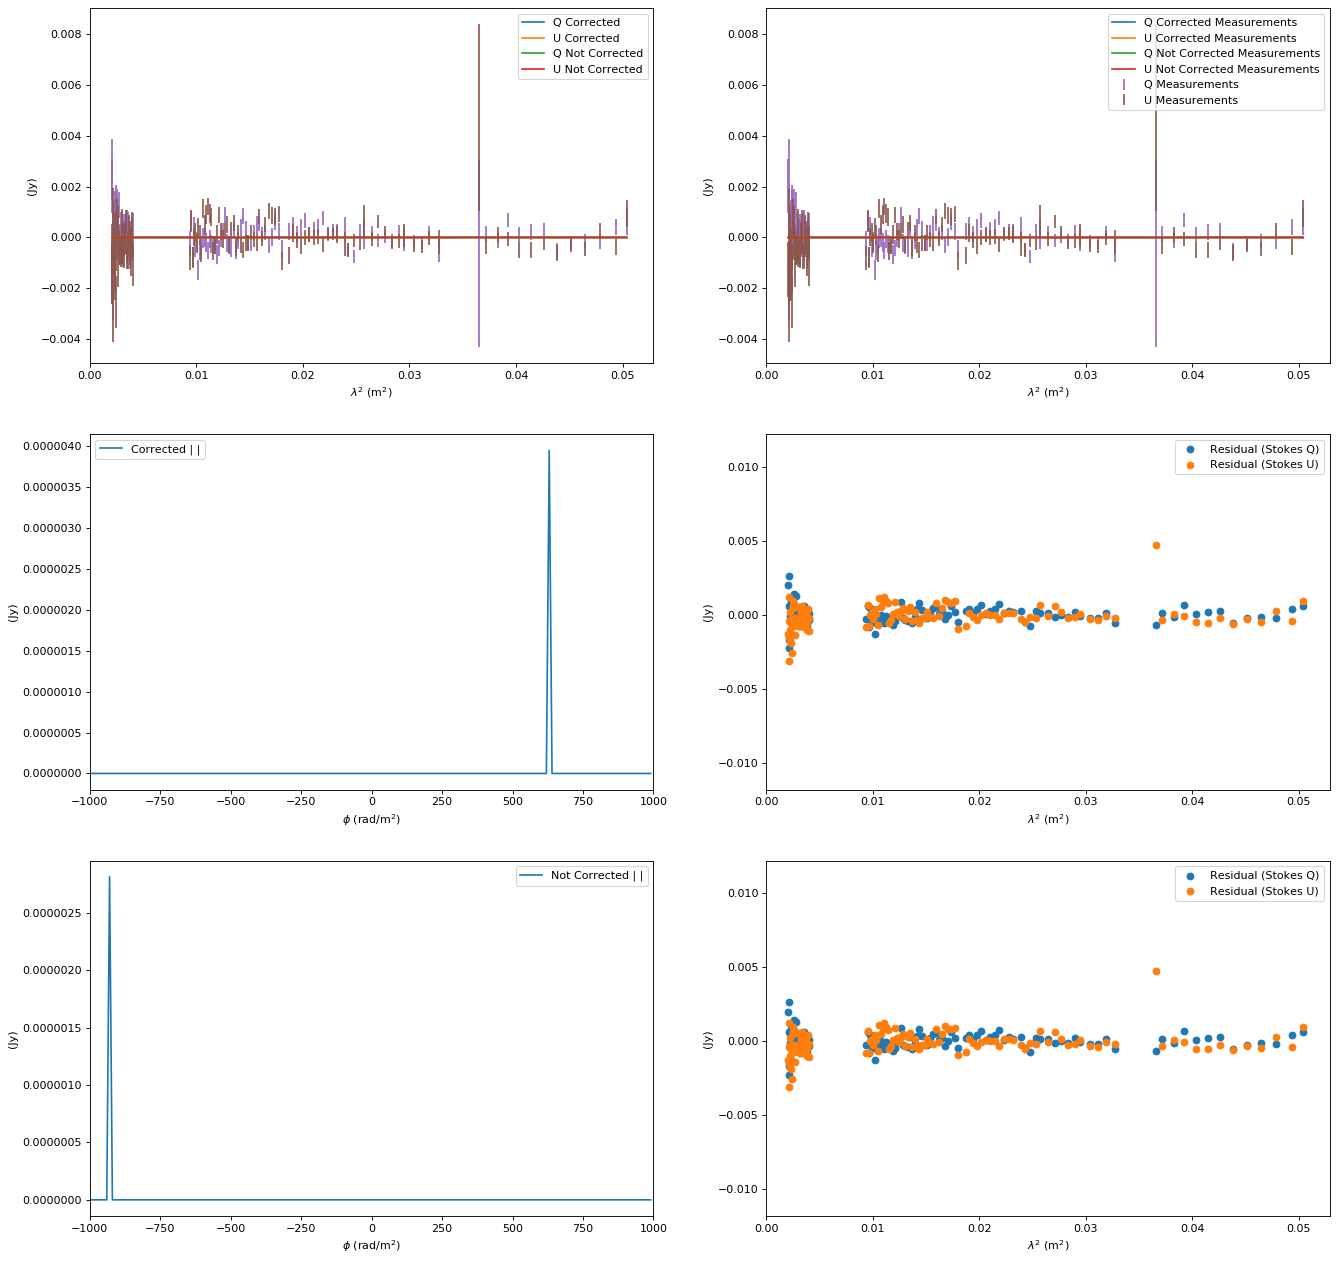

In [14]:
source = sources[8]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1748'
2020-07-18 17:00:26,046 - Faraday Dreams - INFO - φ resolution 23.465132280728092 rad/m^2.
2020-07-18 17:00:26,047 - Faraday Dreams - INFO - φ max range is 279268.99033219344 rad/m^2.
2020-07-18 17:00:26,047 - Faraday Dreams - INFO - φ min range is 829.6863701446905 rad/m^2.
2020-07-18 17:00:26,072 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:00:26,073 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:00:26,074 - Optimus Primal - INFO - [Power Method] Converged with iter = 9, tol = 5.536055412745782e-05
2020-07-18 17:00:26,075 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:00:26,075 - Faraday Dreams - INFO - Using an estimated noise level of 0.00012081971362931654 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:00:26,076 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:00:26,077 - Optimus Primal - INFO - Running Forward Backward Primal Dual


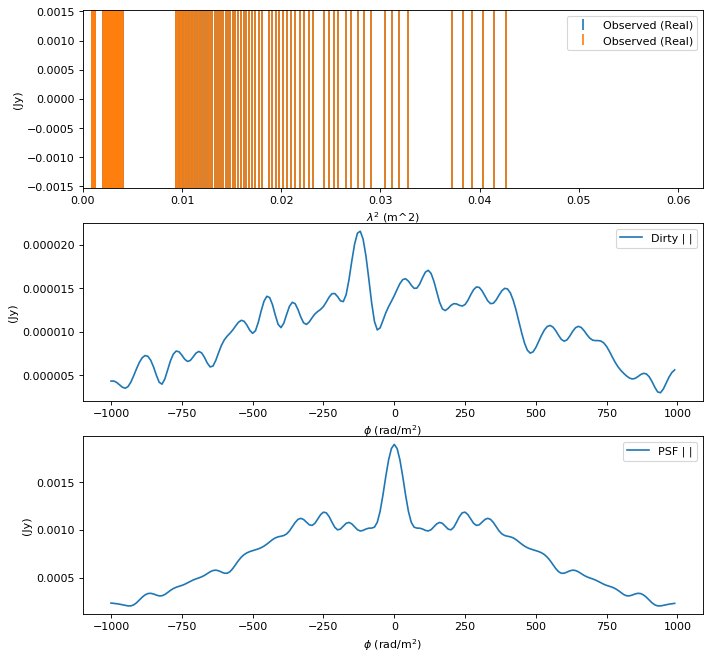

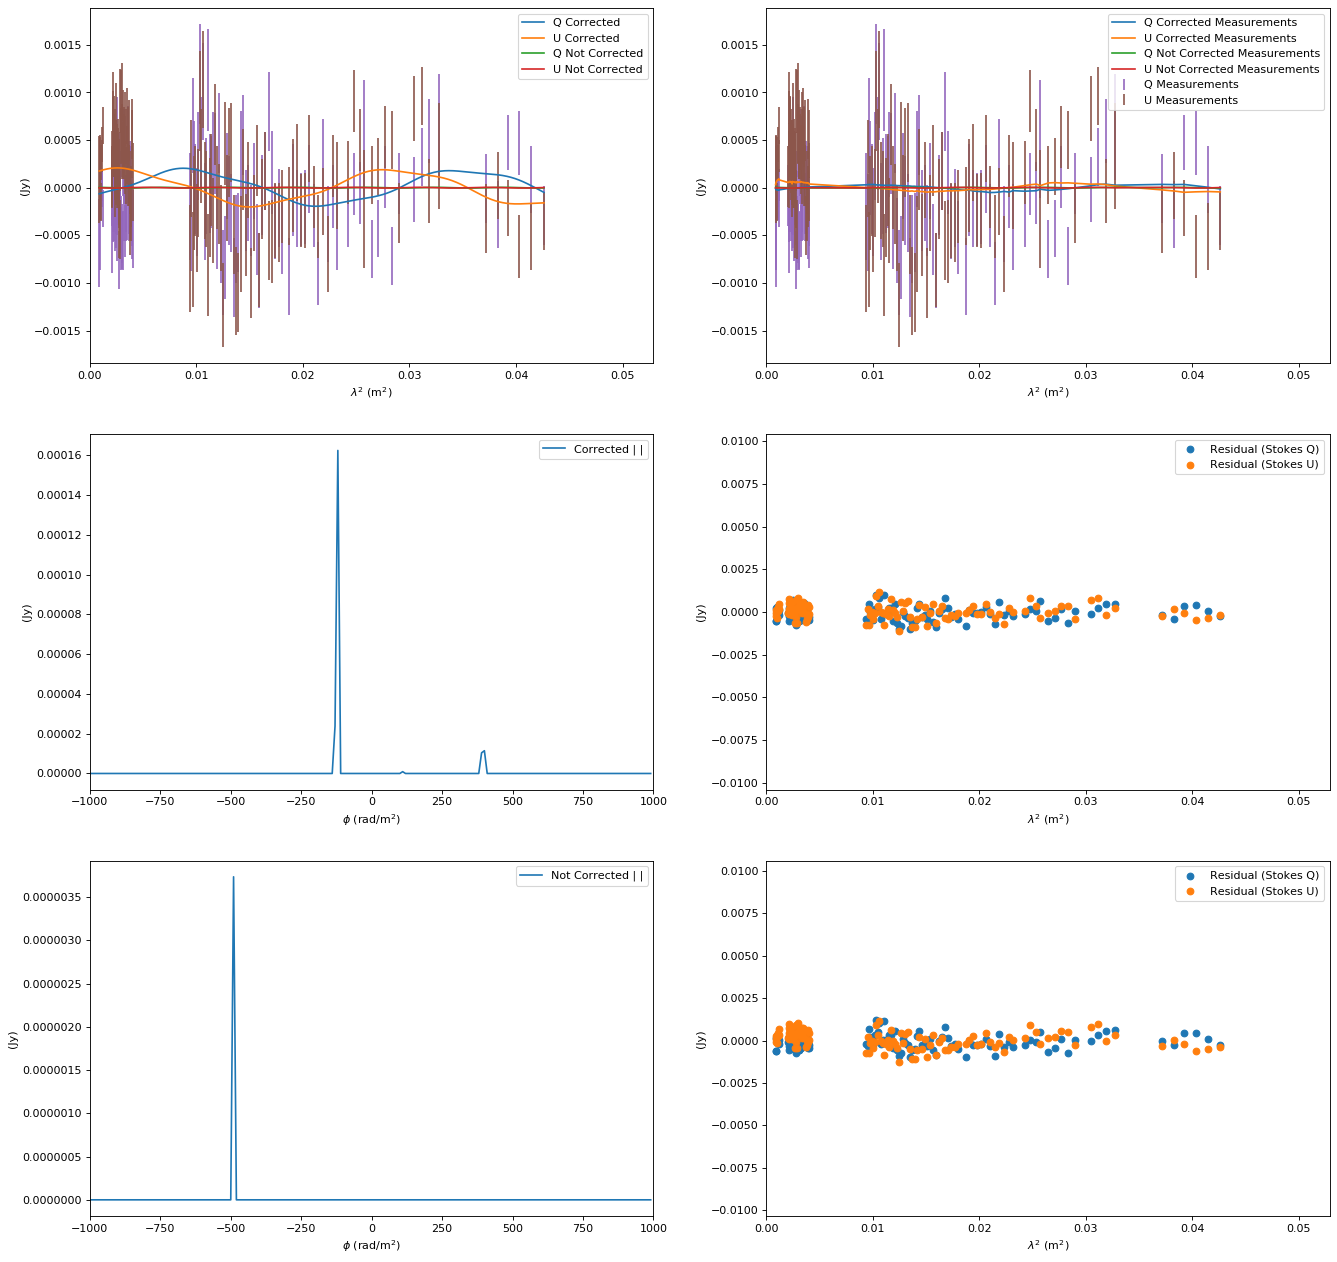

In [15]:
source = sources[9]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1764'
2020-07-18 17:00:29,235 - Faraday Dreams - INFO - φ resolution 21.027595445686337 rad/m^2.
2020-07-18 17:00:29,235 - Faraday Dreams - INFO - φ max range is 77147.92456312789 rad/m^2.
2020-07-18 17:00:29,236 - Faraday Dreams - INFO - φ min range is 703.815508223484 rad/m^2.
2020-07-18 17:00:29,258 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:00:29,259 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:00:29,260 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 2.3833464513841404e-05
2020-07-18 17:00:29,261 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:00:29,262 - Faraday Dreams - INFO - Using an estimated noise level of 0.0006275892374105752 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:00:29,262 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:00:29,263 - Optimus Primal - INFO - Running Forward Backward Primal Dual
20

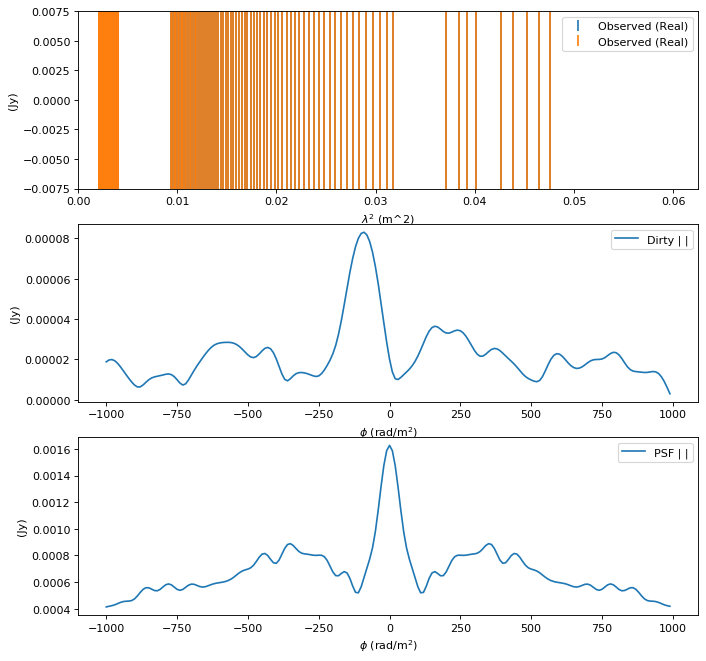

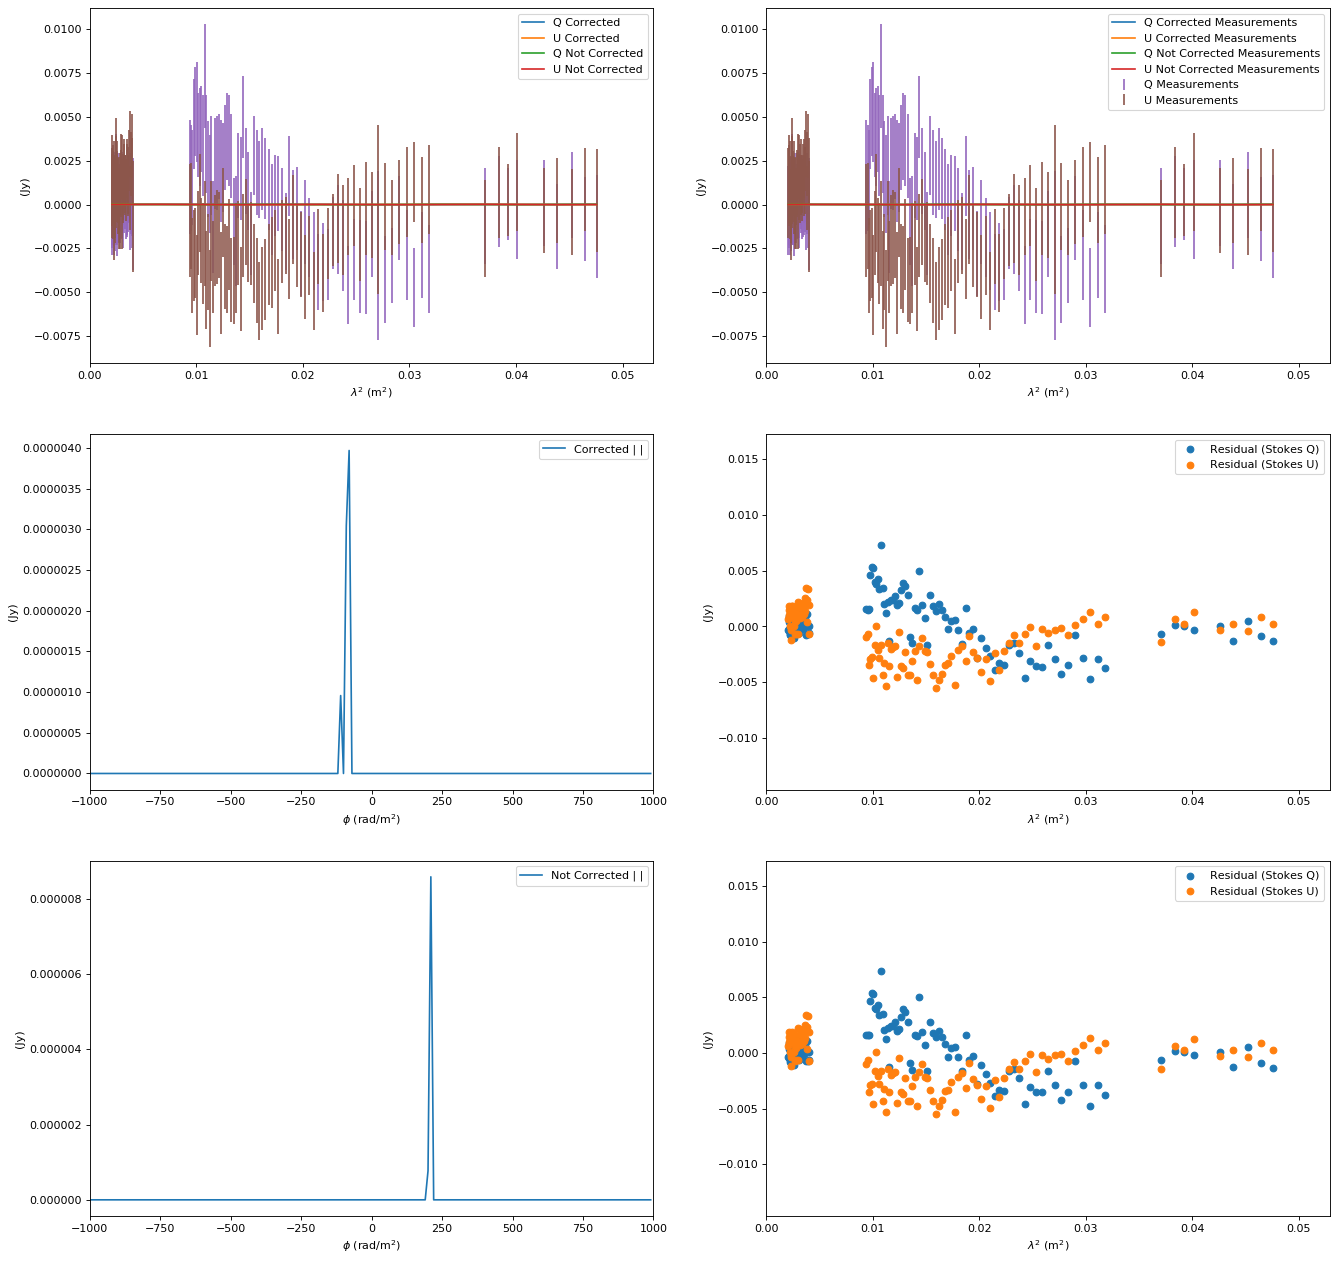

In [16]:
source = sources[10]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1827'
2020-07-18 17:00:30,655 - Faraday Dreams - INFO - φ resolution 21.027878119722274 rad/m^2.
2020-07-18 17:00:30,656 - Faraday Dreams - INFO - φ max range is 279329.28227902803 rad/m^2.
2020-07-18 17:00:30,657 - Faraday Dreams - INFO - φ min range is 703.8297014180228 rad/m^2.
2020-07-18 17:00:30,680 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:00:30,681 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:00:30,683 - Optimus Primal - INFO - [Power Method] Converged with iter = 10, tol = 4.1784513377830154e-05
2020-07-18 17:00:30,684 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:00:30,684 - Faraday Dreams - INFO - Using an estimated noise level of 0.00039355174521915615 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:00:30,685 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:00:30,686 - Optimus Primal - INFO - Running Forward Backward Primal Dua

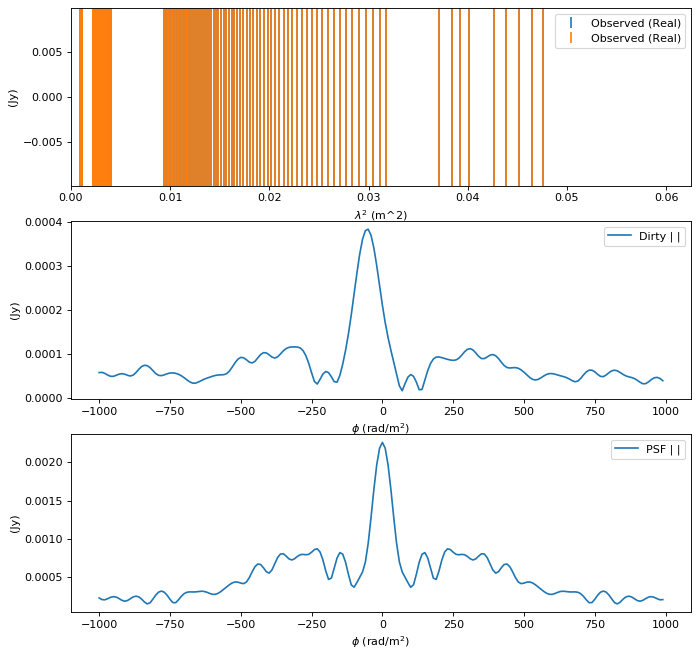

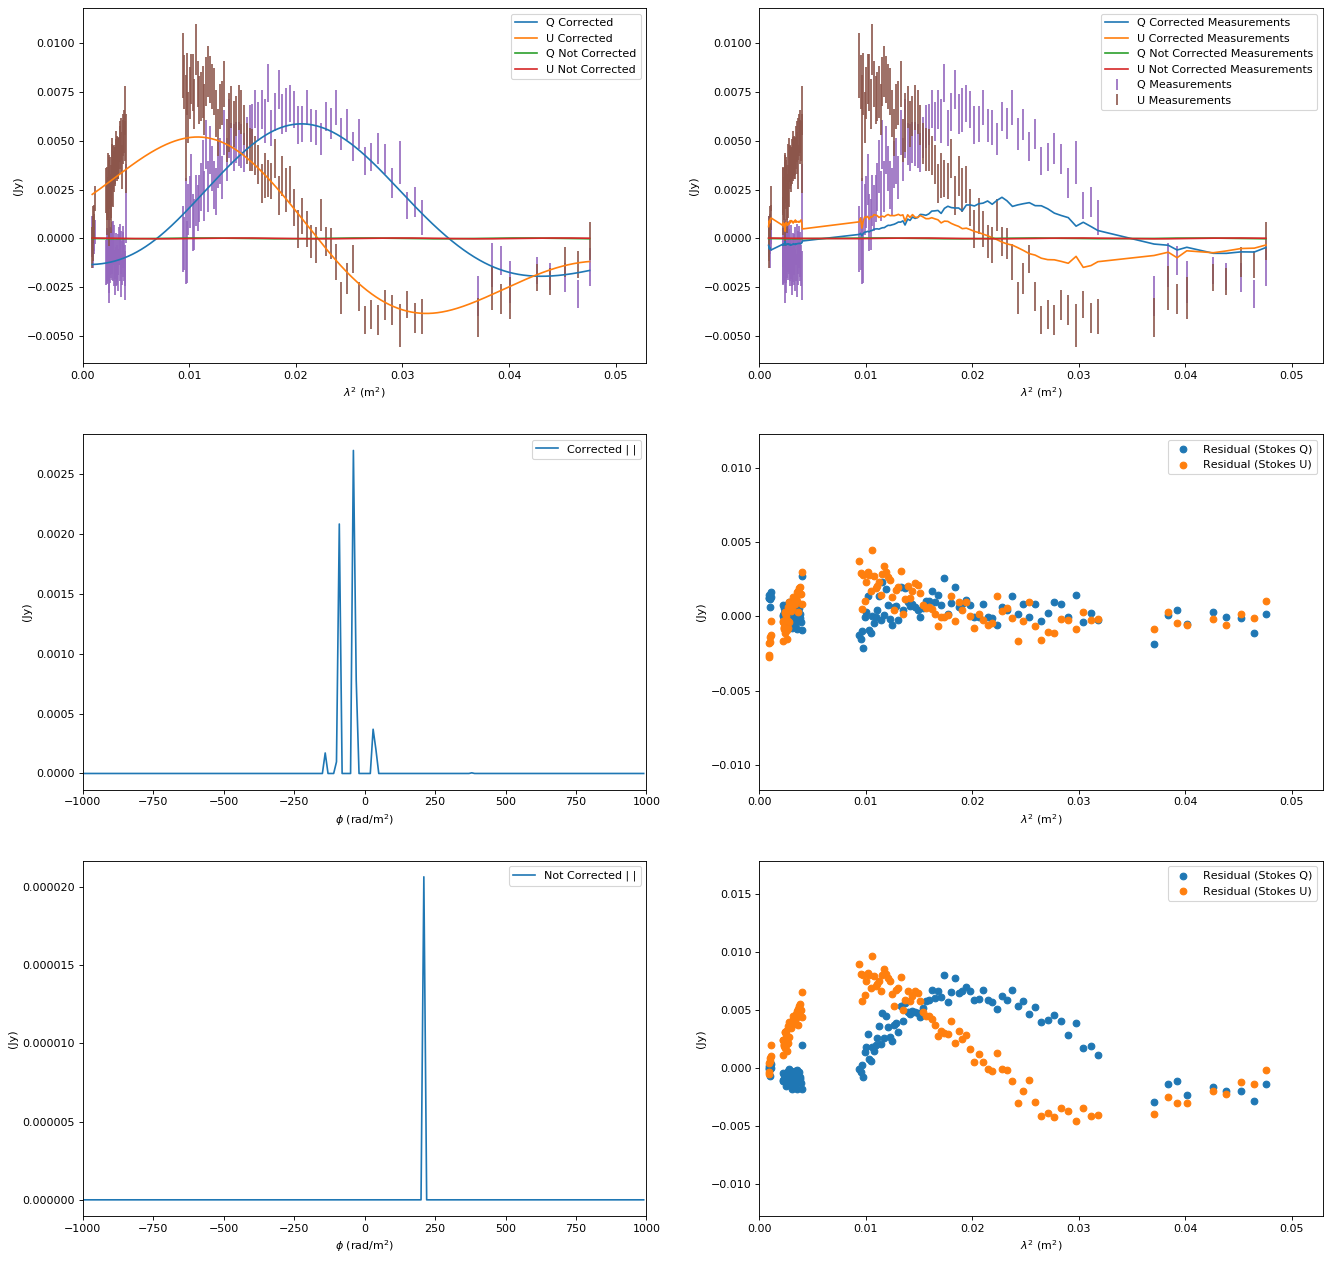

In [17]:
source = sources[11]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

2020-07-18 17:00:34,765 - Faraday Dreams - INFO - φ resolution 20.26791149325624 rad/m^2.
2020-07-18 17:00:34,766 - Faraday Dreams - INFO - φ max range is 77165.94909210865 rad/m^2.
2020-07-18 17:00:34,766 - Faraday Dreams - INFO - φ min range is 666.0181973331584 rad/m^2.
2020-07-18 17:00:34,788 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:00:34,789 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:00:34,791 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 3.426857400255029e-05
2020-07-18 17:00:34,792 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:00:34,792 - Faraday Dreams - INFO - Using an estimated noise level of 0.00012987047375645489 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:00:34,793 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:00:34,794 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-07-18 17:00

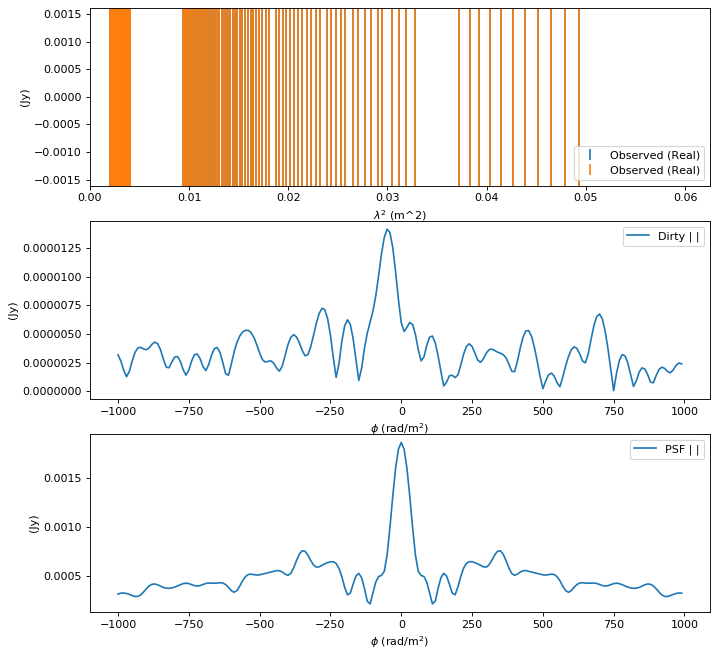

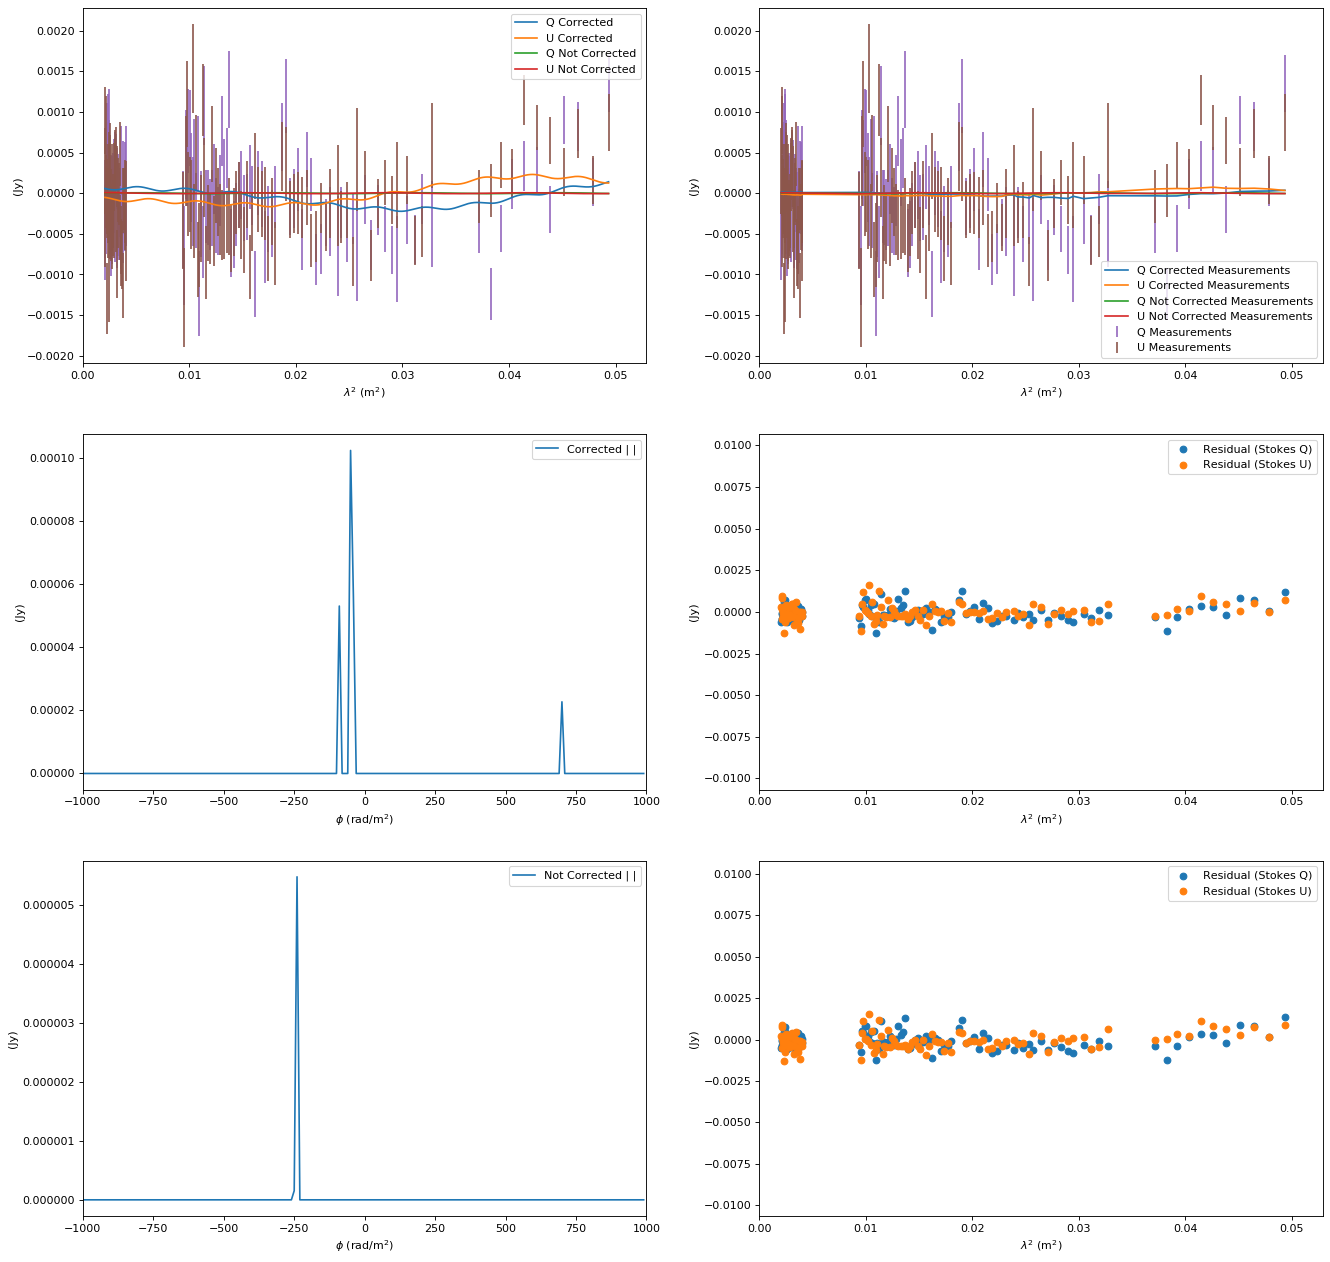

In [18]:
source = sources[12]
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_c1972'
2020-07-18 17:00:36,937 - Faraday Dreams - INFO - φ resolution 20.318914697363482 rad/m^2.
2020-07-18 17:00:36,938 - Faraday Dreams - INFO - φ max range is 279256.13257910084 rad/m^2.
2020-07-18 17:00:36,938 - Faraday Dreams - INFO - φ min range is 668.5339756224641 rad/m^2.
2020-07-18 17:00:36,956 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:00:36,957 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:00:36,959 - Optimus Primal - INFO - [Power Method] Converged with iter = 8, tol = 6.18135081063648e-05
2020-07-18 17:00:36,960 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:00:36,961 - Faraday Dreams - INFO - Using an estimated noise level of 0.00012695739860646427 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:00:36,962 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:00:36,962 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2

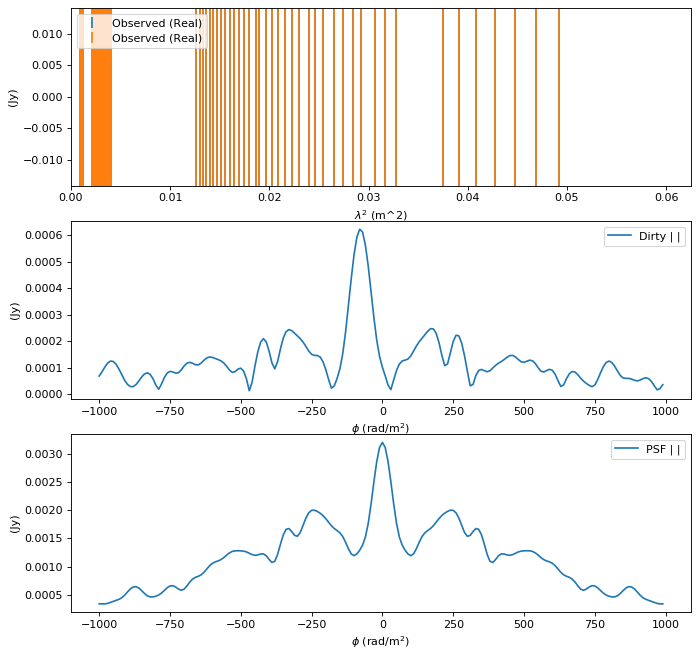

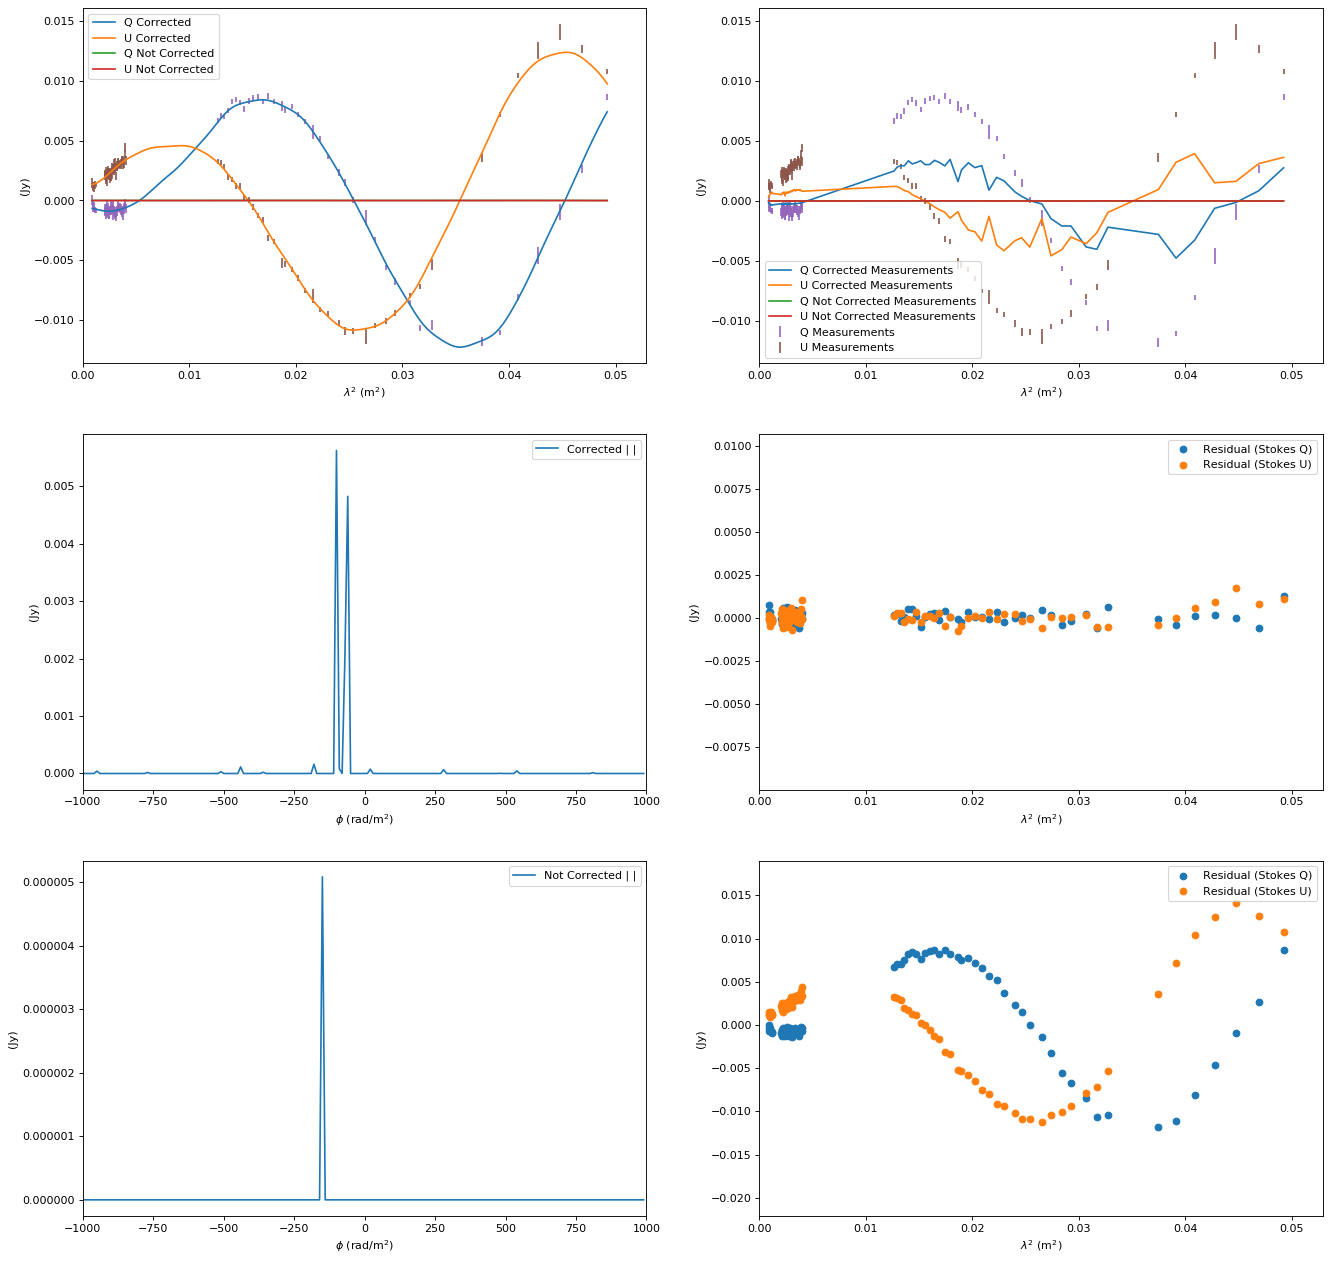

In [19]:
source = sources[13]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1014'
2020-07-18 23:52:40,269 - Faraday Dreams - INFO - φ resolution 21.5198761666823 rad/m^2.
2020-07-18 23:52:40,270 - Faraday Dreams - INFO - φ max range is 8009.4933987271115 rad/m^2.
2020-07-18 23:52:40,270 - Faraday Dreams - INFO - φ min range is 728.6771865192311 rad/m^2.
2020-07-18 23:52:40,290 - Optimus Primal - INFO - Starting Power method
2020-07-18 23:52:40,291 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 23:52:40,293 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 23:52:40,295 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-07-18 23:52:40,296 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-07-18 23:52:40,298 - Optimus Primal - INFO - [Power Method] iter = 41, tol = 0.0
2020-07-18 23:52:40,300 - Optimus Primal - INFO - [Power Method] iter = 51, tol = 0.0
2020-07-18 23:52:40,302 - Optimus Primal - INFO - [Power Method] iter = 61, tol = 0.0
2020-07-18 23:52:40,303 - Optimus Prima

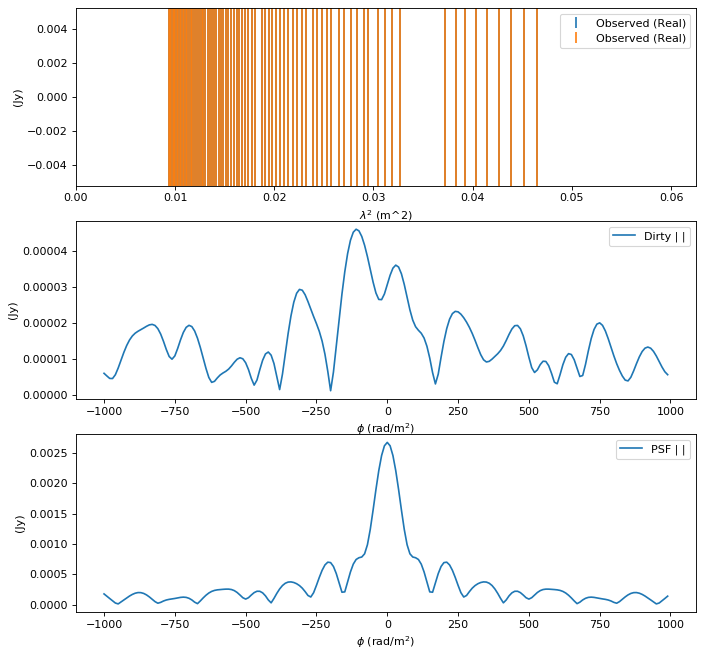

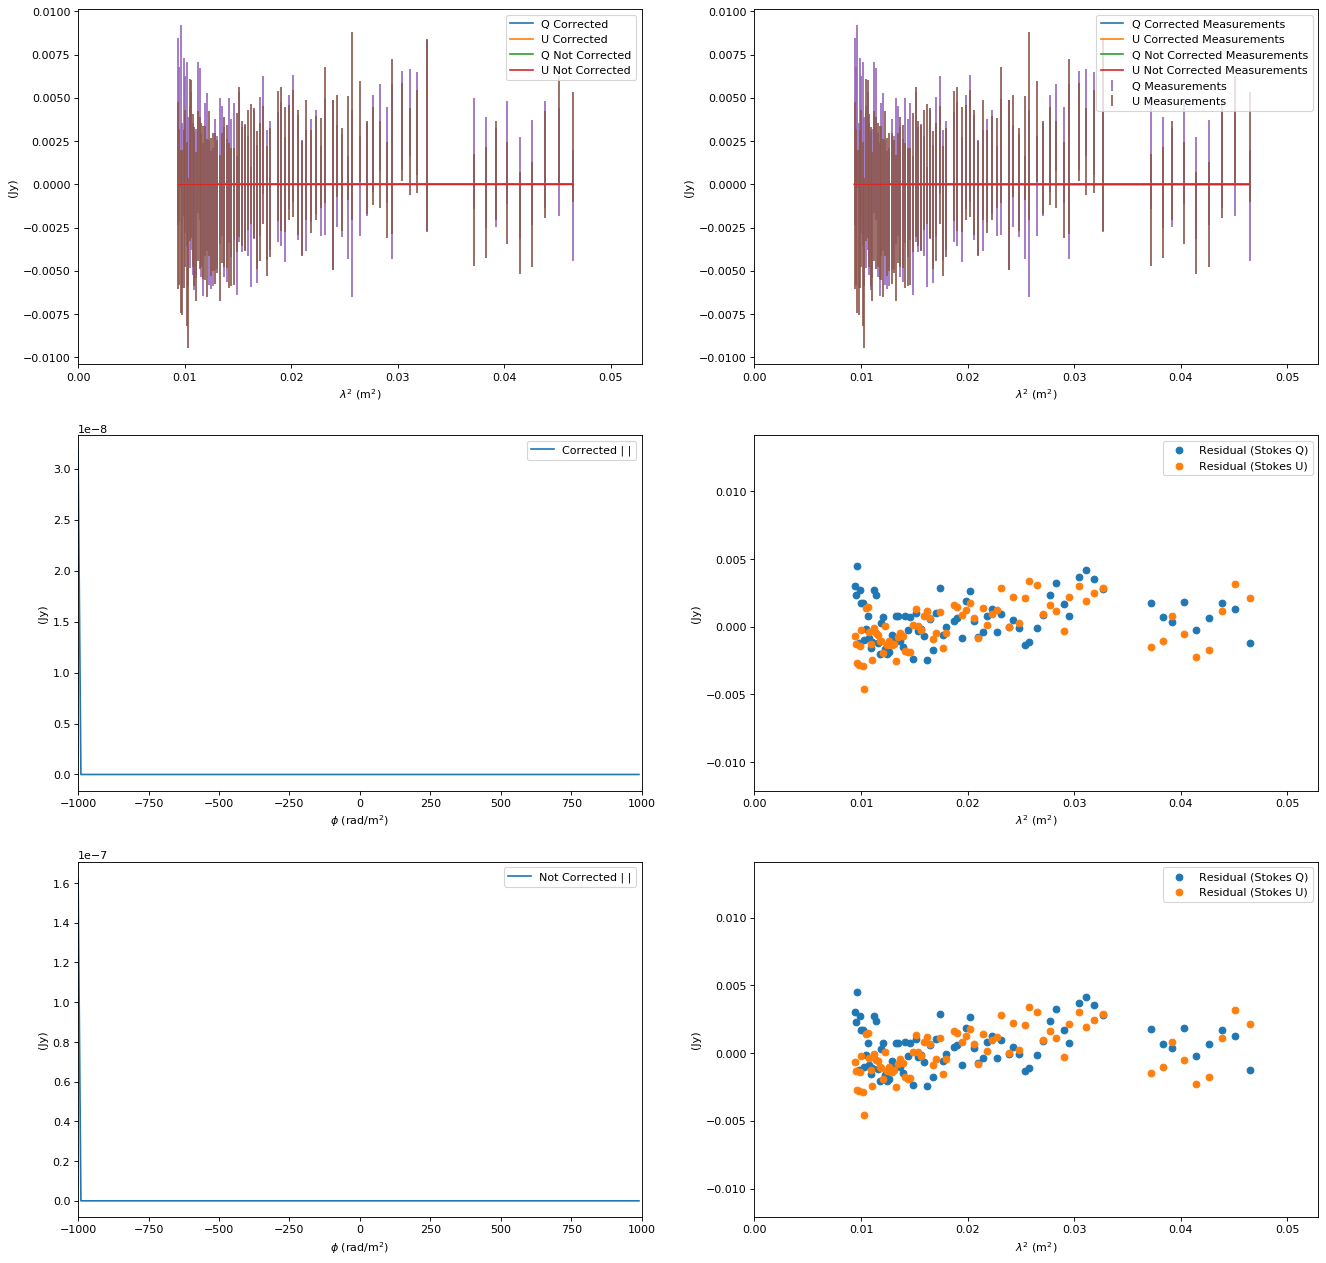

In [56]:
source = sources[14]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 2
rm_max = 1000
beta = 1e-4
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1031'
2020-07-19 00:20:25,182 - Faraday Dreams - INFO - φ resolution 19.82179819254316 rad/m^2.
2020-07-19 00:20:25,183 - Faraday Dreams - INFO - φ max range is 77167.2856920226 rad/m^2.
2020-07-19 00:20:25,183 - Faraday Dreams - INFO - φ min range is 644.1485607464031 rad/m^2.
2020-07-19 00:20:25,216 - Optimus Primal - INFO - Starting Power method
2020-07-19 00:20:25,217 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-19 00:20:25,218 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 2.890799354951818e-05
2020-07-19 00:20:25,219 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-19 00:20:25,220 - Faraday Dreams - INFO - Using an estimated noise level of 0.00015556170546915382 (weighted image units, i.e. Jy/Beam)
2020-07-19 00:20:25,221 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-19 00:20:25,222 - Optimus Primal - INFO - Running Forward Backward Primal Dual
202

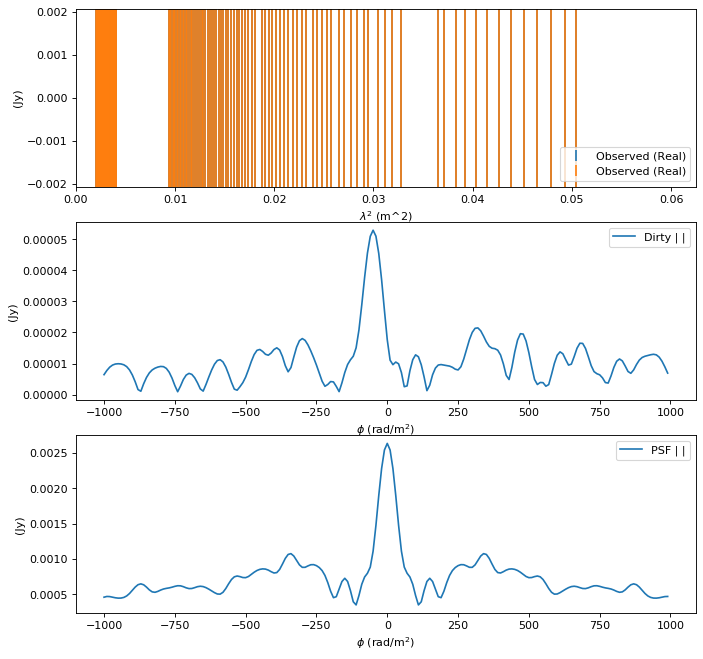

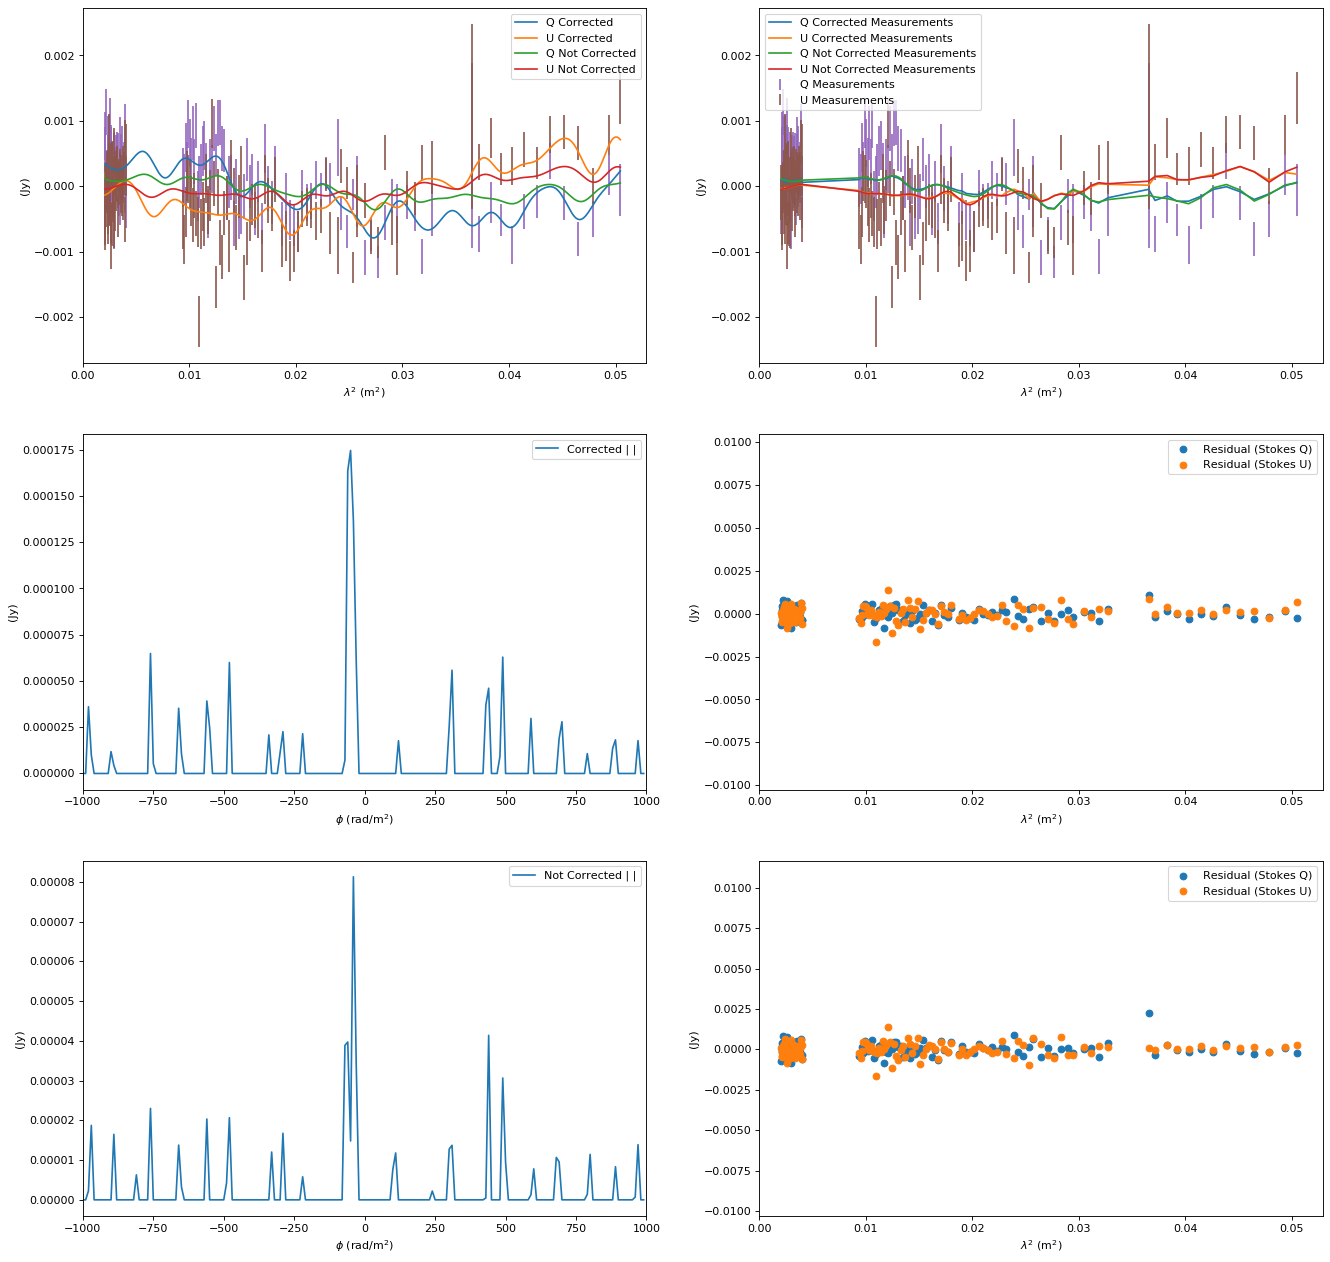

In [68]:
source = sources[15]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-4
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1290'
2020-07-19 00:22:24,871 - Faraday Dreams - INFO - φ resolution 21.028097978619343 rad/m^2.
2020-07-19 00:22:24,872 - Faraday Dreams - INFO - φ max range is 279370.84449167305 rad/m^2.
2020-07-19 00:22:24,873 - Faraday Dreams - INFO - φ min range is 703.8407407012481 rad/m^2.
2020-07-19 00:22:24,904 - Optimus Primal - INFO - Starting Power method
2020-07-19 00:22:24,905 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-19 00:22:24,906 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-19 00:22:24,907 - Optimus Primal - INFO - [Power Method] Converged with iter = 15, tol = 5.5675052549654466e-05
2020-07-19 00:22:24,908 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-19 00:22:24,909 - Faraday Dreams - INFO - Using an estimated noise level of 0.00010639943066053093 (weighted image units, i.e. Jy/Beam)
2020-07-19 00:22:24,909 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization

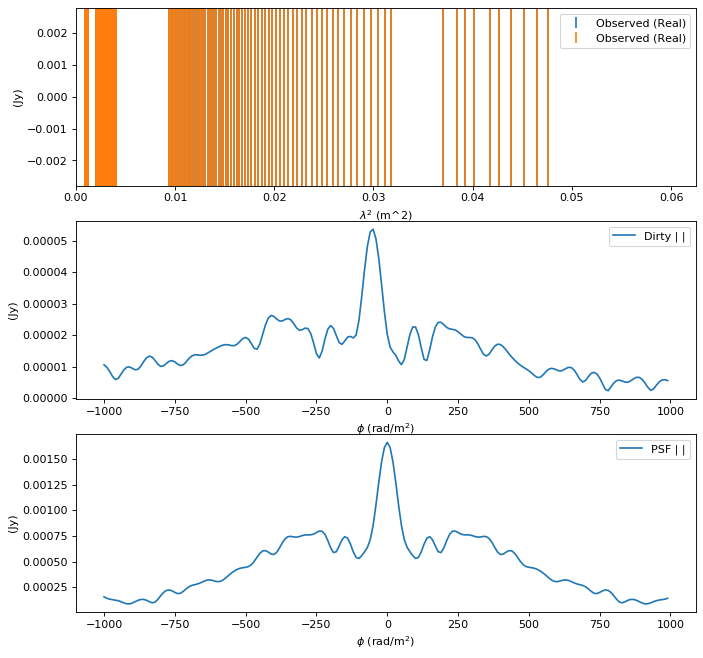

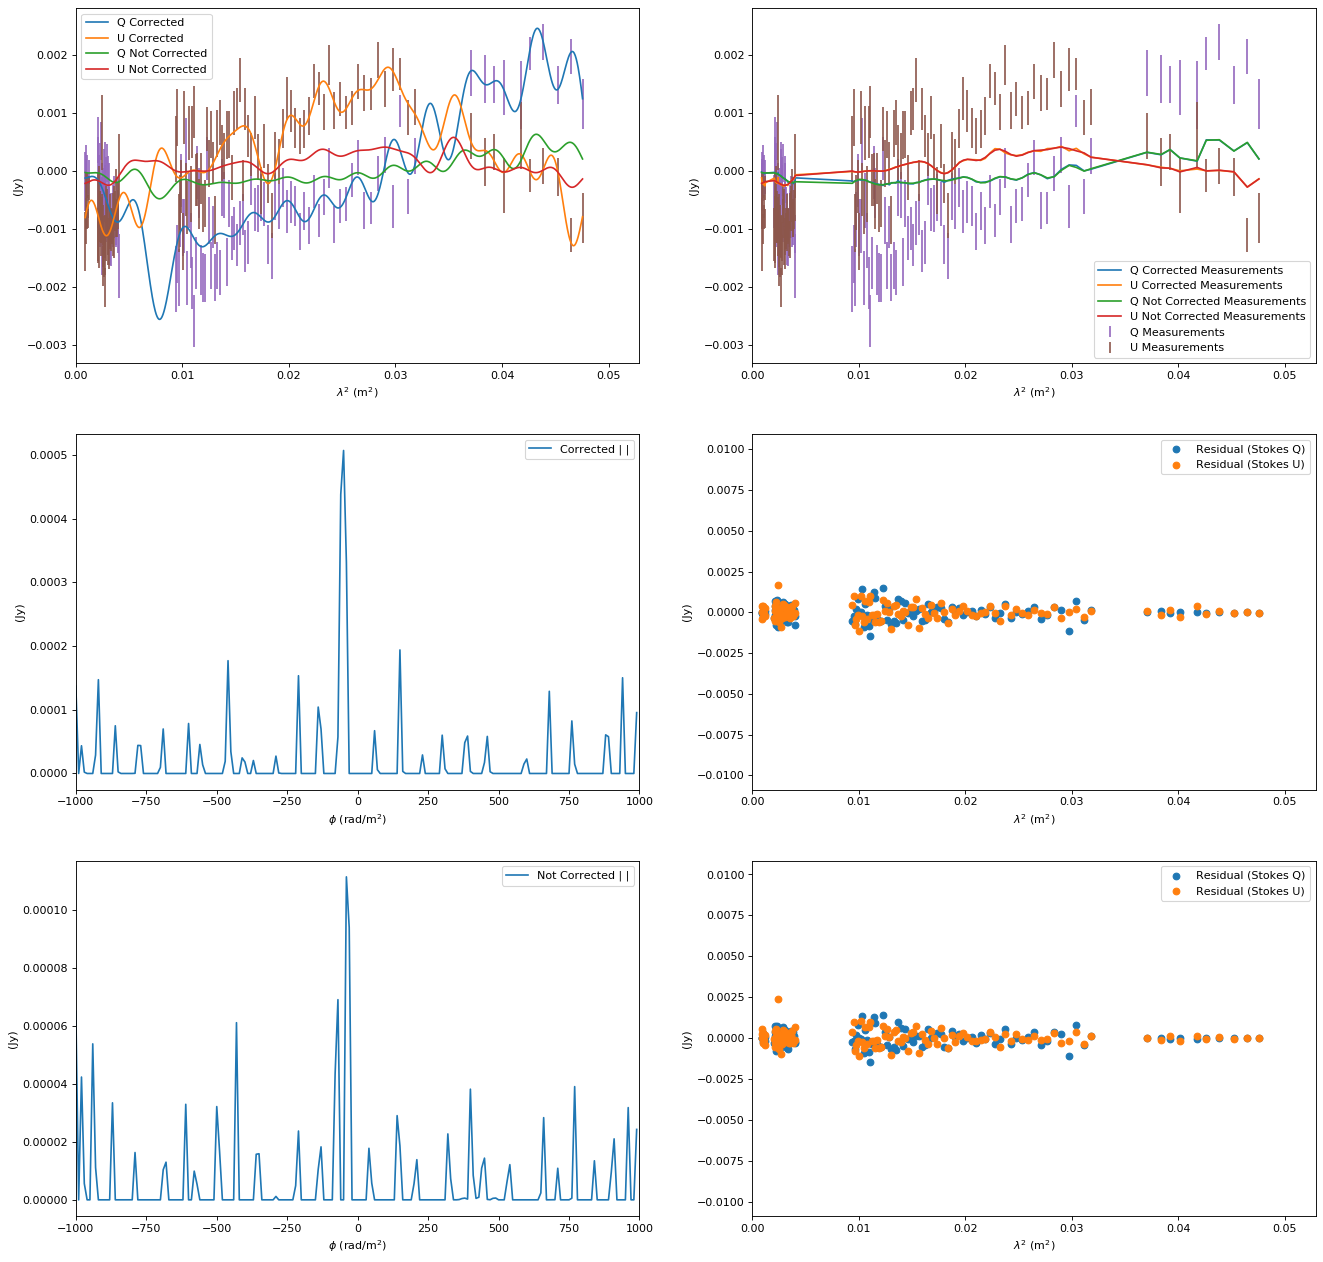

In [72]:
source = sources[16]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1.1
rm_max = 1000
beta = 1e-4
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1349'
2020-07-18 17:01:07,110 - Faraday Dreams - INFO - φ resolution 22.11923980653031 rad/m^2.
2020-07-18 17:01:07,111 - Faraday Dreams - INFO - φ max range is 279337.62845813745 rad/m^2.
2020-07-18 17:01:07,112 - Faraday Dreams - INFO - φ min range is 759.3326939422597 rad/m^2.
2020-07-18 17:01:07,134 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:07,135 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:07,137 - Optimus Primal - INFO - [Power Method] Converged with iter = 8, tol = 6.600889109296463e-05
2020-07-18 17:01:07,138 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:07,140 - Faraday Dreams - INFO - Using an estimated noise level of 0.0019339075370226055 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:01:07,141 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:01:07,142 - Optimus Primal - INFO - Running Forward Backward Primal Dual
20

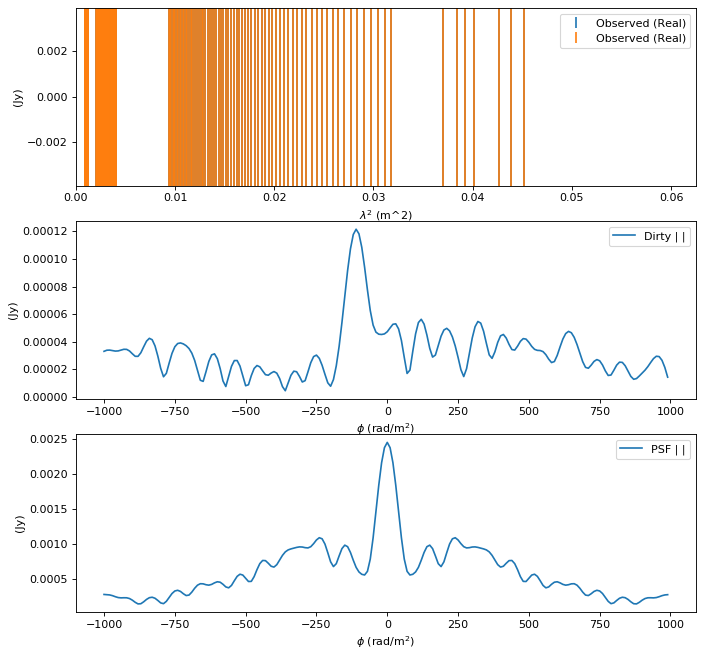

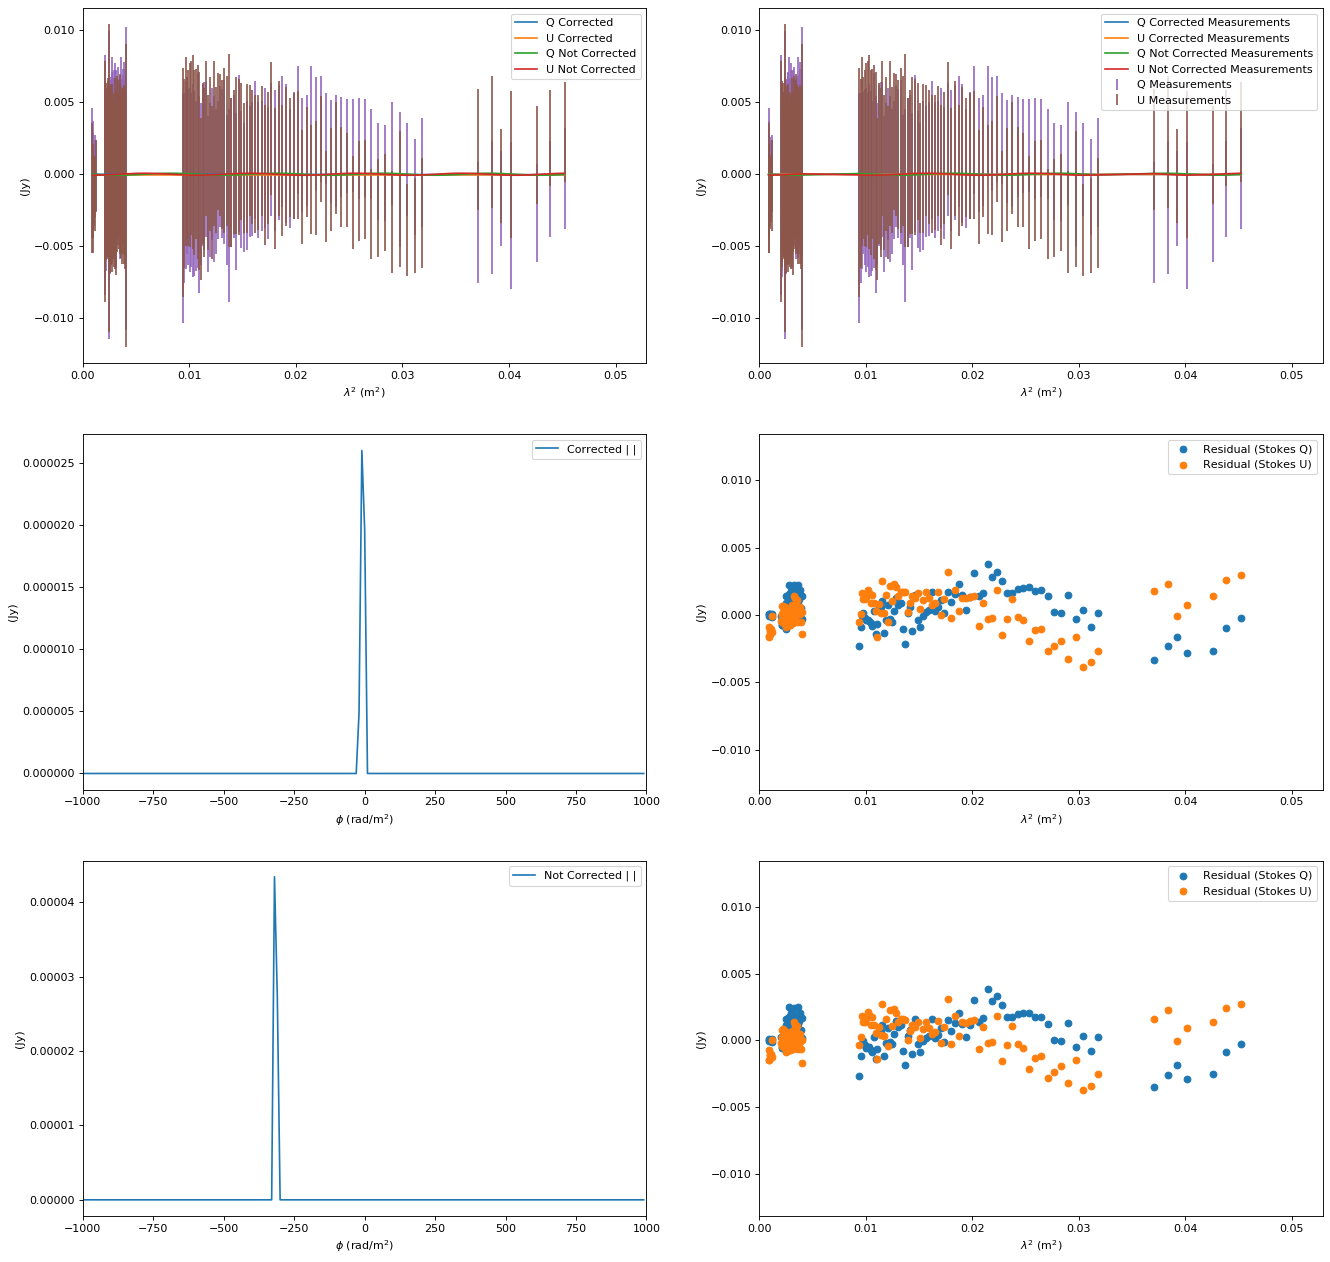

In [23]:
source = sources[17]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 3.5
rm_max = 1000
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1382'
2020-07-18 17:01:08,507 - Faraday Dreams - INFO - φ resolution 21.51911360597673 rad/m^2.
2020-07-18 17:01:08,508 - Faraday Dreams - INFO - φ max range is 8008.472198838518 rad/m^2.
2020-07-18 17:01:08,508 - Faraday Dreams - INFO - φ min range is 728.6384528358712 rad/m^2.
2020-07-18 17:01:08,522 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:08,523 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:08,525 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 17:01:08,527 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-07-18 17:01:08,529 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-07-18 17:01:08,530 - Optimus Primal - INFO - [Power Method] Converged with iter = 39, tol = 9.639407431792803e-05
2020-07-18 17:01:08,531 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:08,531 - Faraday Dreams - INFO - Using an estimated noise level of 0.000

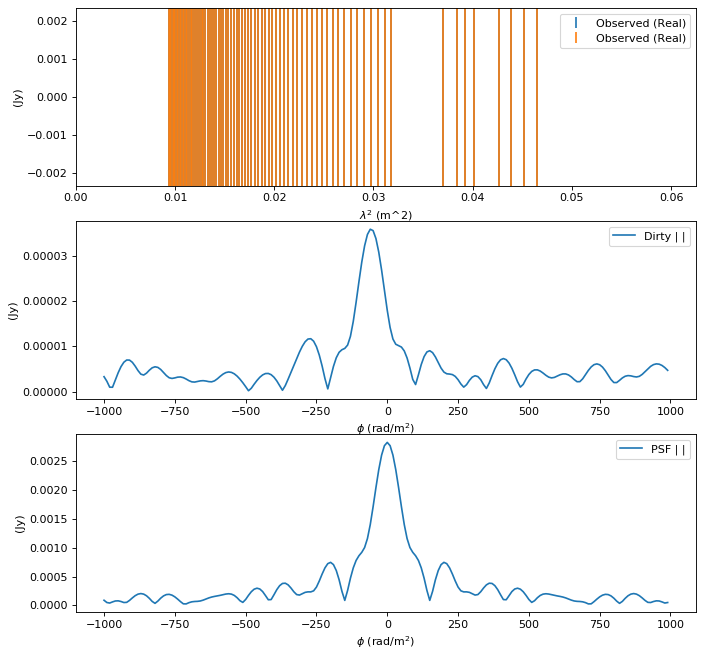

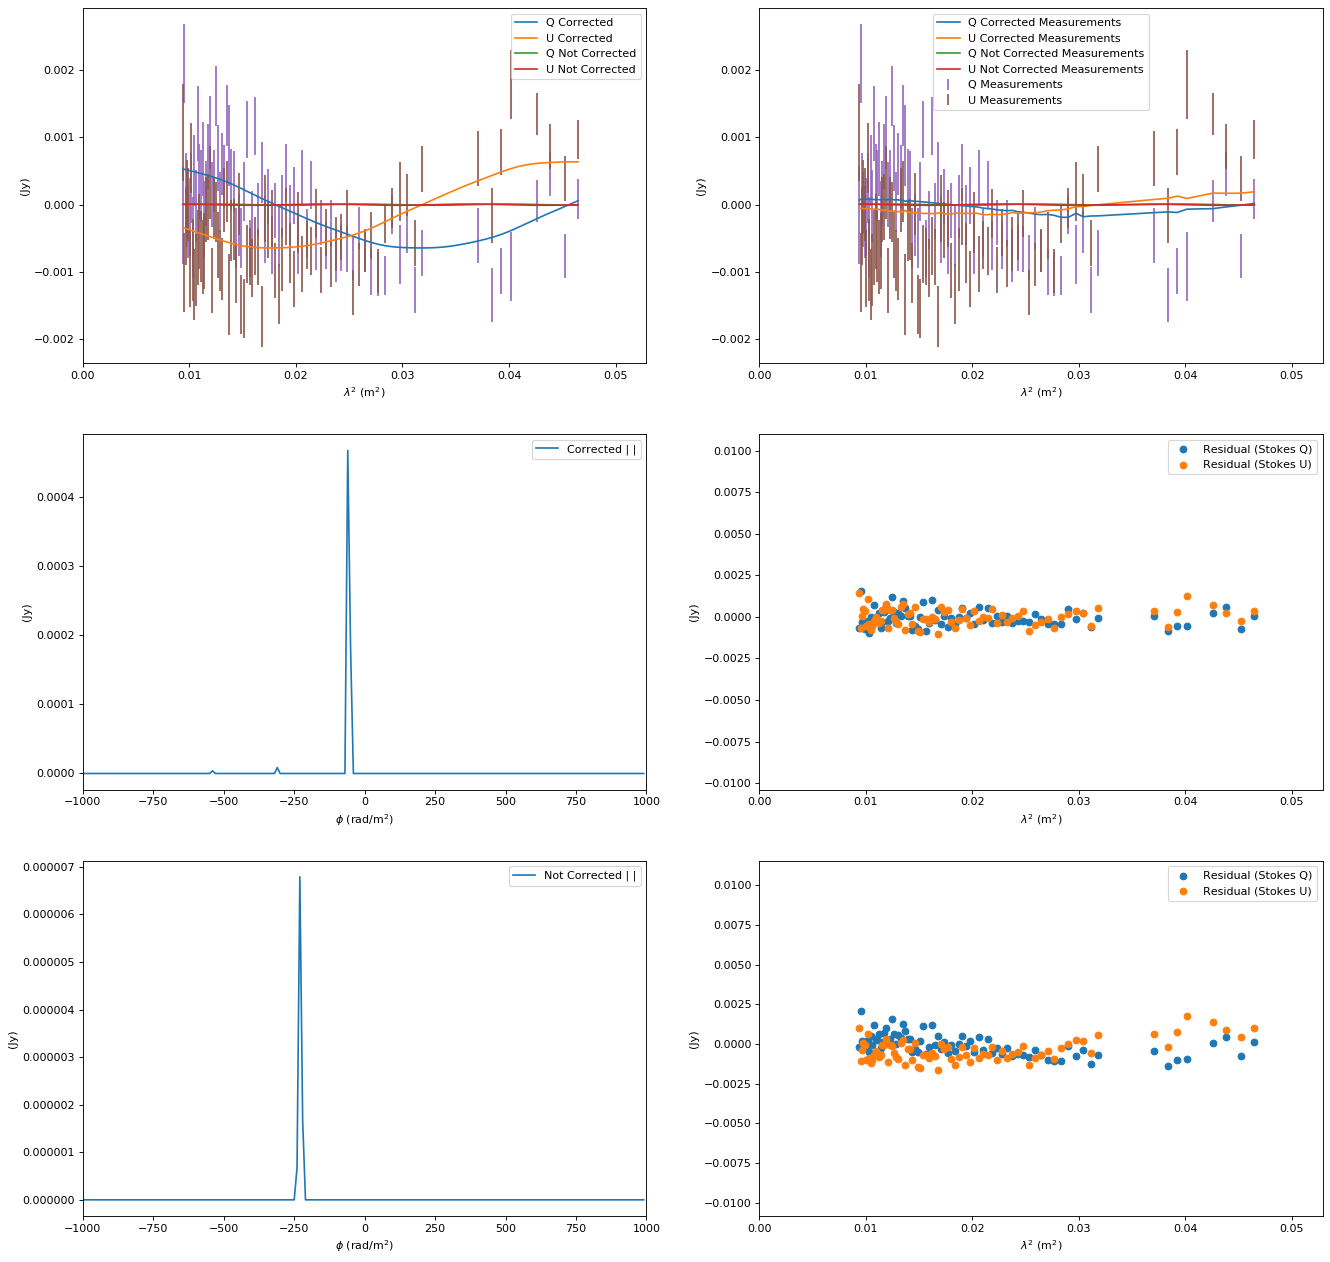

In [24]:
source = sources[18]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1437'
2020-07-18 17:01:12,216 - Faraday Dreams - INFO - φ resolution 21.02762685381873 rad/m^2.
2020-07-18 17:01:12,217 - Faraday Dreams - INFO - φ max range is 279401.08188832155 rad/m^2.
2020-07-18 17:01:12,217 - Faraday Dreams - INFO - φ min range is 703.8170852356799 rad/m^2.
2020-07-18 17:01:12,251 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:12,258 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:12,261 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 17:01:12,265 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-07-18 17:01:12,268 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-07-18 17:01:12,270 - Optimus Primal - INFO - [Power Method] Converged with iter = 41, tol = 8.747312343062306e-05
2020-07-18 17:01:12,271 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:12,272 - Faraday Dreams - INFO - Using an estimated noise level of 9.95

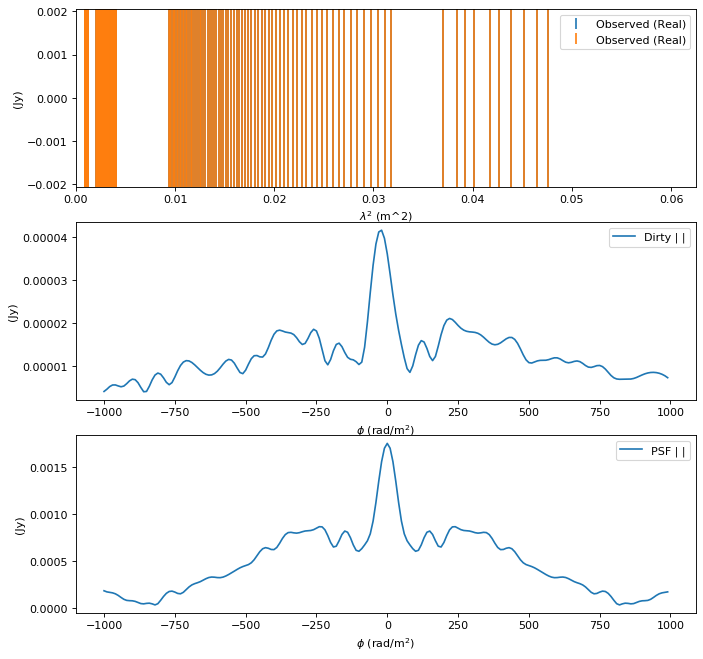

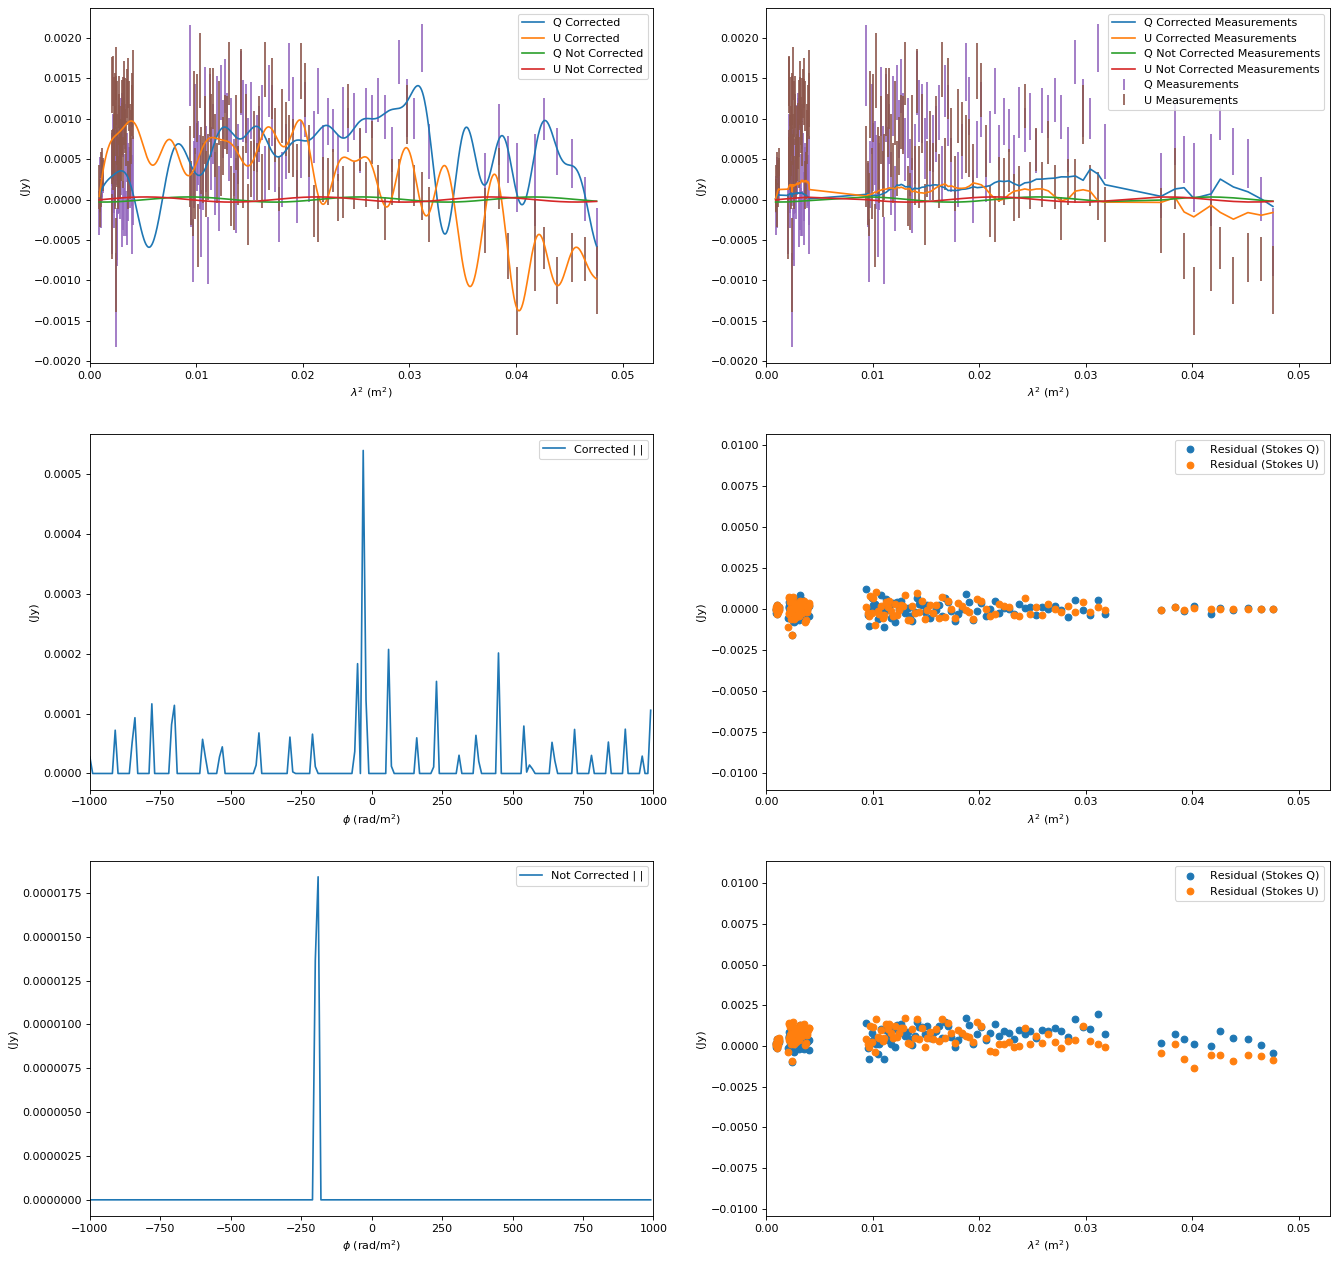

In [25]:
source = sources[19]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1443'
2020-07-18 17:01:25,156 - Faraday Dreams - INFO - φ resolution 21.027658261974576 rad/m^2.
2020-07-18 17:01:25,157 - Faraday Dreams - INFO - φ max range is 77150.70572010738 rad/m^2.
2020-07-18 17:01:25,158 - Faraday Dreams - INFO - φ min range is 703.8186622502269 rad/m^2.
2020-07-18 17:01:25,179 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:25,181 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:25,182 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 2.7603619289546734e-05
2020-07-18 17:01:25,183 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:25,183 - Faraday Dreams - INFO - Using an estimated noise level of 8.084181899903342e-05 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:01:25,184 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:01:25,185 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2

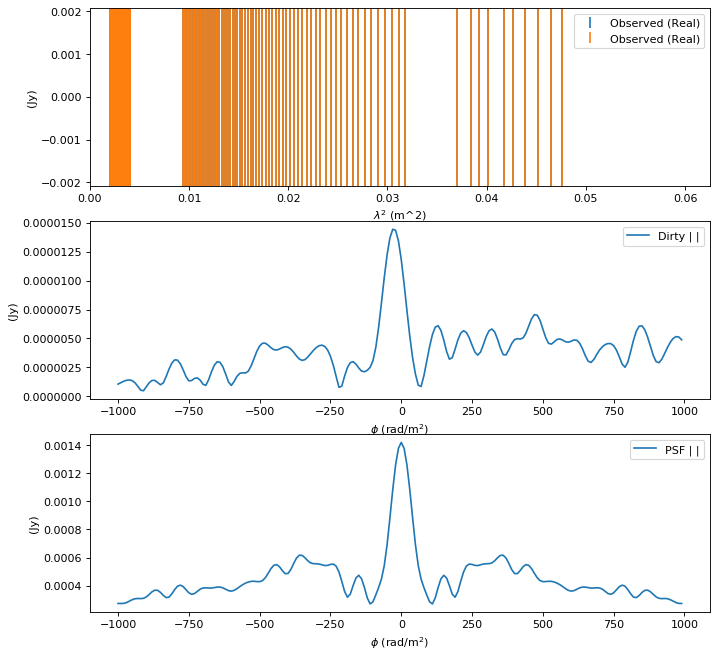

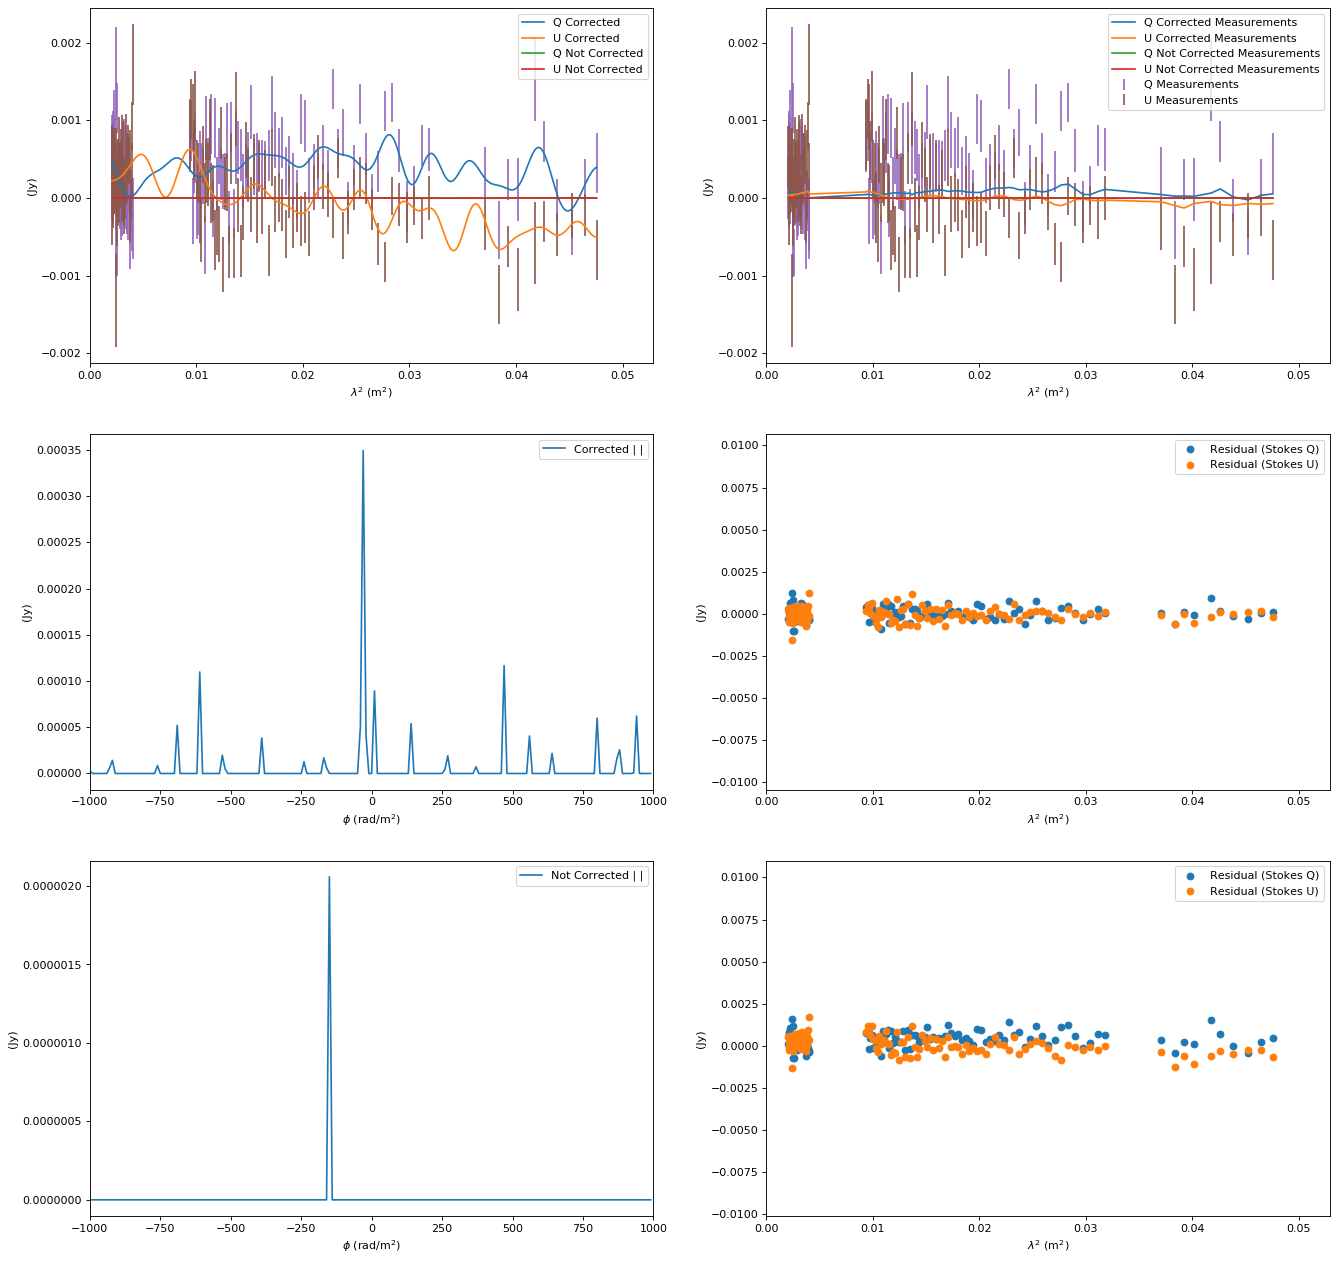

In [26]:
source = sources[20]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1568'
2020-07-18 17:01:37,793 - Faraday Dreams - INFO - φ resolution 19.8269825625 rad/m^2.
2020-07-18 17:01:37,794 - Faraday Dreams - INFO - φ max range is 279300.5829115088 rad/m^2.
2020-07-18 17:01:37,794 - Faraday Dreams - INFO - φ min range is 644.4013117536579 rad/m^2.
2020-07-18 17:01:37,819 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:37,820 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:37,822 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 17:01:37,823 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-07-18 17:01:37,825 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-07-18 17:01:37,826 - Optimus Primal - INFO - [Power Method] Converged with iter = 35, tol = 9.660720109049596e-05
2020-07-18 17:01:37,827 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:37,827 - Faraday Dreams - INFO - Using an estimated noise level of 0.0002978

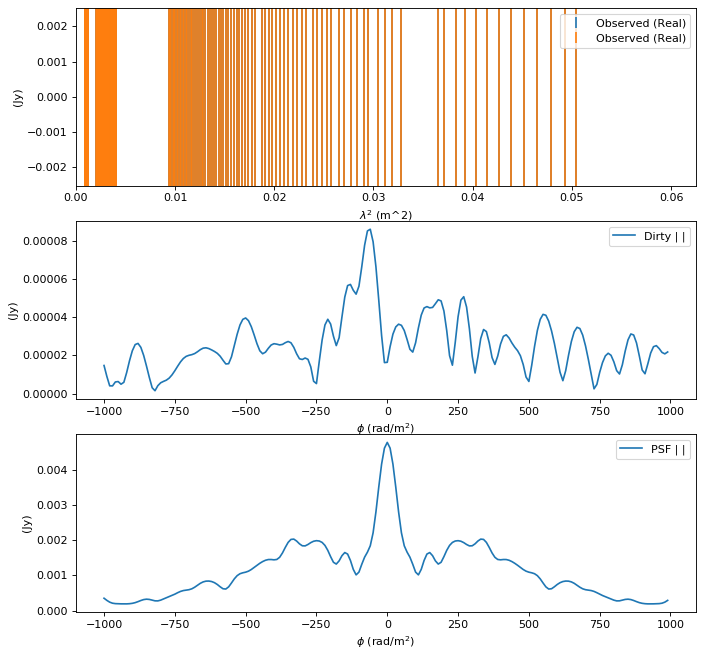

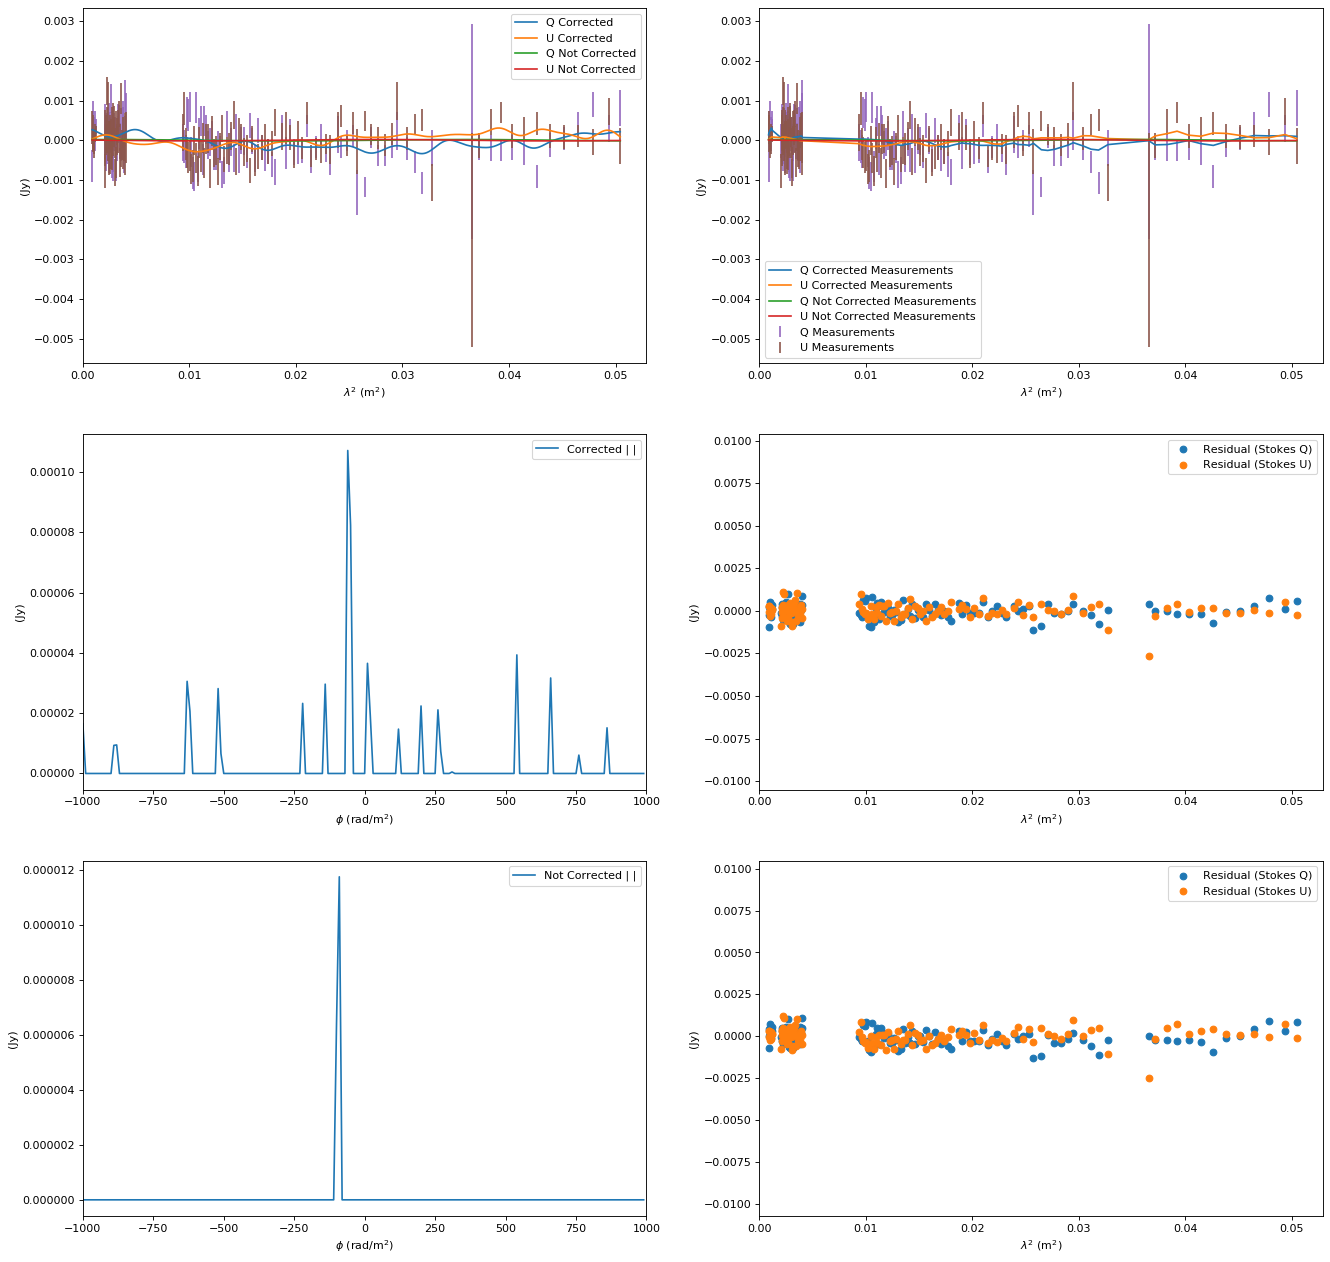

In [27]:
source = sources[21]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1605'
2020-07-18 17:01:41,844 - Faraday Dreams - INFO - φ resolution 19.83408930024395 rad/m^2.
2020-07-18 17:01:41,845 - Faraday Dreams - INFO - φ max range is 77166.77994969844 rad/m^2.
2020-07-18 17:01:41,845 - Faraday Dreams - INFO - φ min range is 644.7478367033619 rad/m^2.
2020-07-18 17:01:41,868 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:41,869 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:41,870 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 2.539654738628492e-05
2020-07-18 17:01:41,870 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:41,871 - Faraday Dreams - INFO - Using an estimated noise level of 0.0003159504267387092 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:01:41,872 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:01:41,872 - Optimus Primal - INFO - Running Forward Backward Primal Dual
202

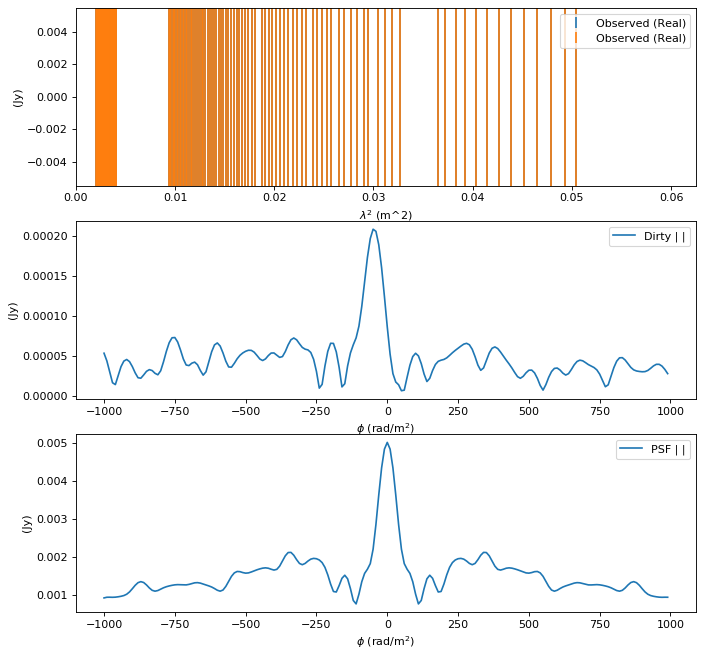

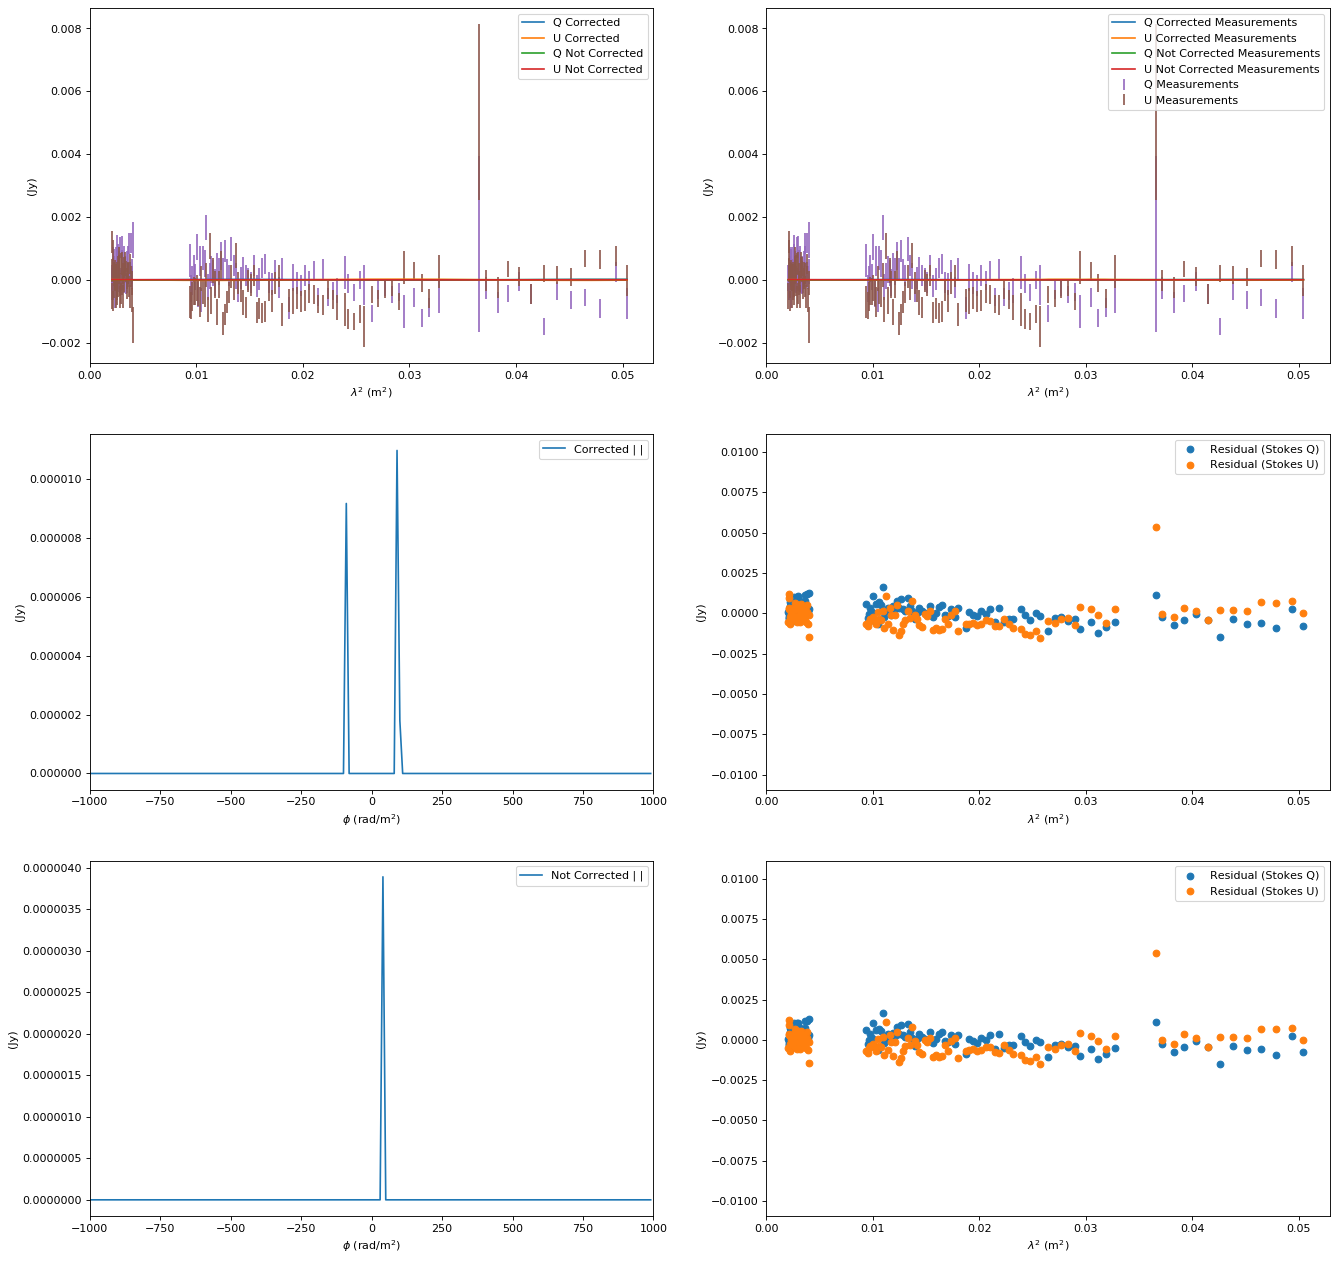

In [28]:
source = sources[22]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1681'
2020-07-18 17:01:43,197 - Faraday Dreams - INFO - φ resolution 20.890659849127417 rad/m^2.
2020-07-18 17:01:43,198 - Faraday Dreams - INFO - φ max range is 73156.59542259363 rad/m^2.
2020-07-18 17:01:43,199 - Faraday Dreams - INFO - φ min range is 696.9511382443034 rad/m^2.
2020-07-18 17:01:43,219 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:43,220 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:43,221 - Optimus Primal - INFO - [Power Method] Converged with iter = 6, tol = 9.155876201237008e-06
2020-07-18 17:01:43,222 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:43,223 - Faraday Dreams - INFO - Using an estimated noise level of 0.00010935687168966979 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:01:43,223 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:01:43,224 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2

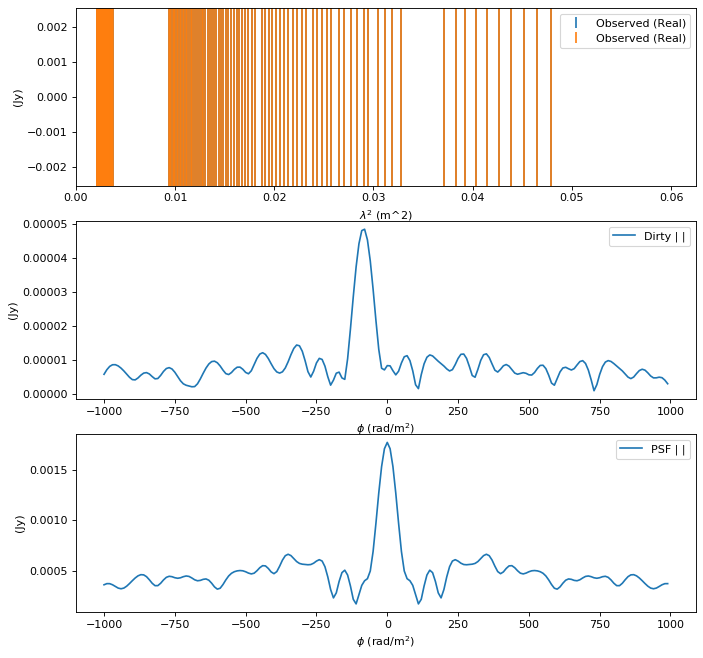

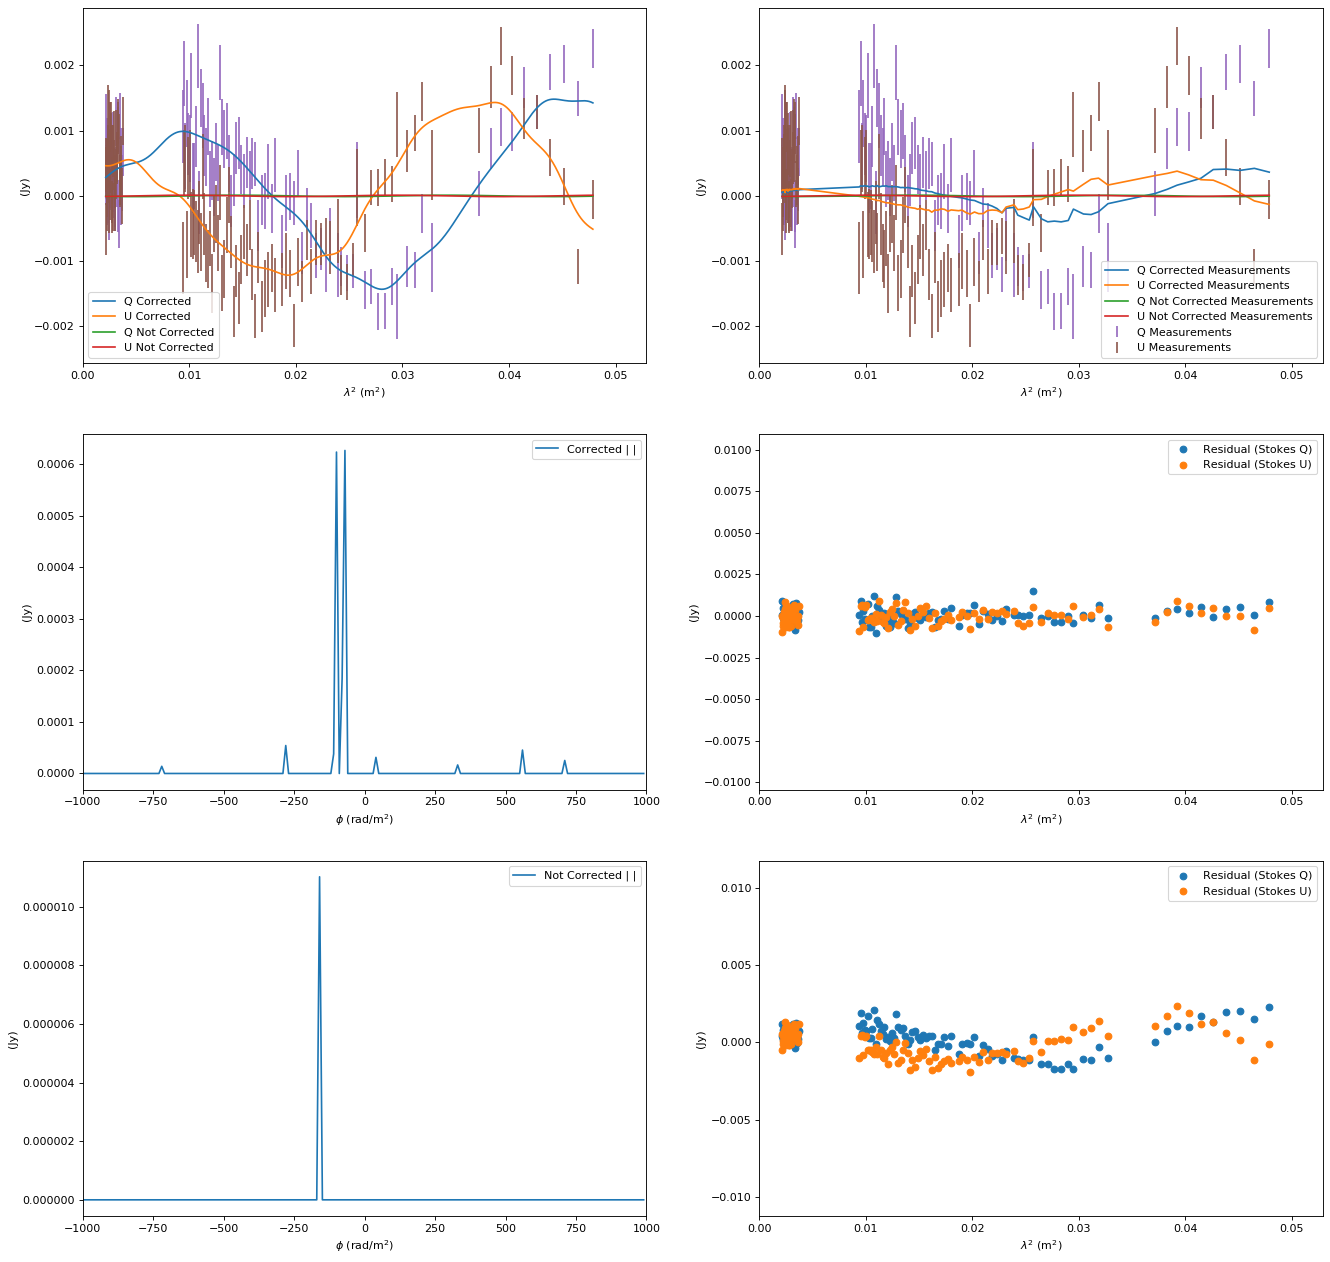

In [29]:
source = sources[23]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'cena_s1803'
2020-07-18 17:01:49,252 - Faraday Dreams - INFO - φ resolution 25.497554006954868 rad/m^2.
2020-07-18 17:01:49,253 - Faraday Dreams - INFO - φ max range is 279400.14492215076 rad/m^2.
2020-07-18 17:01:49,253 - Faraday Dreams - INFO - φ min range is 939.7897124823794 rad/m^2.
2020-07-18 17:01:49,275 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:49,277 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:49,278 - Optimus Primal - INFO - [Power Method] Converged with iter = 5, tol = 4.896328309928967e-05
2020-07-18 17:01:49,278 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:49,279 - Faraday Dreams - INFO - Using an estimated noise level of 0.0005007071304135025 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:01:49,279 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:01:49,280 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2

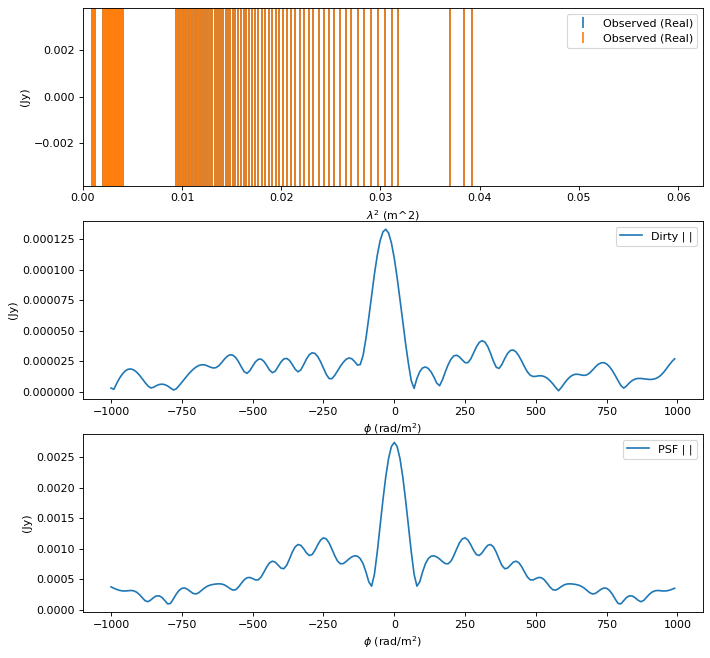

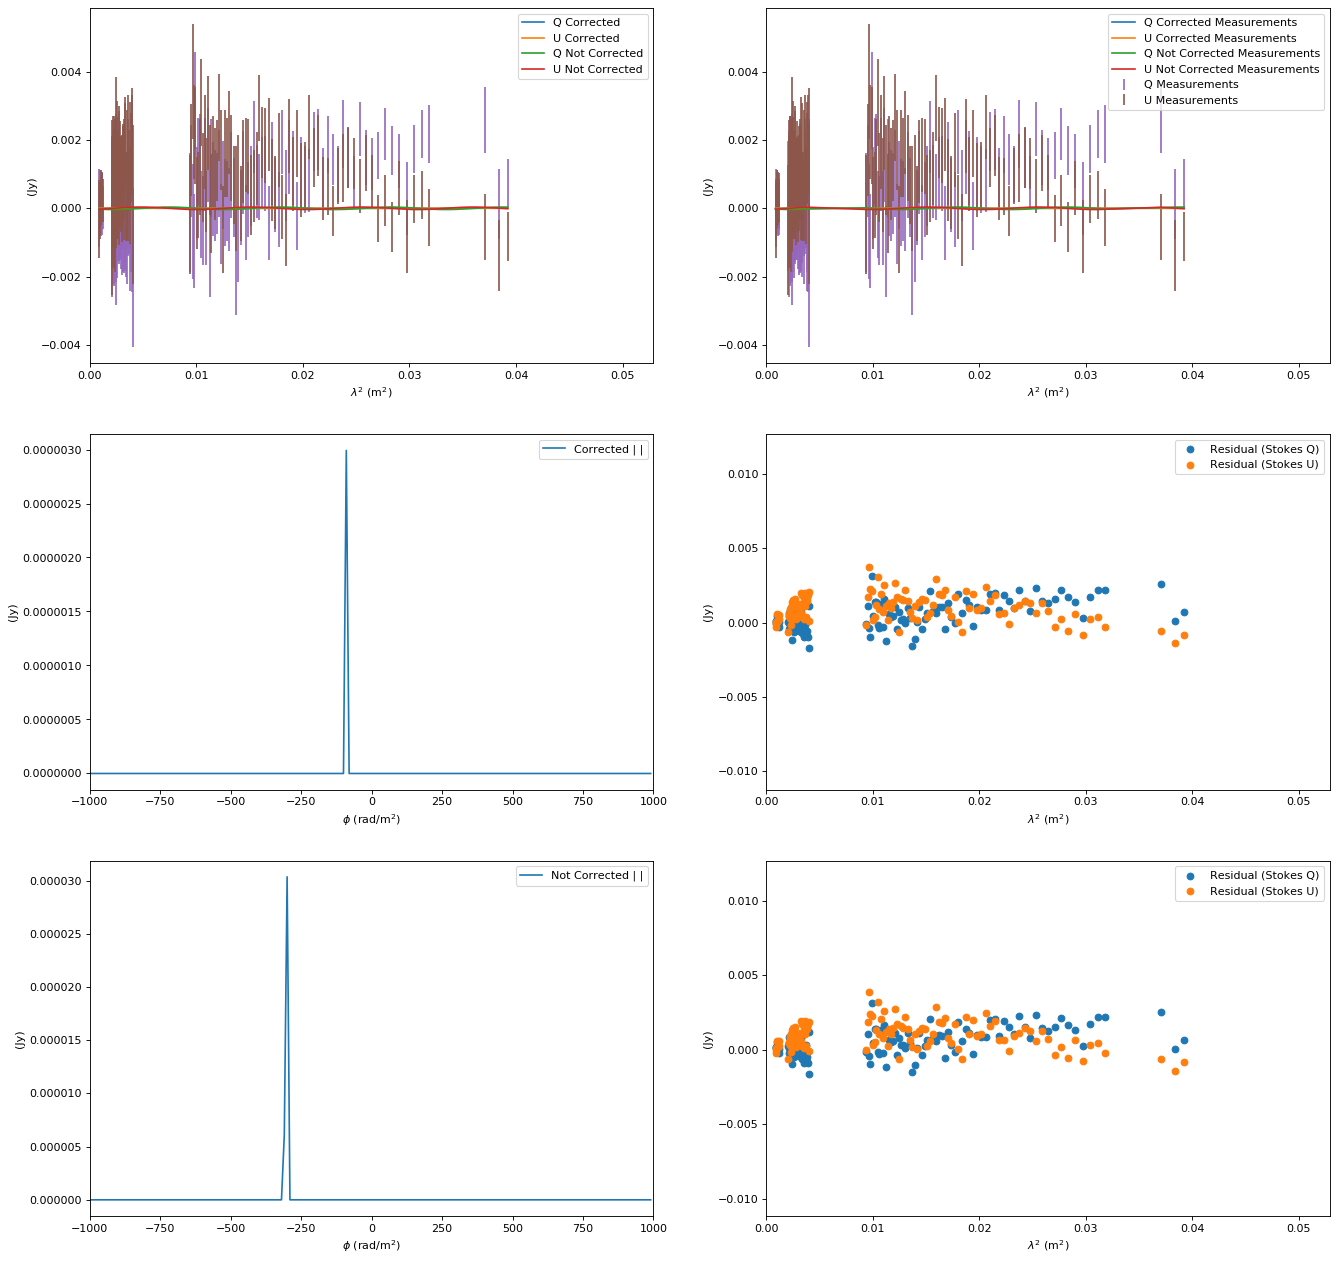

In [30]:
source = sources[24]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_c01'
2020-07-18 17:01:50,643 - Faraday Dreams - INFO - φ resolution 21.071369715894164 rad/m^2.
2020-07-18 17:01:50,644 - Faraday Dreams - INFO - φ max range is 279460.7113164403 rad/m^2.
2020-07-18 17:01:50,644 - Faraday Dreams - INFO - φ min range is 706.0145708300956 rad/m^2.
2020-07-18 17:01:50,667 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:01:50,668 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:01:50,669 - Optimus Primal - INFO - [Power Method] Converged with iter = 6, tol = 2.4464182577569855e-05
2020-07-18 17:01:50,669 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:01:50,670 - Faraday Dreams - INFO - Using an estimated noise level of 0.00012347025040071458 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:01:50,670 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:01:50,671 - Optimus Primal - INFO - Running Forward Backward Primal Dual
202

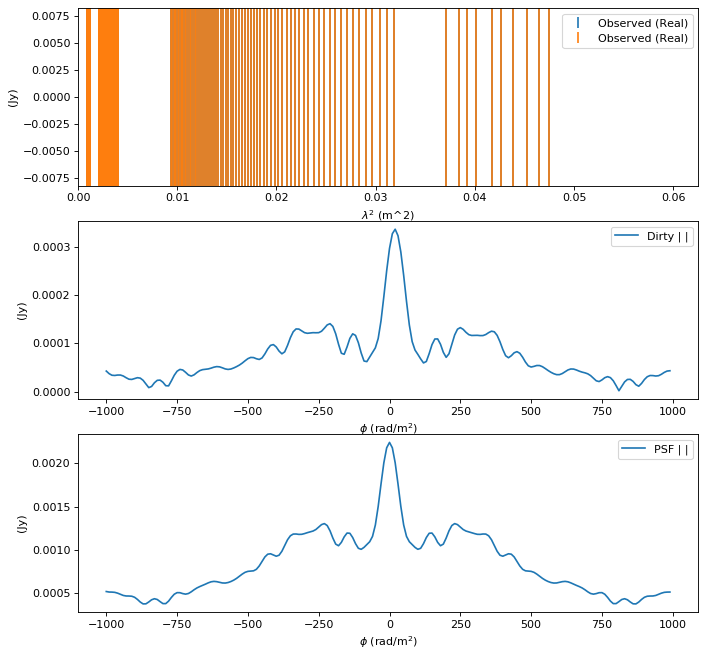

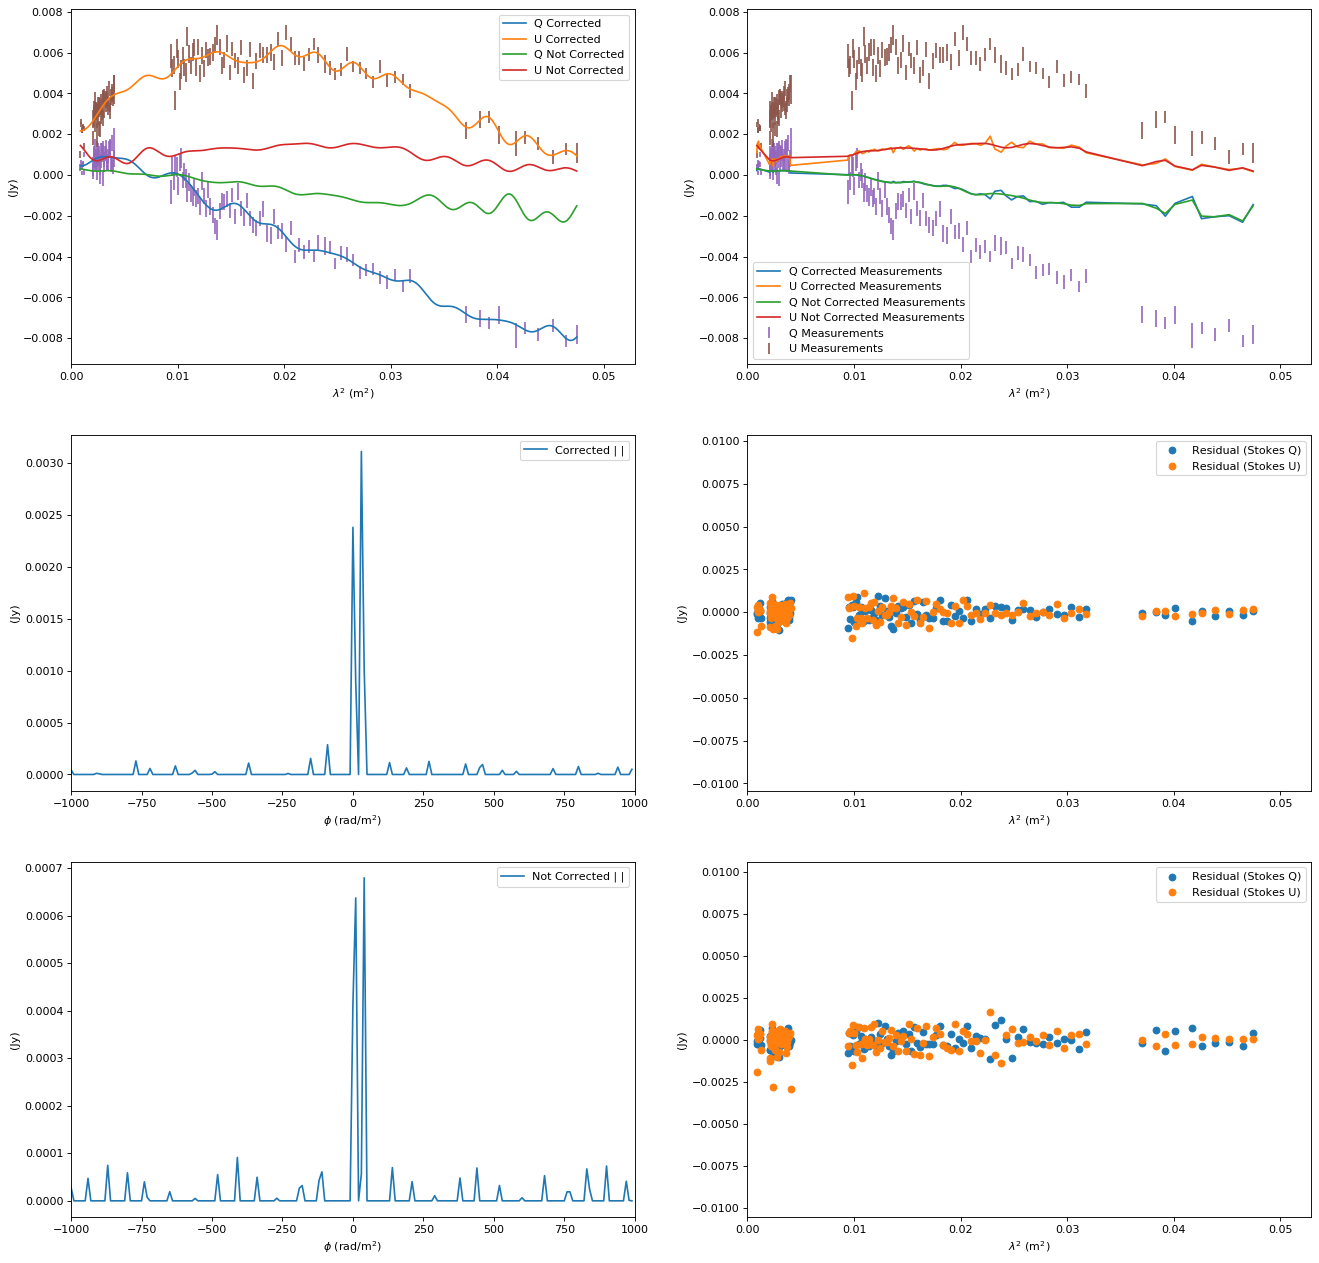

In [31]:
source = sources[25]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_c03'
2020-07-18 23:31:50,340 - Faraday Dreams - INFO - φ resolution 21.5180015625 rad/m^2.
2020-07-18 23:31:50,342 - Faraday Dreams - INFO - φ max range is 279403.21136468835 rad/m^2.
2020-07-18 23:31:50,344 - Faraday Dreams - INFO - φ min range is 728.5819686747205 rad/m^2.
2020-07-18 23:31:50,372 - Optimus Primal - INFO - Starting Power method
2020-07-18 23:31:50,374 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 23:31:50,379 - Optimus Primal - INFO - [Power Method] Converged with iter = 11, tol = 6.933224398246756e-05
2020-07-18 23:31:50,381 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 23:31:50,381 - Faraday Dreams - INFO - Using an estimated noise level of 0.0004395398427732289 (weighted image units, i.e. Jy/Beam)
2020-07-18 23:31:50,382 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 23:31:50,384 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-07-

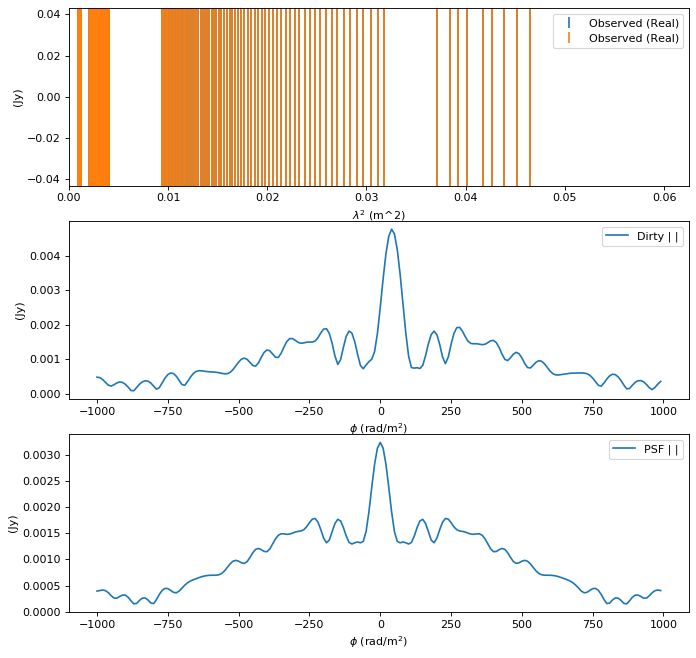

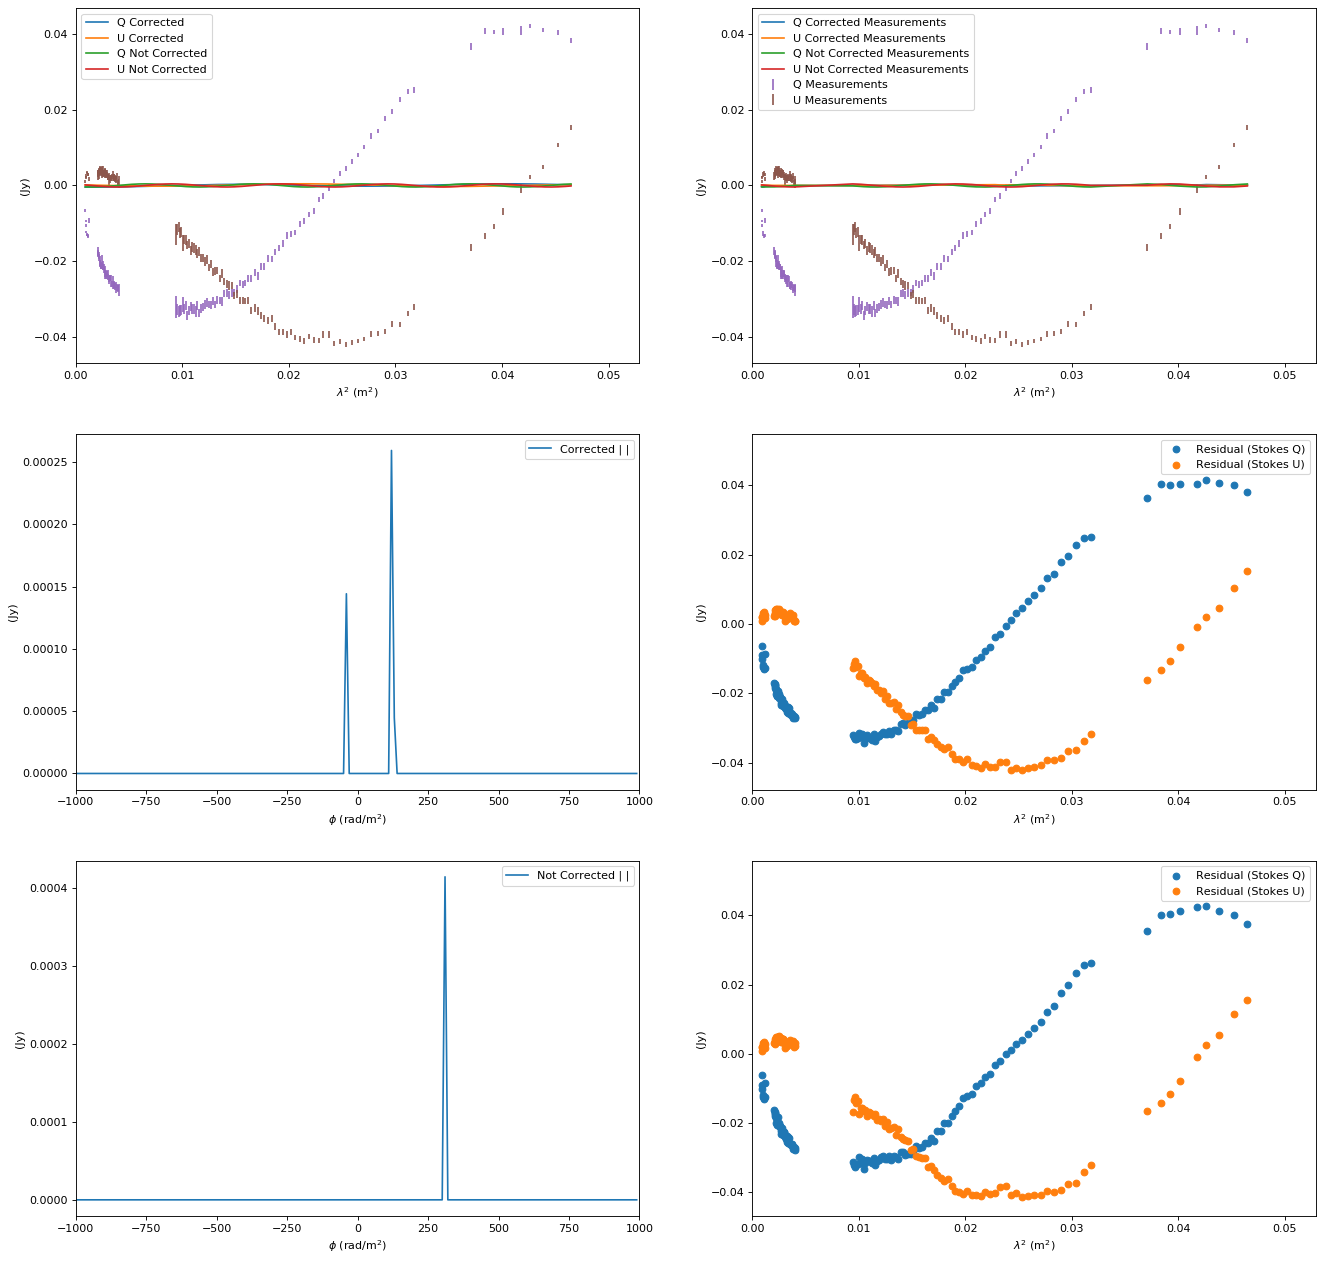

In [41]:
source = sources[27]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 2
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_c04'
2020-07-18 17:02:16,056 - Faraday Dreams - INFO - φ resolution 20.87112966785513 rad/m^2.
2020-07-18 17:02:16,057 - Faraday Dreams - INFO - φ max range is 265461.2006448128 rad/m^2.
2020-07-18 17:02:16,057 - Faraday Dreams - INFO - φ min range is 695.9739489984812 rad/m^2.
2020-07-18 17:02:16,096 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:02:16,099 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:02:16,100 - Optimus Primal - INFO - [Power Method] Converged with iter = 6, tol = 6.379594186854345e-05
2020-07-18 17:02:16,100 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:02:16,101 - Faraday Dreams - INFO - Using an estimated noise level of 0.00025056363665498793 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:02:16,101 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:02:16,102 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-

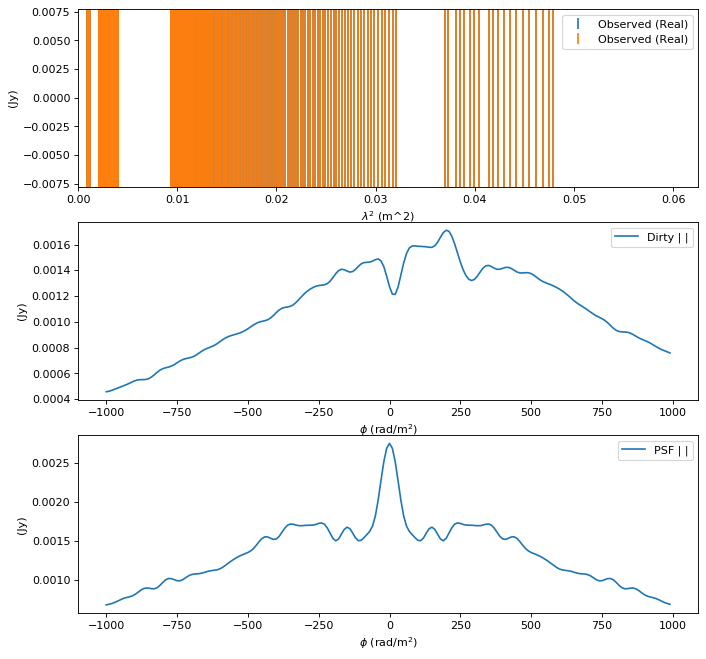

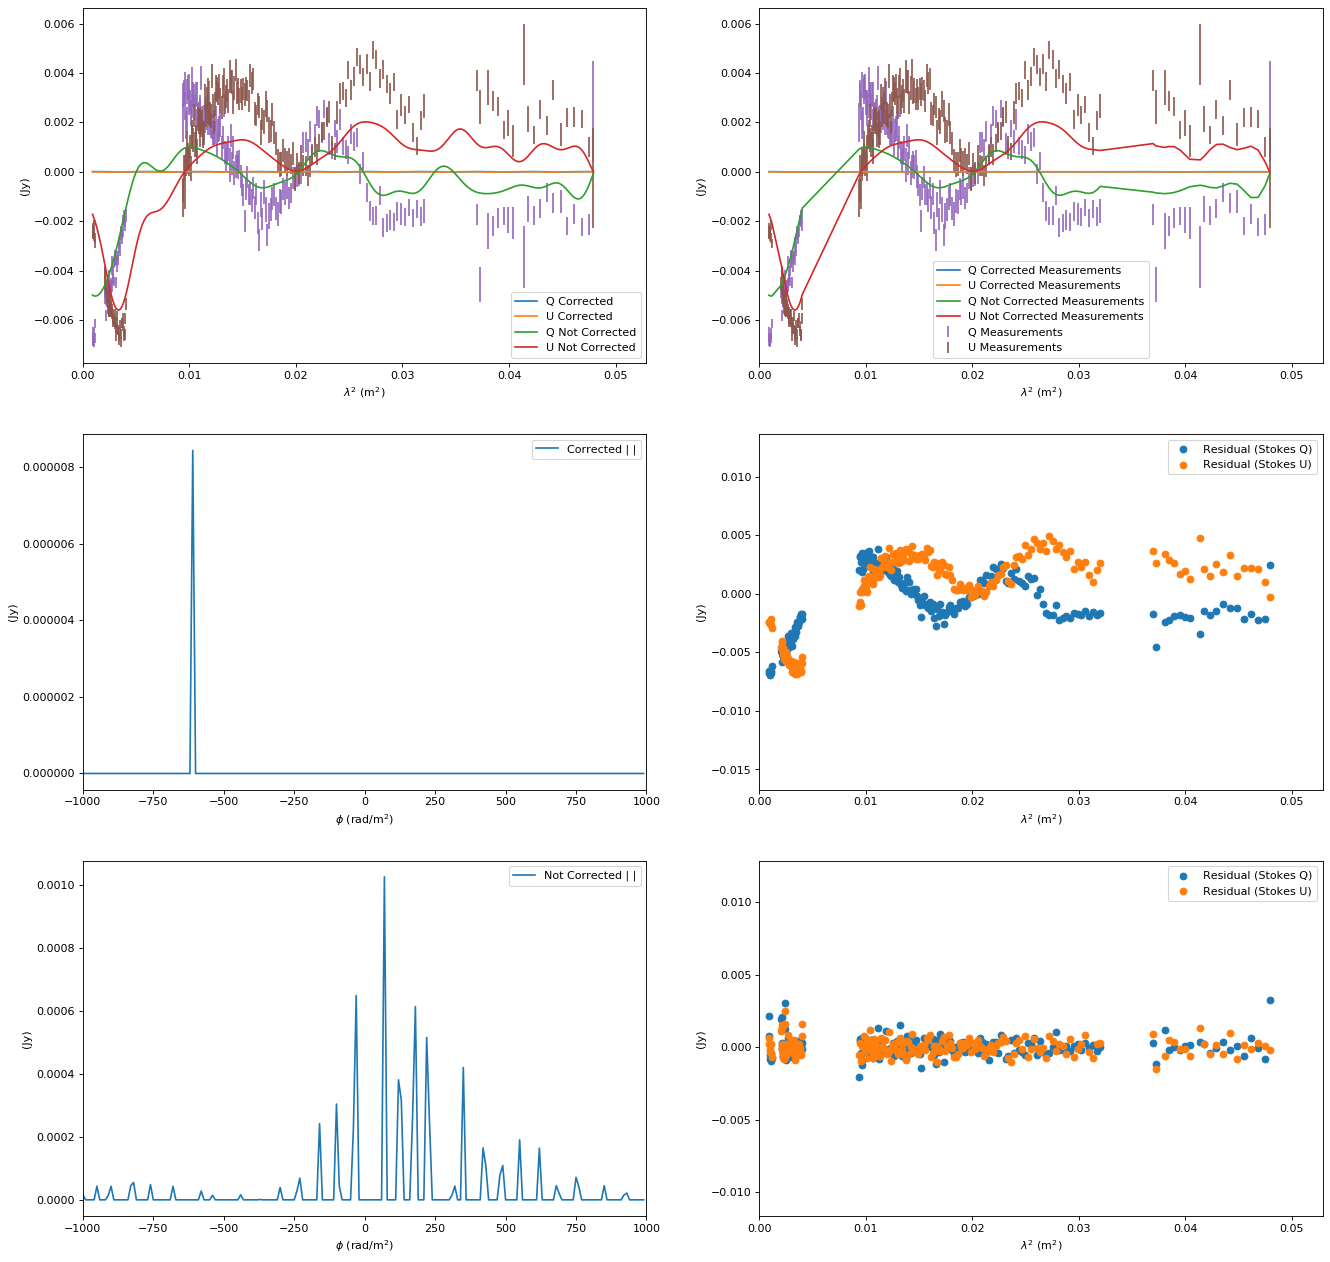

In [33]:
source = sources[28]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_c06'
2020-07-18 17:02:28,993 - Faraday Dreams - INFO - φ resolution 20.87112966785513 rad/m^2.
2020-07-18 17:02:28,994 - Faraday Dreams - INFO - φ max range is 77145.36017890052 rad/m^2.
2020-07-18 17:02:28,994 - Faraday Dreams - INFO - φ min range is 695.9739489984812 rad/m^2.
2020-07-18 17:02:29,016 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:02:29,017 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:02:29,018 - Optimus Primal - INFO - [Power Method] Converged with iter = 7, tol = 4.138639377130167e-05
2020-07-18 17:02:29,019 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:02:29,019 - Faraday Dreams - INFO - Using an estimated noise level of 0.0002332130097784102 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:02:29,020 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:02:29,020 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-0

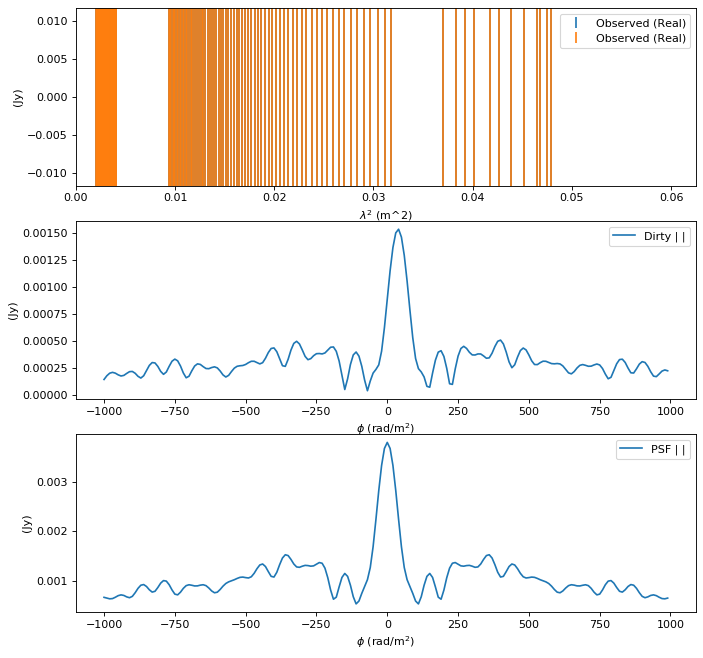

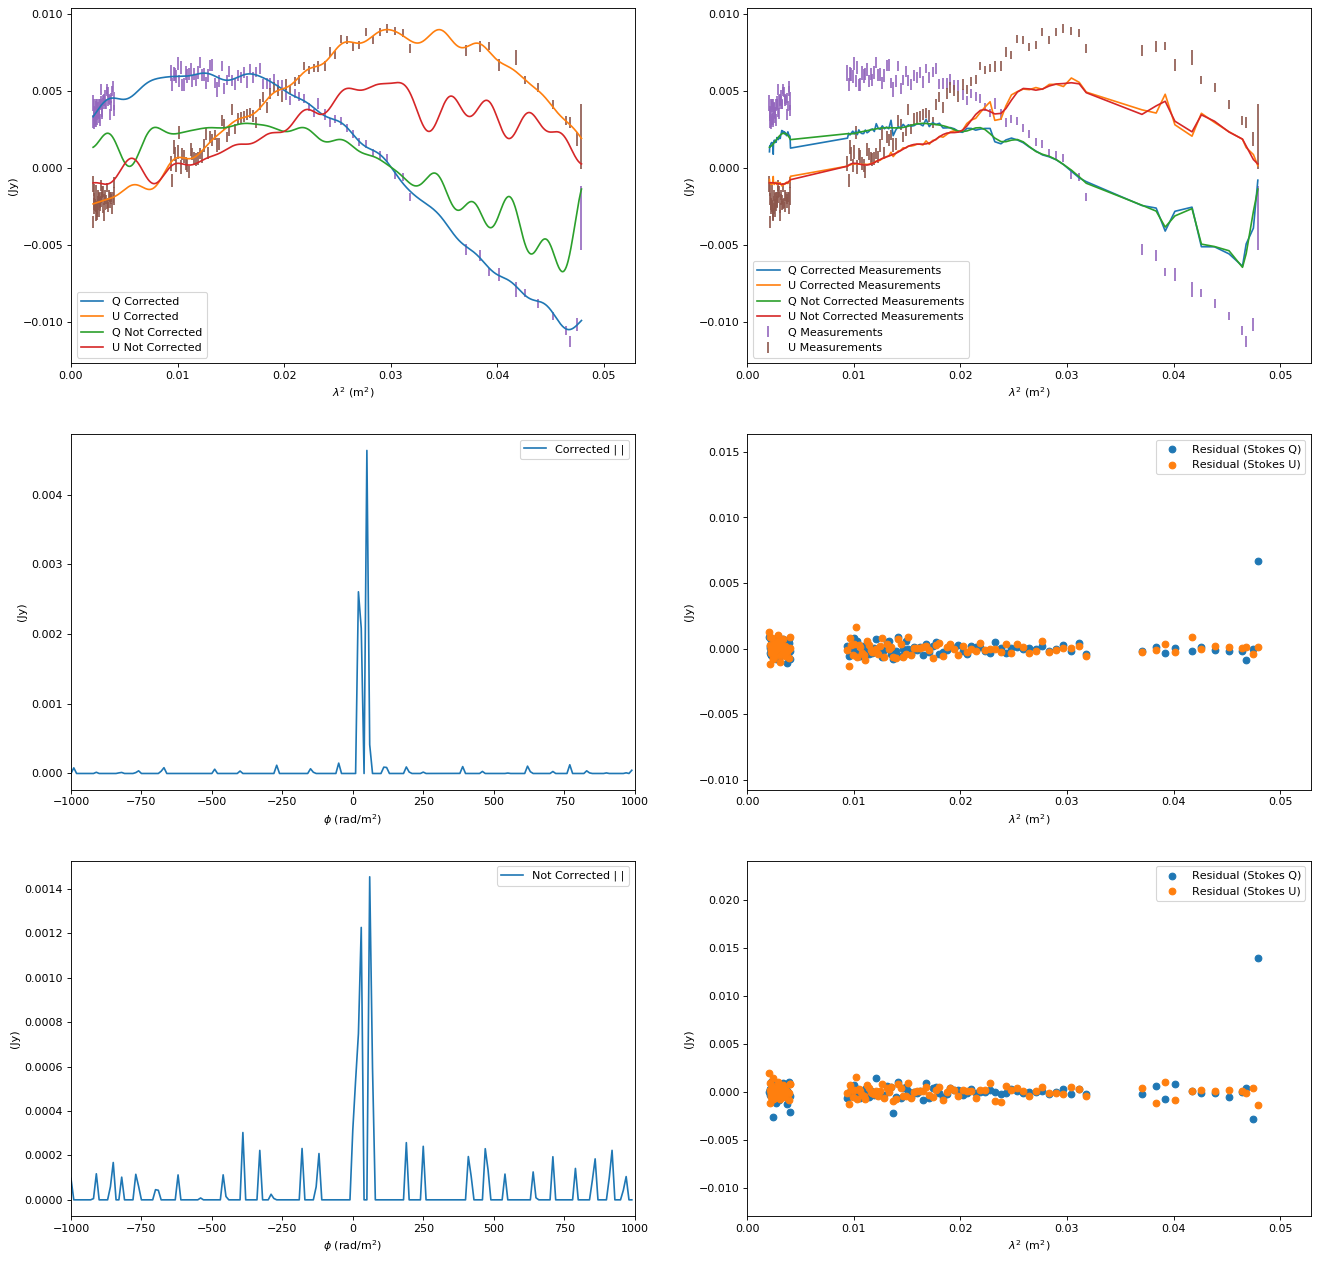

In [34]:
source = sources[29]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_c07'
2020-07-18 17:02:52,749 - Faraday Dreams - INFO - φ resolution 21.062378607665604 rad/m^2.
2020-07-18 17:02:52,750 - Faraday Dreams - INFO - φ max range is 279508.6765690141 rad/m^2.
2020-07-18 17:02:52,751 - Faraday Dreams - INFO - φ min range is 705.5627031546534 rad/m^2.
2020-07-18 17:02:52,774 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:02:52,775 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:02:52,776 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 17:02:52,777 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-07-18 17:02:52,778 - Optimus Primal - INFO - [Power Method] Converged with iter = 25, tol = 7.875509421274107e-05
2020-07-18 17:02:52,779 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:02:52,779 - Faraday Dreams - INFO - Using an estimated noise level of 0.00015873393567744642 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:02:52,780 - Faraday

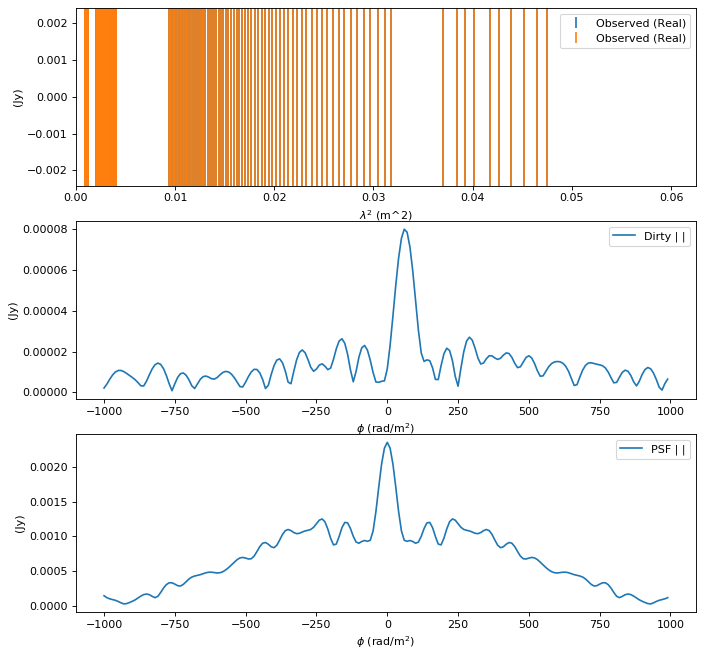

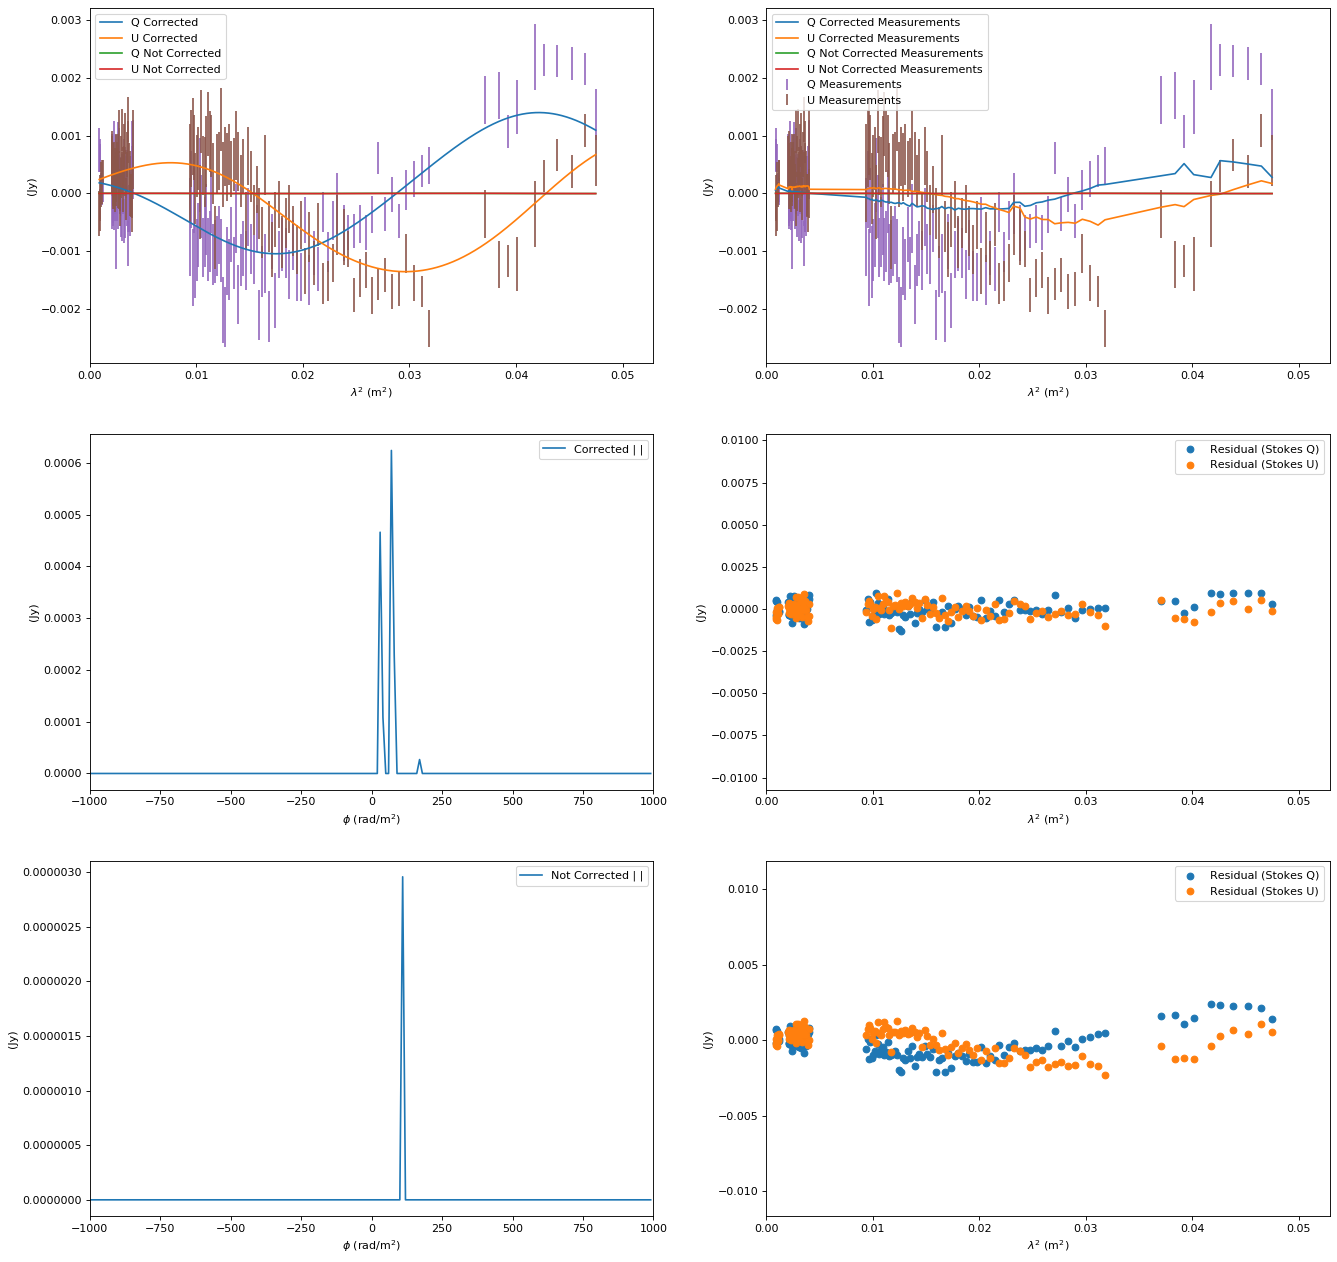

In [35]:
source = sources[30]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_c15'
2020-07-18 17:02:56,027 - Faraday Dreams - INFO - φ resolution 21.05379797599221 rad/m^2.
2020-07-18 17:02:56,028 - Faraday Dreams - INFO - φ max range is 279409.9405810959 rad/m^2.
2020-07-18 17:02:56,028 - Faraday Dreams - INFO - φ min range is 705.1315548094176 rad/m^2.
2020-07-18 17:02:56,052 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:02:56,053 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:02:56,054 - Optimus Primal - INFO - [Power Method] Converged with iter = 5, tol = 1.7079786144020196e-05
2020-07-18 17:02:56,054 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:02:56,055 - Faraday Dreams - INFO - Using an estimated noise level of 0.00039659091271460056 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:02:56,056 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 17:02:56,057 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020

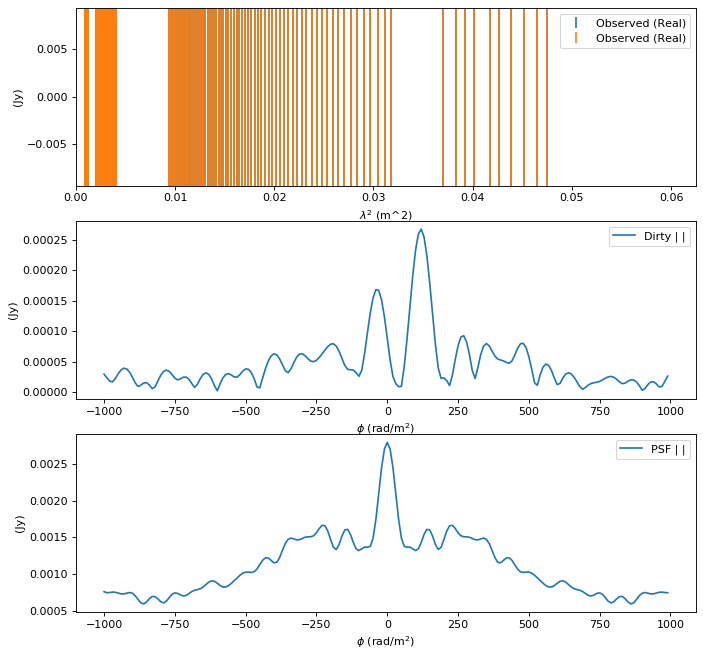

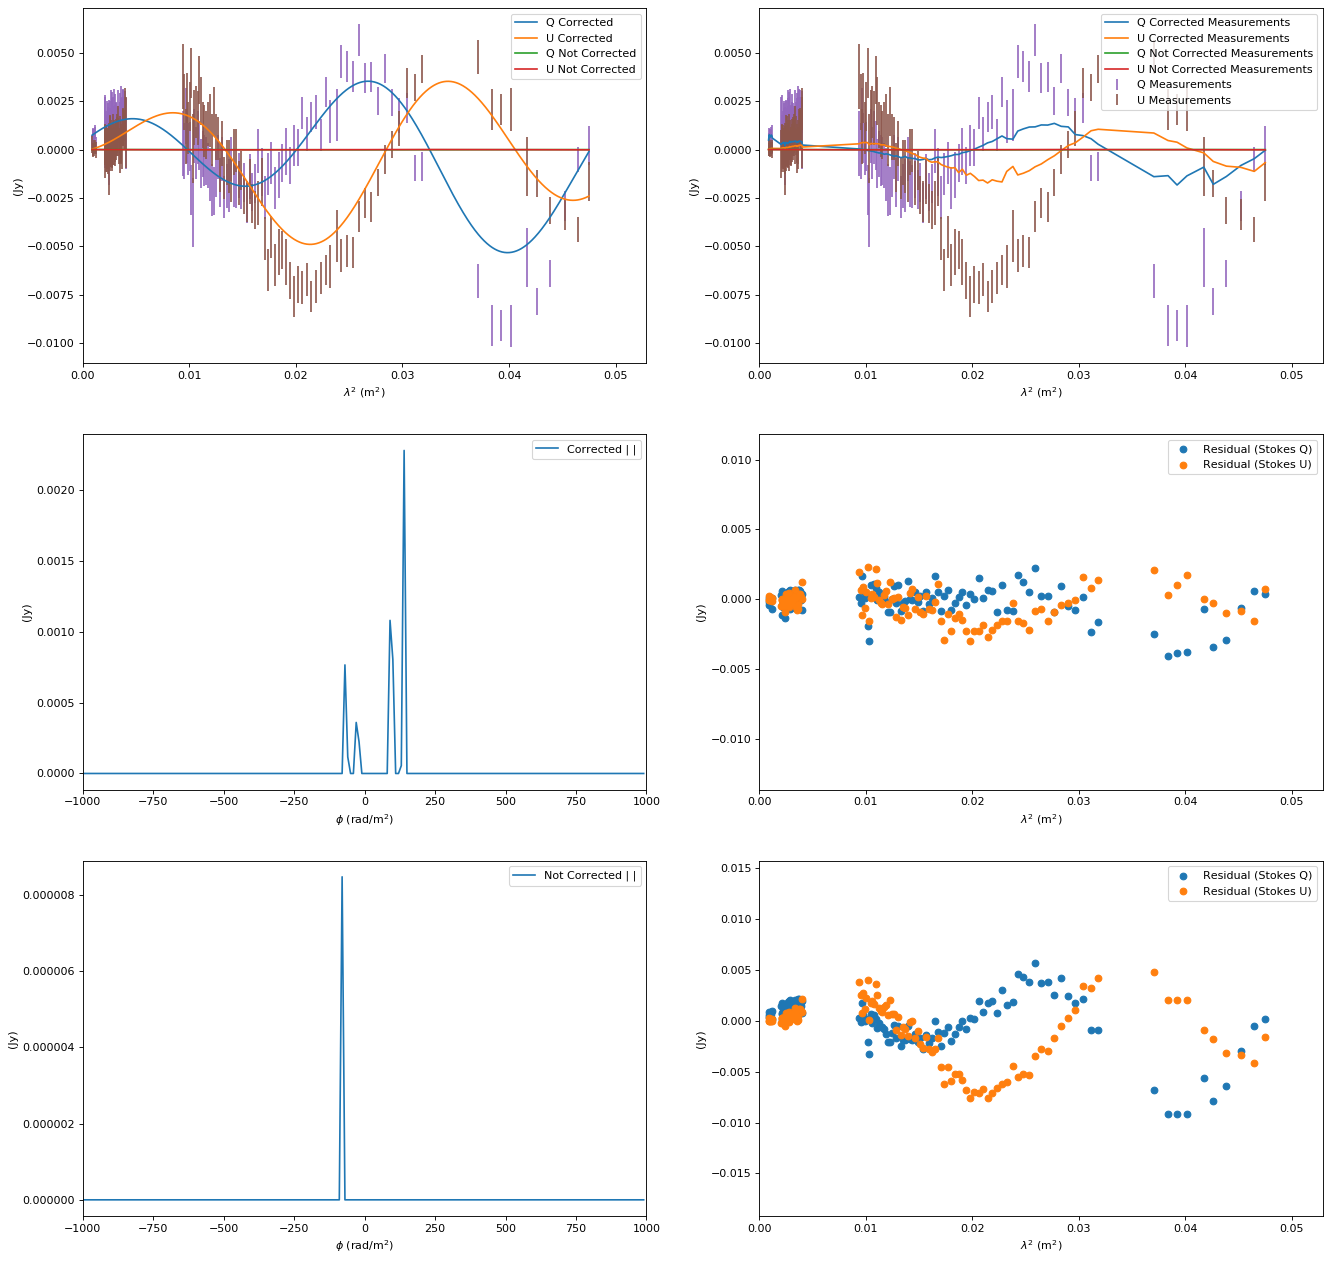

In [36]:
source = sources[31]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_c16'
2020-07-18 23:41:38,486 - Faraday Dreams - INFO - φ resolution 21.517556753154906 rad/m^2.
2020-07-18 23:41:38,487 - Faraday Dreams - INFO - φ max range is 279497.1746316958 rad/m^2.
2020-07-18 23:41:38,487 - Faraday Dreams - INFO - φ min range is 728.5593758276074 rad/m^2.
2020-07-18 23:41:38,519 - Optimus Primal - INFO - Starting Power method
2020-07-18 23:41:38,520 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 23:41:38,523 - Optimus Primal - INFO - [Power Method] Converged with iter = 6, tol = 8.317323194143718e-05
2020-07-18 23:41:38,524 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 23:41:38,524 - Faraday Dreams - INFO - Using an estimated noise level of 0.00019796362903434783 (weighted image units, i.e. Jy/Beam)
2020-07-18 23:41:38,526 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 23:41:38,527 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020

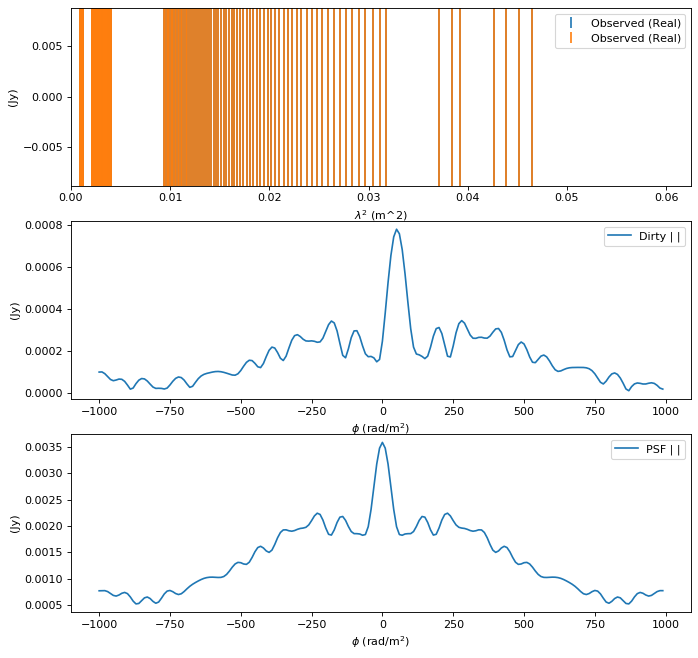

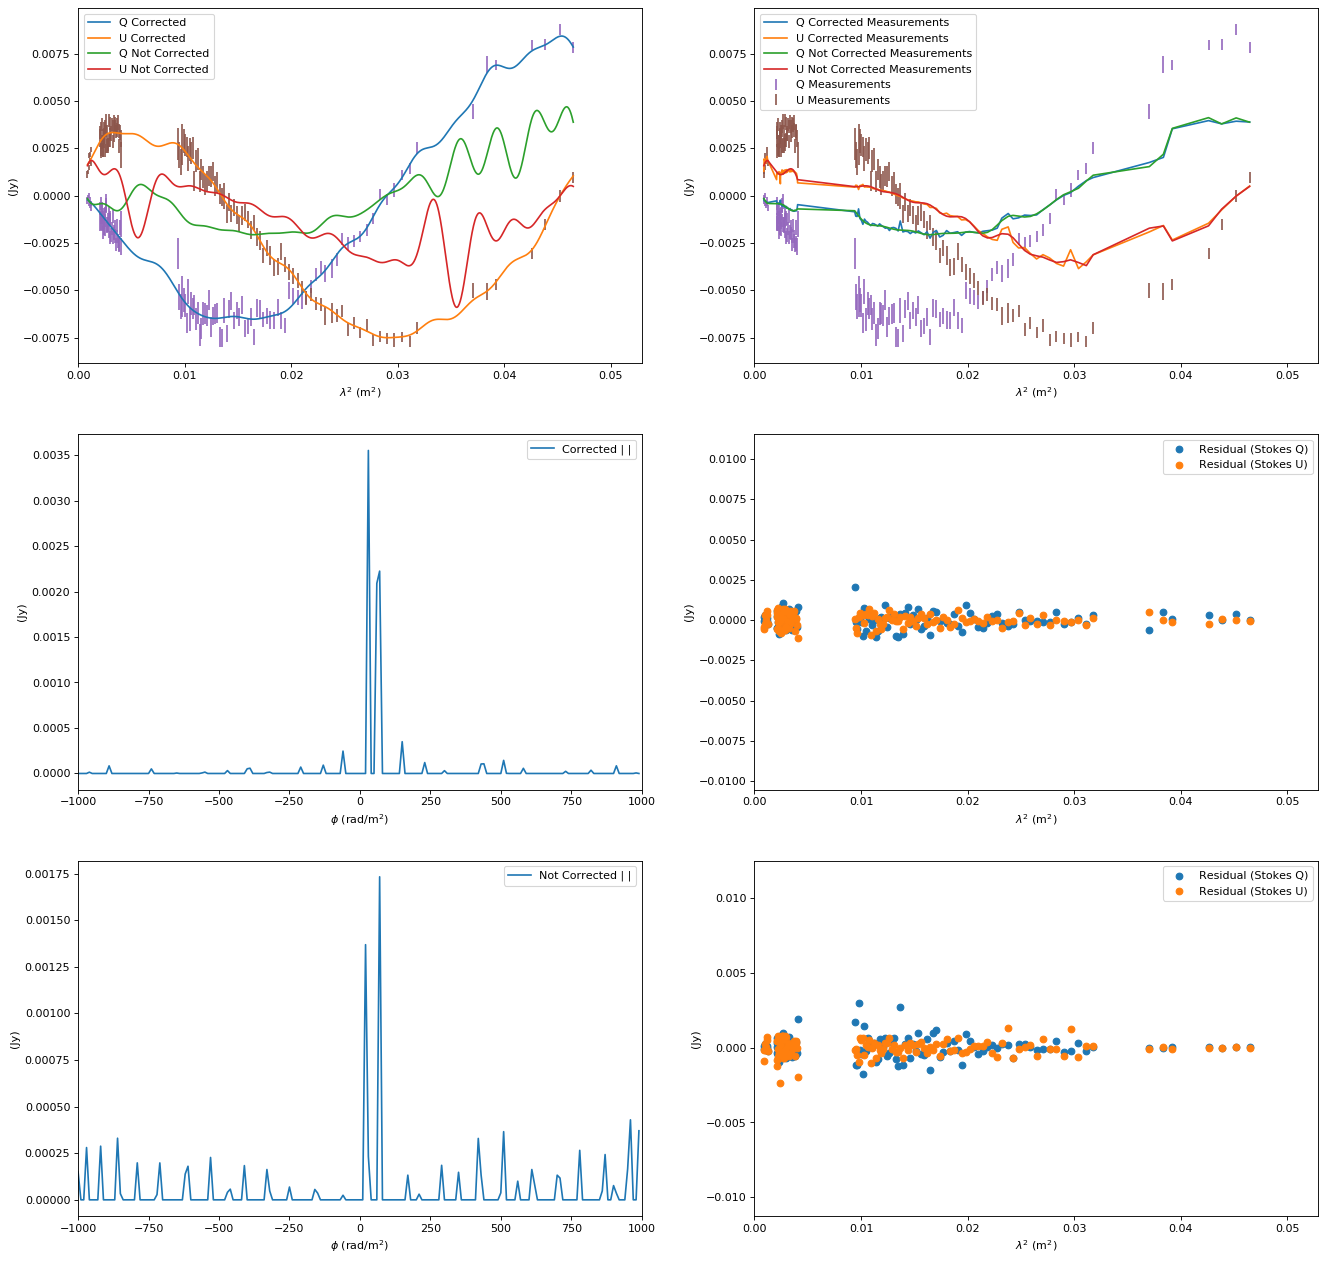

In [51]:
source = sources[32]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-3
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_s11'
2020-07-18 23:40:02,357 - Faraday Dreams - INFO - φ resolution 21.06099553054044 rad/m^2.
2020-07-18 23:40:02,357 - Faraday Dreams - INFO - φ max range is 279335.15865312505 rad/m^2.
2020-07-18 23:40:02,358 - Faraday Dreams - INFO - φ min range is 705.4932021676364 rad/m^2.
2020-07-18 23:40:02,396 - Optimus Primal - INFO - Starting Power method
2020-07-18 23:40:02,397 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 23:40:02,399 - Optimus Primal - INFO - [Power Method] Converged with iter = 10, tol = 8.840158243980335e-05
2020-07-18 23:40:02,400 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 23:40:02,400 - Faraday Dreams - INFO - Using an estimated noise level of 0.0001711029326543212 (weighted image units, i.e. Jy/Beam)
2020-07-18 23:40:02,401 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 23:40:02,402 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020

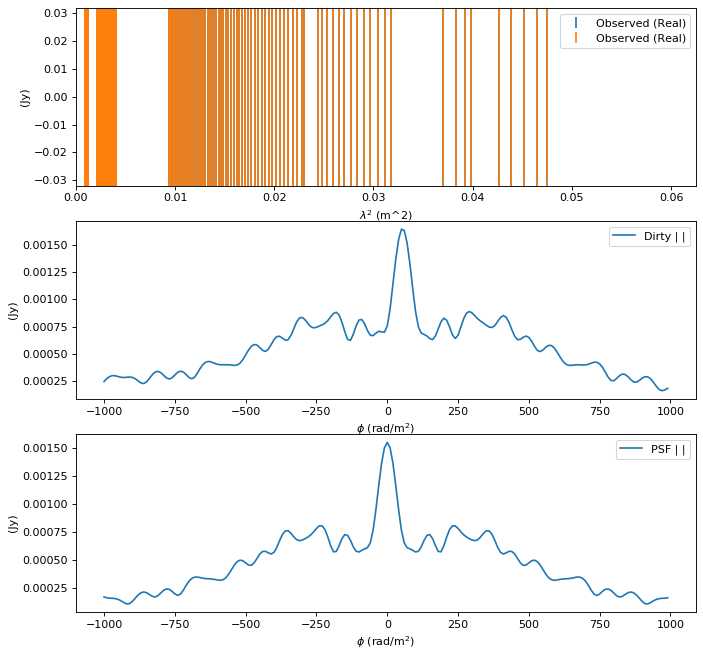

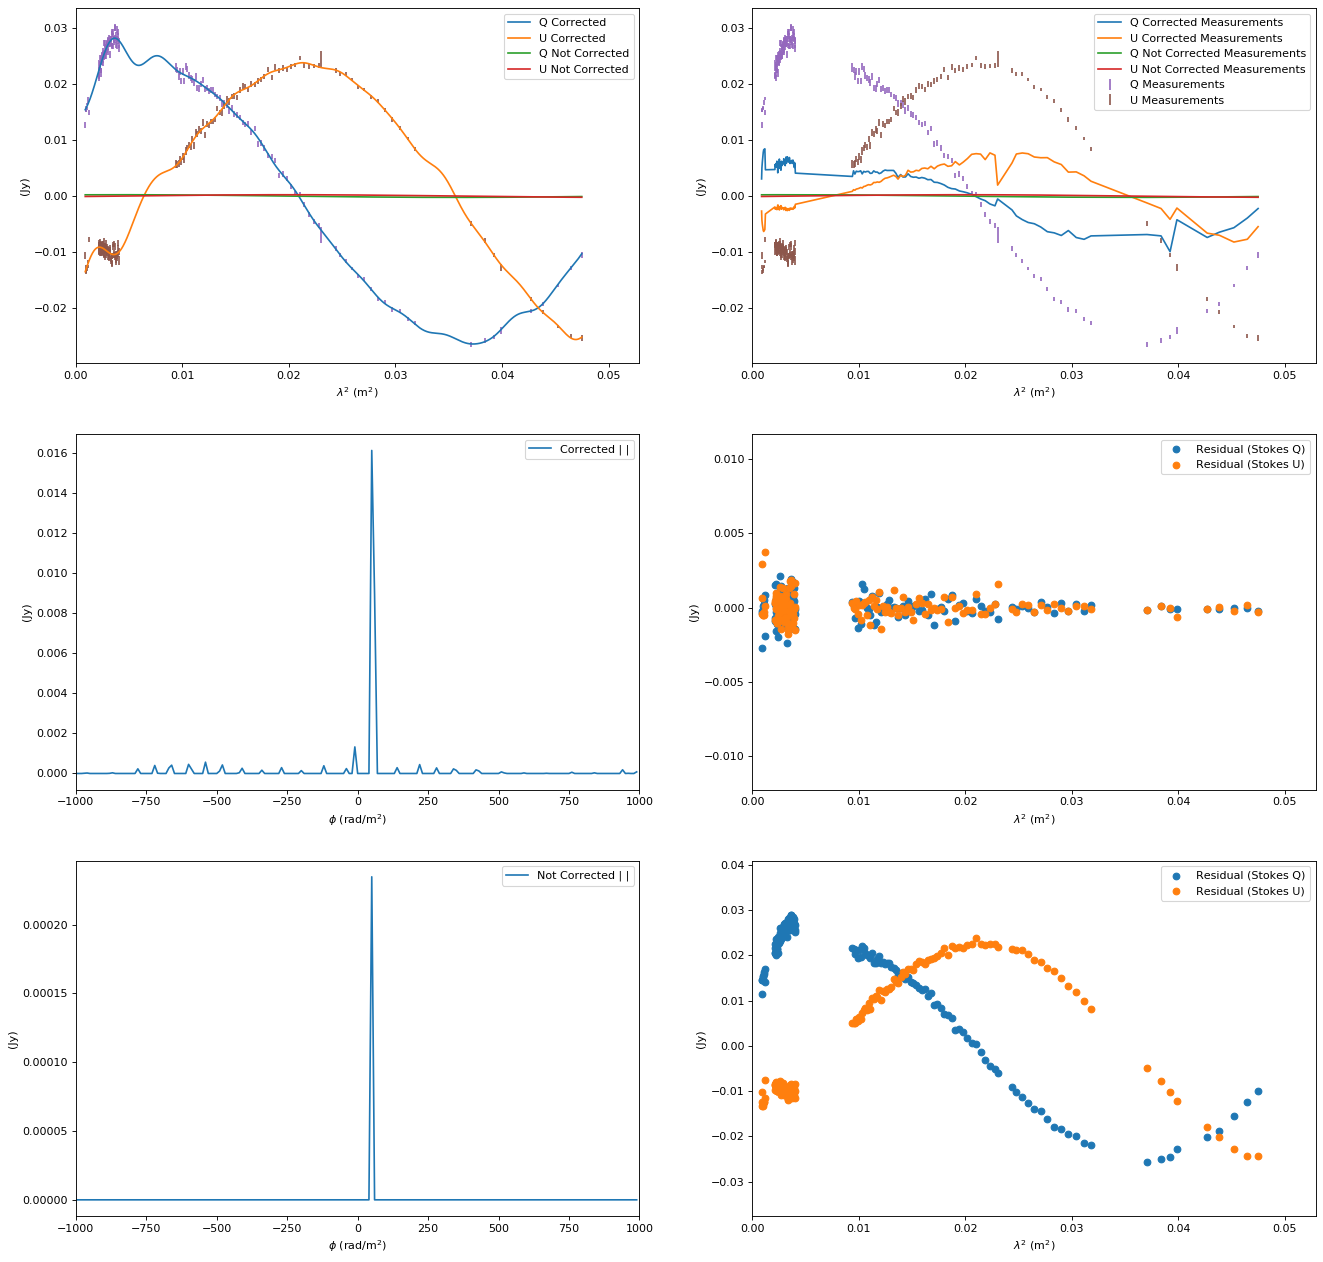

In [49]:
source = sources[33]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_s13'
2020-07-18 17:03:32,040 - Faraday Dreams - INFO - φ resolution 21.083601960135578 rad/m^2.
2020-07-18 17:03:32,041 - Faraday Dreams - INFO - φ max range is 279335.07348770136 rad/m^2.
2020-07-18 17:03:32,042 - Faraday Dreams - INFO - φ min range is 706.6294836586471 rad/m^2.
2020-07-18 17:03:32,071 - Optimus Primal - INFO - Starting Power method
2020-07-18 17:03:32,072 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 17:03:32,073 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-07-18 17:03:32,074 - Optimus Primal - INFO - [Power Method] Converged with iter = 12, tol = 7.573098930023729e-05
2020-07-18 17:03:32,075 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 17:03:32,075 - Faraday Dreams - INFO - Using an estimated noise level of 0.00032676217961125076 (weighted image units, i.e. Jy/Beam)
2020-07-18 17:03:32,076 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
202

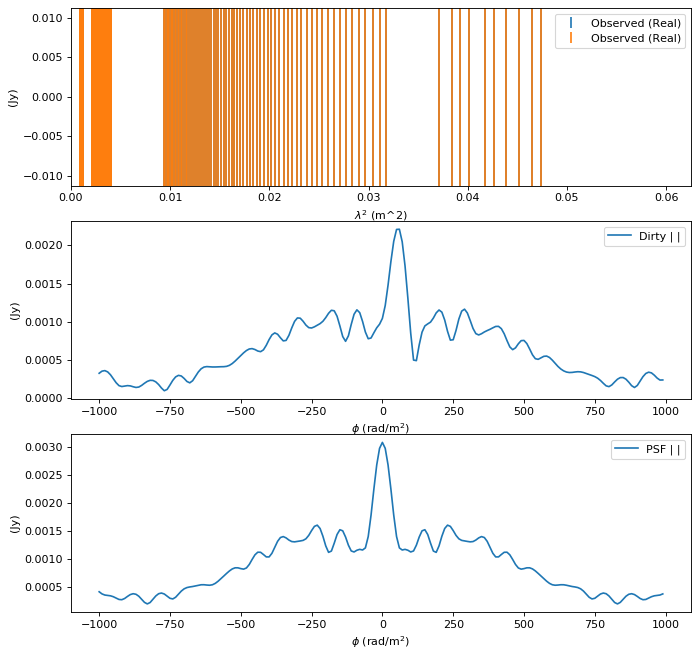

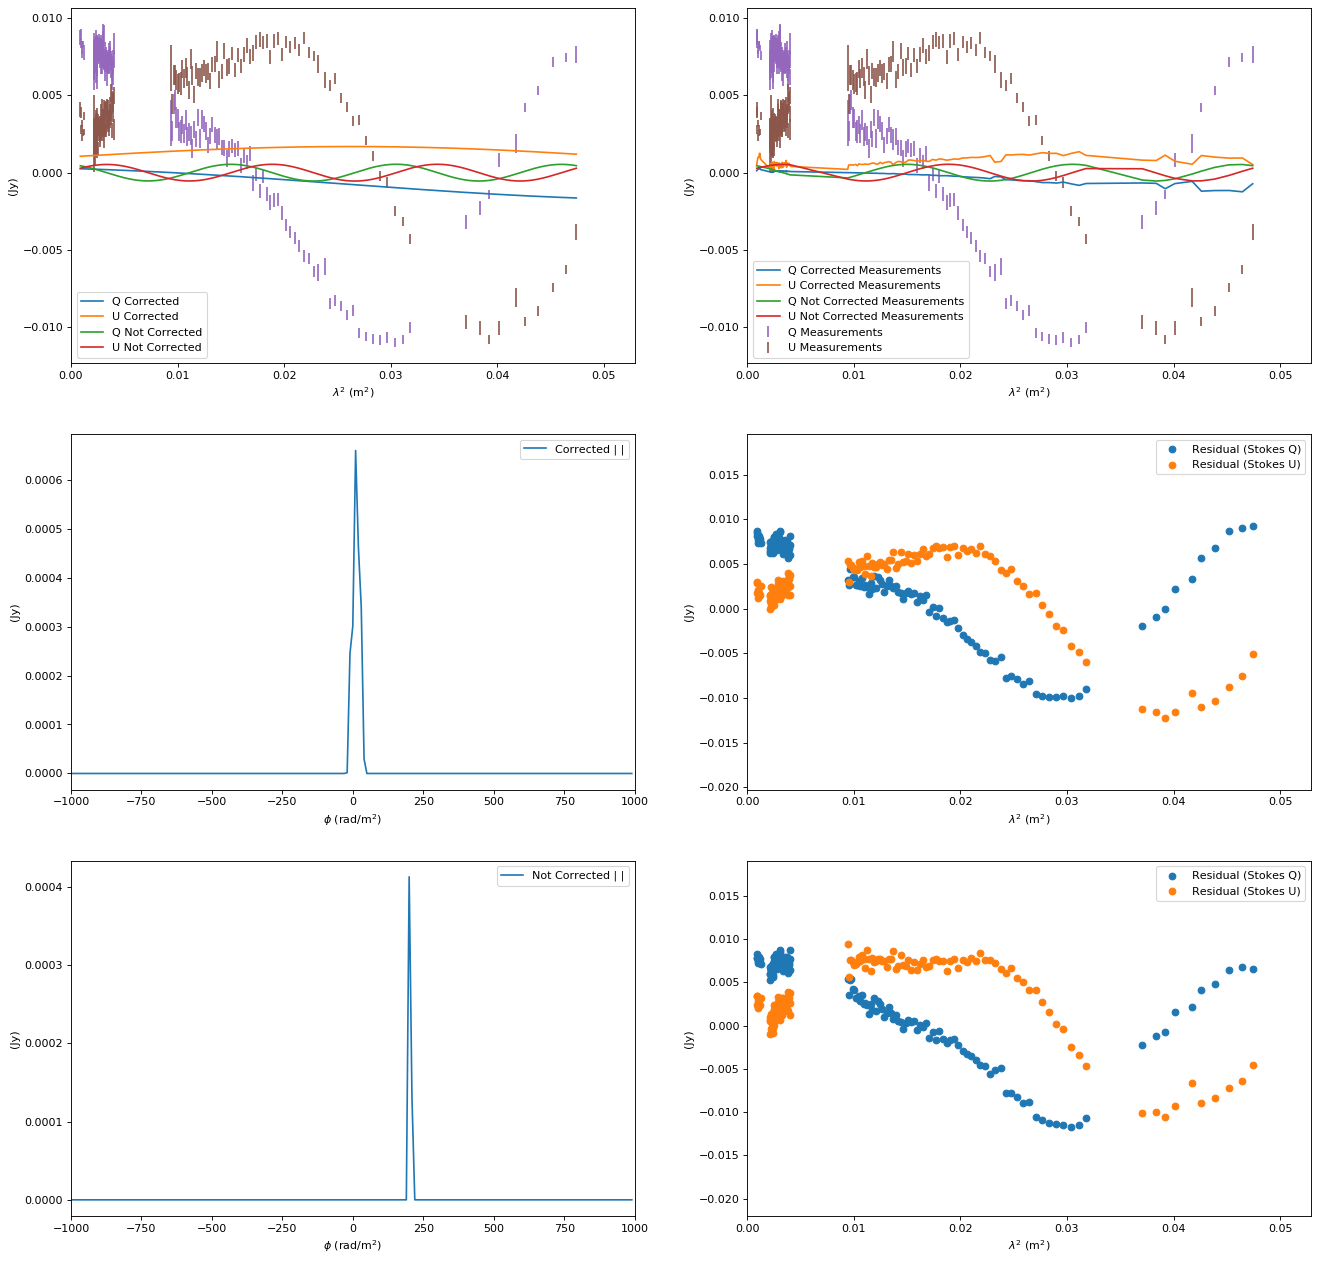

In [39]:
source = sources[34]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)

b'lmc_s14'
2020-07-18 23:39:34,364 - Faraday Dreams - INFO - φ resolution 21.463768756438824 rad/m^2.
2020-07-18 23:39:34,365 - Faraday Dreams - INFO - φ max range is 77151.39198990288 rad/m^2.
2020-07-18 23:39:34,366 - Faraday Dreams - INFO - φ min range is 725.8290871785133 rad/m^2.
2020-07-18 23:39:34,391 - Optimus Primal - INFO - Starting Power method
2020-07-18 23:39:34,392 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-07-18 23:39:34,393 - Optimus Primal - INFO - [Power Method] Converged with iter = 6, tol = 9.598895464135066e-05
2020-07-18 23:39:34,394 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 2 levels
2020-07-18 23:39:34,395 - Faraday Dreams - INFO - Using an estimated noise level of 0.00013270974159240723 (weighted image units, i.e. Jy/Beam)
2020-07-18 23:39:34,399 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-07-18 23:39:34,399 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020

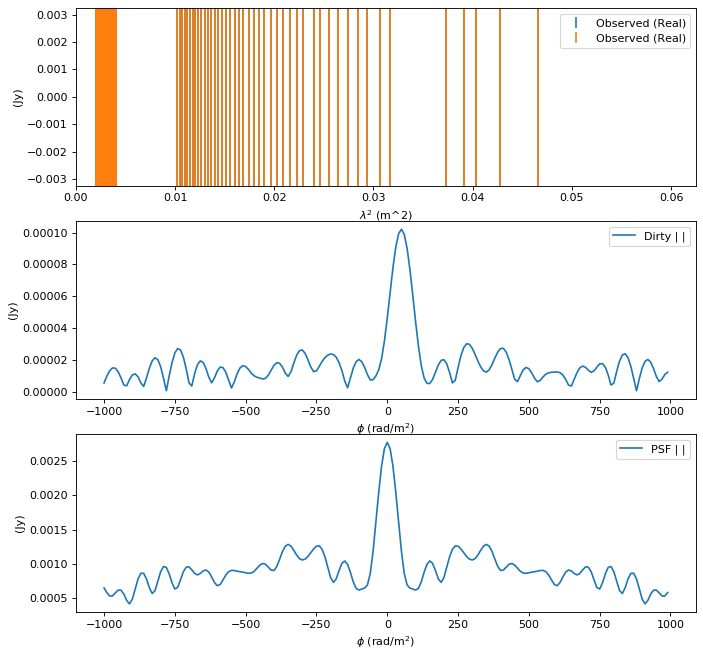

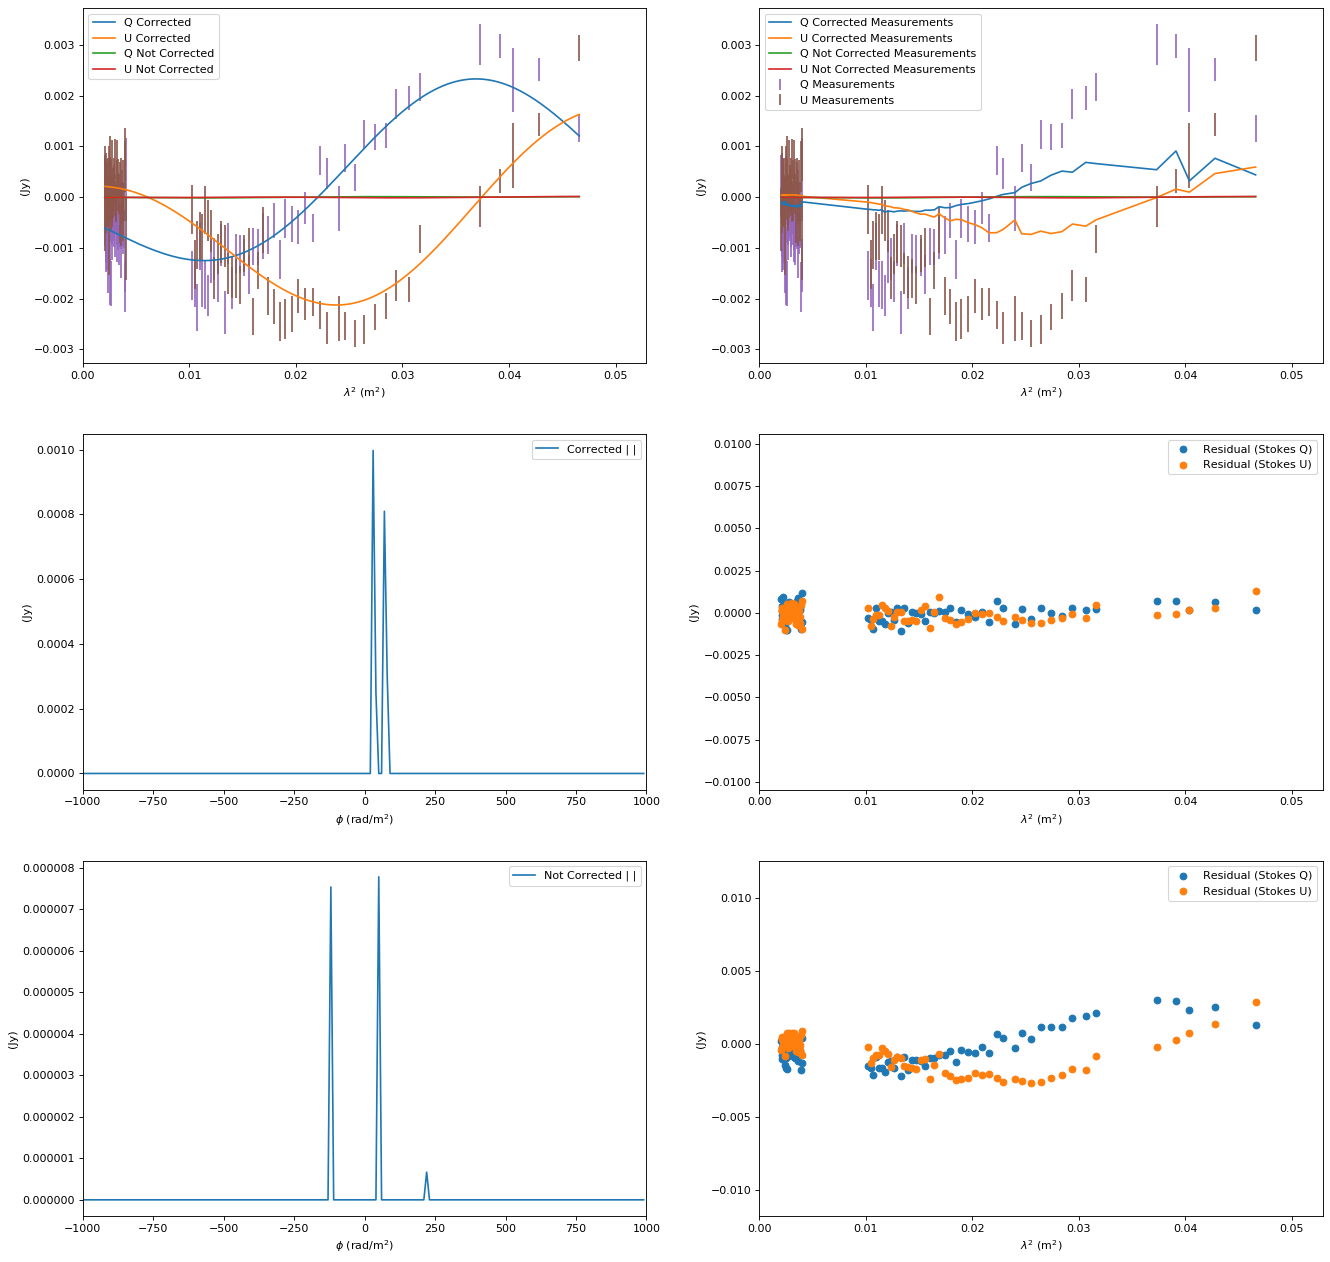

In [48]:
source = sources[35]
print(source)
wav = ['dirac']
levels = 2
sig_factor = 1
rm_max = 1000
beta = 1e-2
test_source(source, wav, levels, sig_factor, rm_max, beta)